---
# <div align="center"><font color='green'> COSC 2673/2793 | Computational Machine Learning | Assignment 2 </font></div>
## <div align="center"> <font color='red'> Student Name: Nguyen Gia Vinh                              </font></div>
## <div align="center"> <font color='red'> Student number: s4033810                           </font></div>
## <div align="center"> <font color='red'> Project: Number 1                           </font></div>
---

# Problem statement
The purpose of this assignment is to research and apply machine learning approaches to a modified real-world dataset in order to solve a machine learning problem, which is classification, by performing EDA, preprocessing data, and experimenting with various types of machine learning models. The task involves building models using suitable approaches and evaluating model performance using appropriate metrics, improving the performance of models through multiple techniques, and comparing different solutions. Furthermore, expansion research needs to be conducted to handle specific scenarios of the problem.

# Approach

In [1]:
# Import necessary libraries

# TensorFlow imports
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory, image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array, Sequence
from tensorflow.keras.models import clone_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Keras imports
from keras.layers import *

# Image processing
from PIL import Image
import imageio
import matplotlib.image as img

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data manipulation
import numpy as np
import pandas as pd

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_score, recall_score, f1_score, confusion_matrix, 
                             roc_auc_score, roc_curve, ConfusionMatrixDisplay, auc)
from sklearn.utils import resample, compute_class_weight
from sklearn.preprocessing import label_binarize

# Image augmentation
import imgaug.augmenters as iaa

# Computer vision
import cv2

# Other utilities
import os
import time
from itertools import cycle
import gc
import random
import math
from tqdm import tqdm

# I.EDA
For this process, I have done the following steps:
 - Step #1: Check image data information
 - Step #1: Import the data CSV files for each feature
 - Step #2: Check information in CSV files to understand the data set
 - Step #4: Check if the data set contains missing values
 - Step #5: Check class distribution for each target feature

There is another step can be applied for this process which is biavariate analysis which allows us to investigate the relationship between two target features which are `IsCancerous` and `CellType`, but since our scenario suggests separate model for each task, and each model will handle different target label and the data will be the image only, therefore, I have skipped this step for this implementation.

In [133]:
#Custom funnction to count number of image in the directory and return exist dimension values in the image data set 
def count_images_and_get_unique_sizes(directory):
    image_count = 0
    # using set() so the image size in will always be unique
    unique_sizes = set()

    for filename in os.listdir(directory):
        try:
            filepath = os.path.join(directory, filename)
            with Image.open(filepath) as img:
                image_count += 1
                #check image size
                size = img.size
                unique_sizes.add(size)
        except (IOError, FileNotFoundError):
            # Skip non-image files or files that cannot be opened by PIL
            continue

    return image_count, unique_sizes

# Example usage
directory_path = './patch_images'
images_count, unique_image_sizes = count_images_and_get_unique_sizes(directory_path)
print(f"Number of images: {images_count}")
print(f"Unique image sizes: {unique_image_sizes}")

Number of images: 20280
Unique image sizes: {(27, 27)}


### Observation
  - All image in the data set has the same dimension size (27x27) so a resize step won't be necessary.

## I.1 For 'IsCancerous' target output
 - For this output feature, I have used only the main csv file.

In [3]:
# Import data set meta data contains labels
original_data_ic = pd.read_csv('./data_labels_mainData.csv')

#Check data infomation 
print(original_data_ic.info())

# Check for data contain missing values => no missing values data in this data set
print(pd.isna(original_data_ic).sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB
None
InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64


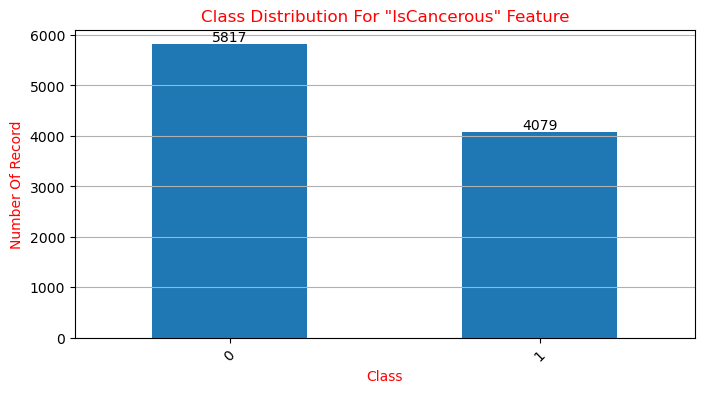

In [7]:
# Visulize class distribution for target feature
target_feature_distribution_ic = original_data_ic['isCancerous'].value_counts().sort_index()

# Plotting the data using bar chart
plt.figure(figsize=(8, 4))
ax = target_feature_distribution_ic.plot(kind='bar', color='#1f77b4')
plt.title('Class Distribution For "IsCancerous" Feature', color='red')
plt.xlabel('Class', color='red')
plt.ylabel('Number Of Record', color='red')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Add frequency labels on top of each bar
for i, count in enumerate(target_feature_distribution_ic):
    ax.text(i, count + 0.5, str(count), ha='center', va='bottom')

plt.show()

### Observation
  - Distribution of classes in the target feature is imbalanced, this might affect model performance by making it biased toward the majority class. 
  - Since there are only two classes in the target feature, the problem for this target feature is binary classification.
  - Since the target feature values are already in binary form (0/1), applying the encoding technique in the preprocessing phase won't be necessary.
  - There are no missing values in the data set.

## I.2 For 'CellType' target output
 - For this output feature, I have used both csv file to fully leverage the available data for the experience

In [3]:
# Import data set meta data contains labels
original_data_ct = pd.read_csv('./data_labels_mainData.csv')
extra_data_ct = pd.read_csv('./data_labels_extraData.csv')

#Check data infomation 
print(original_data_ct.info())
print(extra_data_ct.info())

# Check for data contain missing values => no missing values data in this data set
print(pd.isna(original_data_ct).sum())
print(pd.isna(extra_data_ct).sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10384 entries, 0 to 10383
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   InstanceID   10384 non-null  int64 
 1   patientID    10384 non-null  int64 
 2   ImageName    10384 non-null  object
 3   isCancerous  10384 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 324.6+ KB
None
InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0


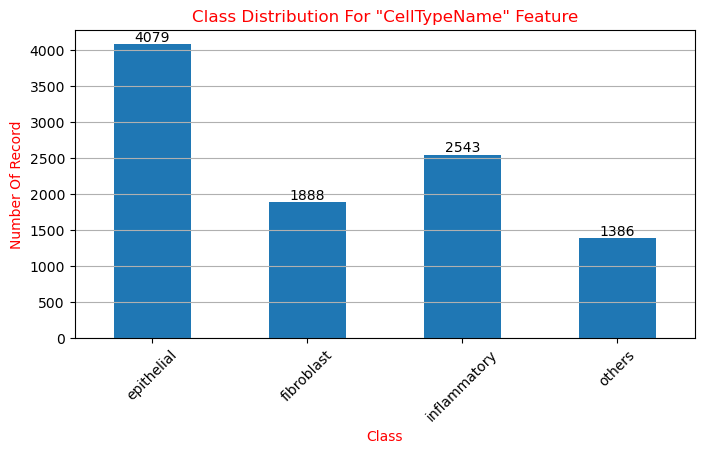

In [11]:
# Visulize class distribution for target feature
target_feature_distribution_ic = original_data_ct['cellTypeName'].value_counts().sort_index()

# Plotting the data using bar chart
plt.figure(figsize=(8, 4))
ax = target_feature_distribution_ic.plot(kind='bar', color='#1f77b4')
plt.title('Class Distribution For "CellTypeName" Feature', color='red')
plt.xlabel('Class', color='red')
plt.ylabel('Number Of Record', color='red')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Add frequency labels on top of each bar
for i, count in enumerate(target_feature_distribution_ic):
    ax.text(i, count + 0.5, str(count), ha='center', va='bottom')

plt.show()

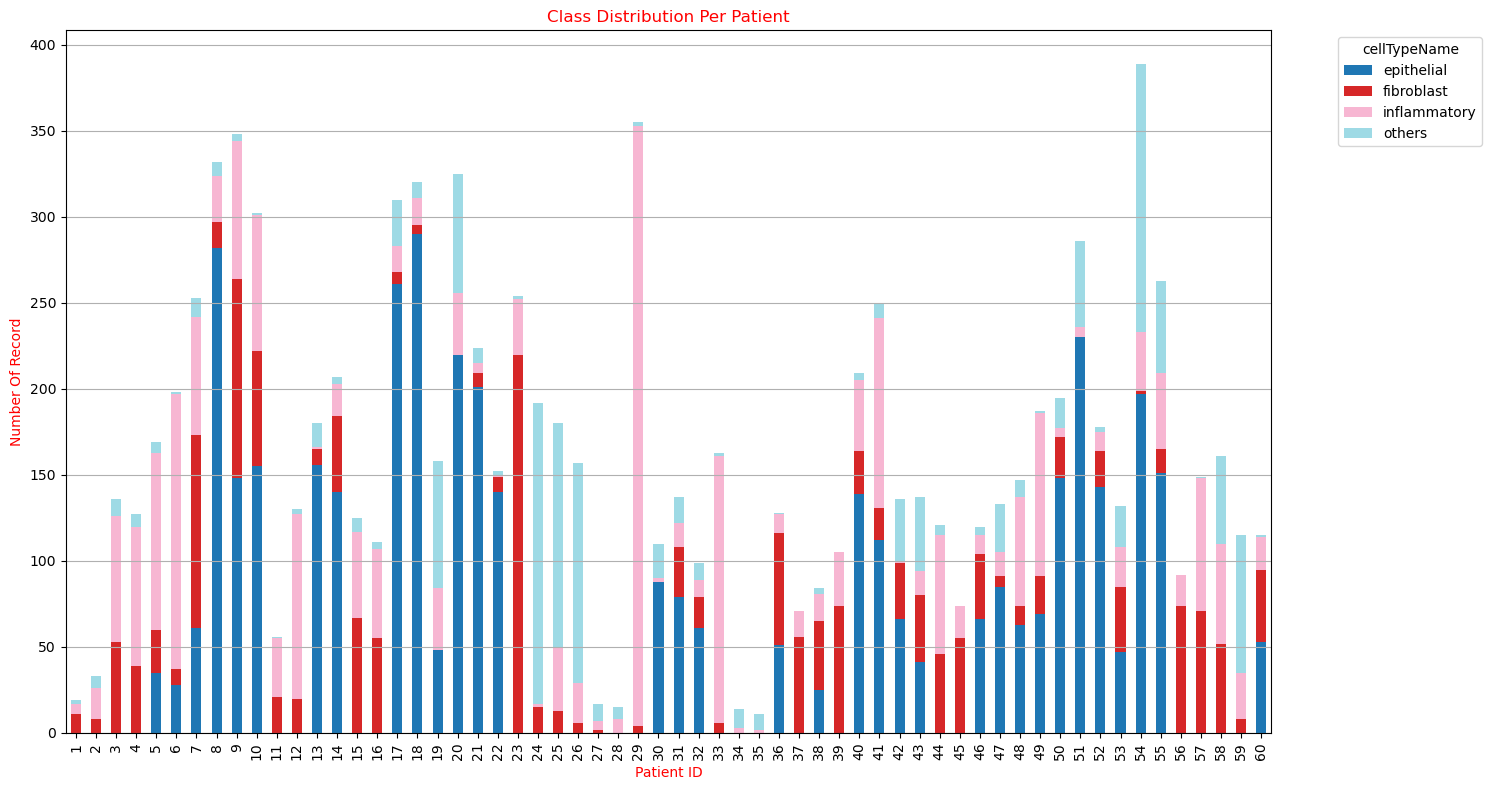

In [12]:
# Increase plot size for better visibility
fig, ax = plt.subplots(figsize=(15, 8))  # Increased size

# Plot the distribution per patient for the training dataset
grouped = original_data_ct.groupby(['patientID', 'cellTypeName']).size().unstack(fill_value=0)
grouped.plot(kind='bar', stacked=True, ax=ax, colormap='tab20')
ax.set_title(f'Class Distribution Per Patient', color='red')
ax.set_xlabel('Patient ID', color='red')
ax.set_ylabel('Number Of Record', color='red')
ax.legend(title='cellTypeName', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

### Observation
  - Distribution of classes in the target feature is an imbalance, this might affect model performance by making it biased toward the majority class
  - Since there are 4 classes in the target feature, the problem for this target feature is multi-class classification.
  - Encoding method might be necessary.
  - There are no missing values in the data set.

# II. Data processing

For this section, I have done the following processes:
- Split data for the experiment process using the hold-out validation technique. I have created separate data sets for each target feature. For our scenario, I have split the main data set into 3 sets which are: 
    - **Training data set** (65%): this set is used to obtain parameters (the weights) of the hypothesis during the training phase. This set is obtained by splitting data from the remaining data after splitting the test data set.
    - **Validation data set** (15%): this set is used to fine-tune the parameter during the training process. This set is obtained by splitting data from the remaining data after splitting the test data set
    - **Test data set** (20%): This set is used for evaluating the performance of the model, this data set won't be used for any step in the training phase. This data set is obtained by splitting the data from the original data set.
- Combine CSV file and image data to create a completed data set for the experiment using the `ImageDataGenerator` class of `TensorFlow` framework. Some important parameters need to be noticed that are:
    - **Rescale** (`rescale` parameter): the pixel values of the image will be normalized to the range of 0 to 1 (the original range of a pixel can be from 0-225) since neural networks perform better with a standard range value.
    - **Class mode** (`class_mode` parameter): will be defined based on the type of the problem, in this scenario, is `binary` for the `IsCancerous` target feature and `categorical` for the `CellType` target feature, one noticeable point that when class mode value is `categorical`, the label values will be one-hot encoded automatically which is necessary for muti-class classification.
    - **Shuffle** (`shuffle`): this parameter will control the shuffling of the data. For validation and test set, shuffling the data will make the model can't compare the predicted data with the actual value so it needs to be set as `False`.
- Since both target features have imbalance class distribution, I have decided to use the combination of image data augmentation technique and class weight mechanism for the training phase:
    - **Image augmentation**: This is a technique used to create more data by applying several transformations to existing data. In our scenario, I have used the following transformation option based on the input parameters of the augmentation class and created a custom Augmentation class based on the ImageDataGenerator class of Keras:
        - **Number of augmentation** (`num_augmentations` parameter): this is a custom parameter that decides how many augmentation options will be applied randomly among available options. For this parameter, I have tried several values, but a value of 4 gave me the best result. And for multiple class classification model, to bring the best outcome of the further process with the semi-supervised method which will be mentioned in section *III.2.4*, the data need to be augmented with 4 options specfically which are `Vertical Flip`, `Horizontal Flip`, `Rotation range` and `Fill Mode`.
        - **Rotation range** ( `rotation_range` parameter): the image will be rotated by a defined degree value.
        - **Width shift range** (`width_shift_range` parameter): the image will be shifted left or right randomly by the defined percentage value of the image width.
        - **Weight shift range** (`height_shift_range` parameter): the image will be shifted up or down randomly by a defined percentage value of the image height.
        - **Shear range** (`shear_range` parameter): the image will be slanted (shear transformation) by defined radians value.
        - **Zoome range** (`zoom_range` parameter): the image will be zoomed in or out randomly by a defined percentage value.
        - **Brightness range** (`brightness_range` parameter): the image brightness will be adjusted randomly based on defined percentage values.
        - **Horizontal Flip** (`horizontal_flip` parameter): the image will be flipped horizontally at random.
        - **Vertical Flip** (`horizontal_flip` parameter): the image will be flipped vertically at random.
        - **Fill Mode** (`fill_mode` parameter): rotation or shift transformation will create some new pixels in the image, this parameter decides how those pixels will be filled, in this scenario, I have set the option to fill them with the near pixel value.
    - **Class weights**: This a mechanism that allows model to measure of the importance of different classes in the training process. Usually, higher weight will be assigned to minority classes and lower weight will be assigned to majority classes. This mechanism will increase the sensitivity of the model toward minority classes. For this scenario, I have computed the class weights using the `compute_class_weight` function of the `skit-learn` library.
    - Combining both methods will increase the robustness of the model toward the imbalance problem of the data set, while augmentation helps to improve the quality and quantity of the minority class data, class weights will help the model control the bias of the model, and improve the learning process.

**Other Discussion**: There is another possible consideration which is the data leakage can be prevent by split data set by patientID using a function called `GroupShuffleSplit` of ScikitLearn library, but since the image label is also unique, therefore splitting the data set using normal spitting method is acceptable along with the mechanism to check if there is any duplicated image in all data sets.

In [8]:
# Create a custom class for Augmentation image data generator
class AugmentationImageDataGenerator(tf.keras.preprocessing.image.ImageDataGenerator):
    def __init__(self, num_augmentations=3, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_augmentations = num_augmentations

        # Determine which augmentations are actually enabled
        self.available_augmentations = []
        if self.rotation_range:
            self.available_augmentations.append("theta")
        if self.width_shift_range:
            self.available_augmentations.append("tx")
        if self.height_shift_range:
            self.available_augmentations.append("ty")
        if self.shear_range:
            self.available_augmentations.append("shear")
        if self.zoom_range:
            self.available_augmentations.extend(["zx", "zy"])
        if self.brightness_range:
            self.available_augmentations.append("brightness")
        if self.horizontal_flip:
            self.available_augmentations.append("flip_horizontal")
        if self.vertical_flip:
            self.available_augmentations.append("flip_vertical")
    # Function to apply augment tranformation to the image
    def apply_transform(self, x, transform_parameters):
        # Randomly select N from available augmentations
        selected_augmentations = random.sample(
            self.available_augmentations, 
            min(self.num_augmentations, len(self.available_augmentations))
        )

        # Filter transform parameters to only keep selected ones
        filtered_transform_parameters = {
            key: value for key, value in transform_parameters.items()
            if key in selected_augmentations
        }

        return super().apply_transform(x, filtered_transform_parameters)

## II.1 For 'IsCancerous' target output

### II.1.1 Spliting the data into different sets for the experience

In [5]:
# Split data set into train, validation, and test set
original_data_ic['isCancerous'] = original_data_ic['isCancerous'].astype(str)
# Using random state value to stabilizing the reproducibility.
udtrain_data_ic, test_data_ic = train_test_split(original_data_ic, test_size=0.2, random_state=42)
train_data_ic, val_data_ic = train_test_split(udtrain_data_ic, test_size=0.2, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data_ic.shape[0], val_data_ic.shape[0], test_data_ic.shape[0]))

Train data : 6332, Val Data: 1584, Test Data: 1980


In [7]:
# Handling leakage between sets
# 'ImageName' is a unique identifier for each sample
train_ids = set(train_data_ic['ImageName'])
val_ids = set(val_data_ic['ImageName'])
test_ids = set(test_data_ic['ImageName'])

# Check for overlaps
train_val_overlap = train_ids.intersection(val_ids)
train_test_overlap = train_ids.intersection(test_ids)
val_test_overlap = val_ids.intersection(test_ids)

# Print results
if train_val_overlap:
    print(f"Overlap between train and validation sets: {len(train_val_overlap)} samples")
else:
    print("No overlap between train and validation sets.")

if train_test_overlap:
    print(f"Overlap between train and test sets: {len(train_test_overlap)} samples")
else:
    print("No overlap between train and test sets.")

if val_test_overlap:
    print(f"Overlap between validation and test sets: {len(val_test_overlap)} samples")
else:
    print("No overlap between validation and test sets.")

No overlap between train and validation sets.
No overlap between train and test sets.
No overlap between validation and test sets.


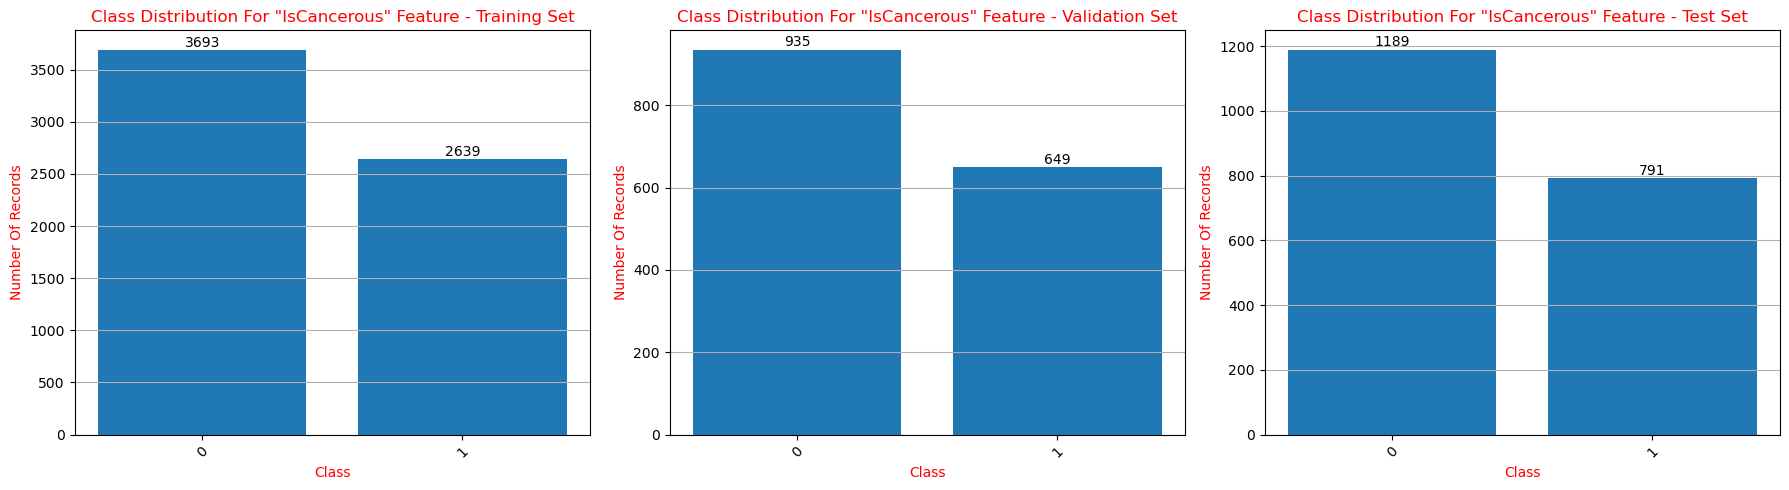

In [21]:
# Visulize class distribution for target feature between each set
# Create vertical subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 3 rows, 1 column

# List of datasets and titles
datasets = [
    (train_data_ic, 'Training'),
    (val_data_ic, 'Validation'),
    (test_data_ic, 'Test')
]

# PLot data distribution
for ax, (data, name) in zip(axes, datasets):
    target_feature_distribution_ic = data['isCancerous'].value_counts().sort_index()

    bars = ax.bar(target_feature_distribution_ic.index.astype(str),
                  target_feature_distribution_ic.values,
                  color='#1f77b4')

    ax.set_title(f'Class Distribution For "IsCancerous" Feature - {name} Set', color='red')
    ax.set_xlabel('Class', color='red')
    ax.set_ylabel('Number Of Records', color='red')
    ax.set_xticks(range(len(target_feature_distribution_ic)))
    ax.set_xticklabels(target_feature_distribution_ic.index.astype(str), rotation=45)
    ax.grid(axis='y')

    # Add frequency labels on top of each bar
    for i, count in enumerate(target_feature_distribution_ic.values):
        ax.text(i, count + 0.5, str(count), ha='center', va='bottom')

# Adjust layout for spacing
plt.tight_layout()
plt.show()

Found 6332 validated image filenames belonging to 2 classes.
Found 1584 validated image filenames belonging to 2 classes.
Found 1980 validated image filenames belonging to 2 classes.
Training Dataset:


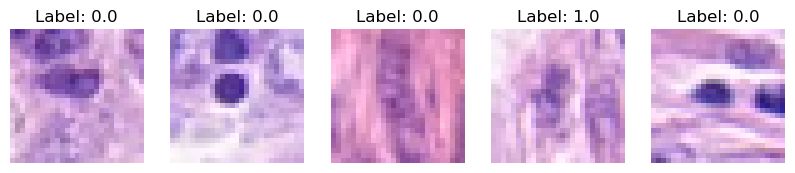

Validation Dataset:


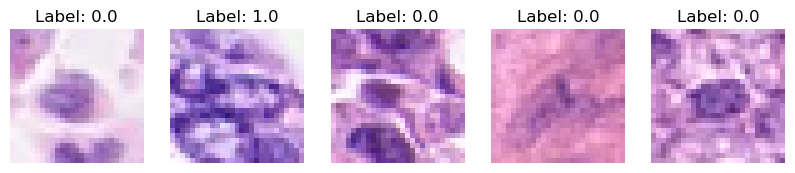

Test Dataset:


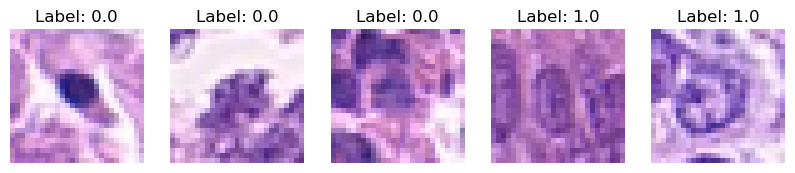

In [8]:
# Generating final data set
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255 )
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

# Un-processed train set
train_ds_ic = train_datagen.flow_from_dataframe(
        dataframe=train_data_ic,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)

# Validation set
val_ds_ic = val_datagen.flow_from_dataframe(
        dataframe=val_data_ic,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)

# Test Set
test_ds_ic = val_datagen.flow_from_dataframe(
        dataframe=test_data_ic,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)

# Define a function to plot some sample images for each class in the data set
def display_images(data_generator, num_images=5):
    images, labels = next(data_generator)  # Get a batch of images and labels
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow((images[i] * 255).astype('uint8'))  # Scale from [0, 1] to [0, 255] before conversion
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    plt.show()  # Display the images

# Display images from training dataset
print("Training Dataset:")
display_images(train_ds_ic)

# Display images from validation dataset
print("Validation Dataset:")
display_images(val_ds_ic)

# Display images from test dataset
print("Test Dataset:")
display_images(test_ds_ic)

### II.1.2 Handling imbalancing problem for target feature

Found 6332 validated image filenames belonging to 2 classes.


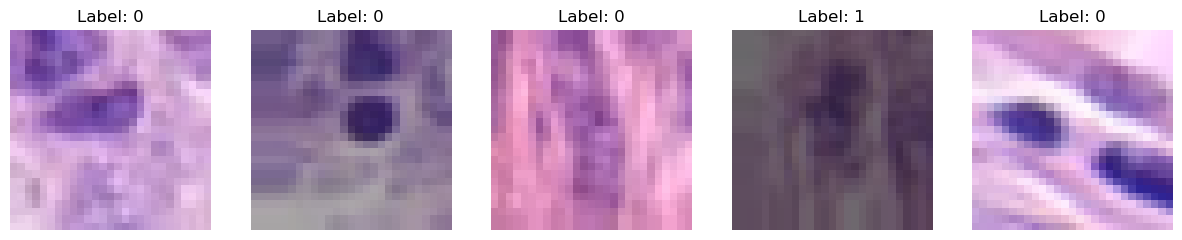

In [9]:
# Create an augmentation data set
us_raw_train_data_ic = train_data_ic.copy()

# Calling custom Augmentation class 
augmentation_generator = AugmentationImageDataGenerator(
    num_augmentations=4,
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.2, 1.0],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

#Finalize the train data set for augmentation
us_train_ds_ic = augmentation_generator.flow_from_dataframe(
        dataframe=us_raw_train_data_ic,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)

# Fetch a batch of images and labels
images, labels = next(us_train_ds_ic)

# Number of images to display
num_images_to_display = 5

# Plot images
plt.figure(figsize=(15, 3))
for i in range(num_images_to_display):
    ax = plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {int(labels[i])}")
    plt.axis("off")
plt.show()

In [31]:
# Calculate class weights
class_label_ic = train_data_ic['isCancerous'].astype(int)  # Convert labels to int for class weight calculation
unique_classes_ic = np.unique(class_label_ic)
class_weights_ic = compute_class_weight('balanced', classes=unique_classes_ic, y=class_label_ic)
class_weight_dict_ic = dict(enumerate(class_weights_ic))

print("Class Weights:", class_weight_dict_ic)

Class Weights: {0: 0.8572975900352018, 1: 1.1996968548692686}


### Observation
  - There is no data leakage after splitting the data set.
  - The distribution of classes is similar between data sets even with the imbalance problem.

## II.2 For 'CellType' target output

### II.2.1 Spliting the data into different sets for the experience

In [5]:
# Split data set into train, validation, and test set
original_data_ct['cellTypeName'] = original_data_ct['cellTypeName'].astype(str)
udtrain_data_ct, test_data_ct = train_test_split(original_data_ct, test_size=0.2, random_state=42)
train_data_ct, val_data_ct = train_test_split(udtrain_data_ct, test_size=0.2, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data_ct.shape[0], val_data_ct.shape[0], test_data_ct.shape[0]))

Train data : 6332, Val Data: 1584, Test Data: 1980


In [5]:
# Handling leakage between sets
# 'ImageName' is a unique identifier for each sample
train_ids = set(train_data_ct['ImageName'])
val_ids = set(val_data_ct['ImageName'])
test_ids = set(test_data_ct['ImageName'])

# Check for overlaps
train_val_overlap = train_ids.intersection(val_ids)
train_test_overlap = train_ids.intersection(test_ids)
val_test_overlap = val_ids.intersection(test_ids)

# Print results
if train_val_overlap:
    print(f"Overlap between train and validation sets: {len(train_val_overlap)} samples")
else:
    print("No overlap between train and validation sets.")

if train_test_overlap:
    print(f"Overlap between train and test sets: {len(train_test_overlap)} samples")
else:
    print("No overlap between train and test sets.")

if val_test_overlap:
    print(f"Overlap between validation and test sets: {len(val_test_overlap)} samples")
else:
    print("No overlap between validation and test sets.")

No overlap between train and validation sets.
No overlap between train and test sets.
No overlap between validation and test sets.


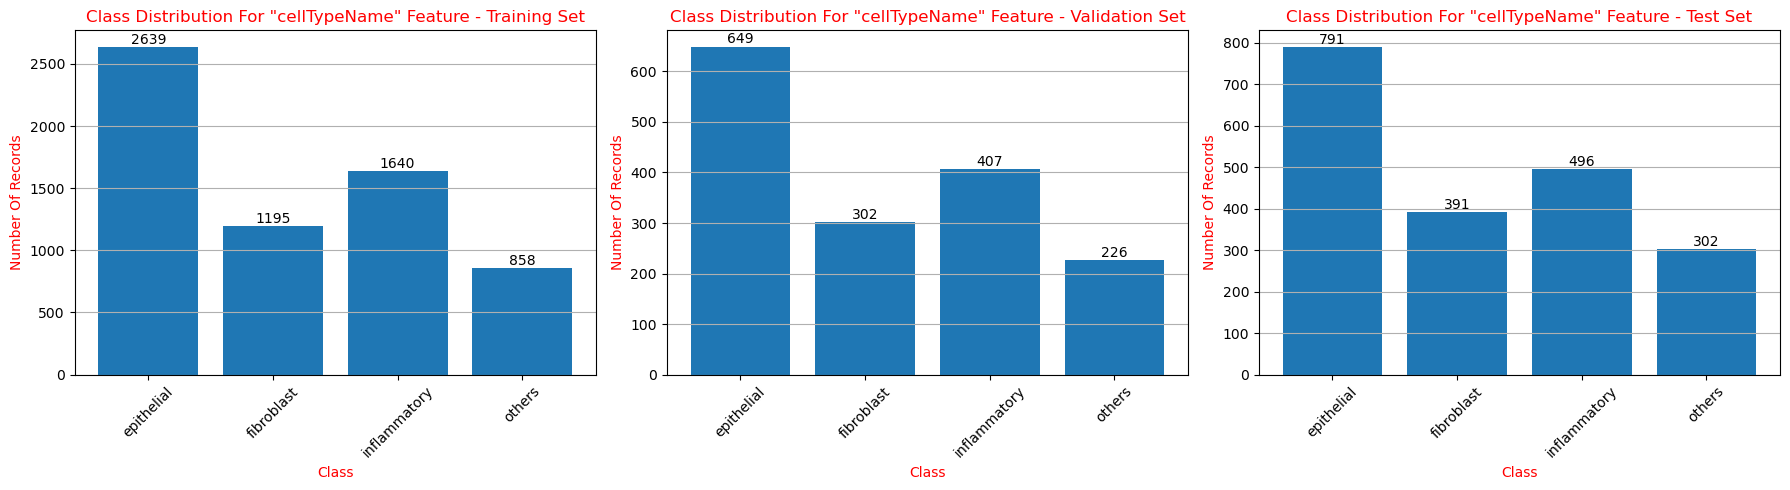

In [41]:
# Visulize class distribution for target feature between each set
# Create vertical subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 3 rows, 1 column

# List of datasets and titles
datasets = [
    (train_data_ct, 'Training'),
    (val_data_ct, 'Validation'),
    (test_data_ct, 'Test')
]

# PLot data distribution
for ax, (data, name) in zip(axes, datasets):
    target_feature_distribution_ic = data['cellTypeName'].value_counts().sort_index()

    bars = ax.bar(target_feature_distribution_ic.index.astype(str),
                  target_feature_distribution_ic.values,
                  color='#1f77b4')

    ax.set_title(f'Class Distribution For "cellTypeName" Feature - {name} Set', color='red')
    ax.set_xlabel('Class', color='red')
    ax.set_ylabel('Number Of Records', color='red')
    ax.set_xticks(range(len(target_feature_distribution_ic)))
    ax.set_xticklabels(target_feature_distribution_ic.index.astype(str), rotation=45)
    ax.grid(axis='y')

    # Add frequency labels on top of each bar
    for i, count in enumerate(target_feature_distribution_ic.values):
        ax.text(i, count + 0.5, str(count), ha='center', va='bottom')

# Adjust layout for spacing
plt.tight_layout()
plt.show()

Found 6332 validated image filenames belonging to 4 classes.
Found 1584 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.
Training Dataset:


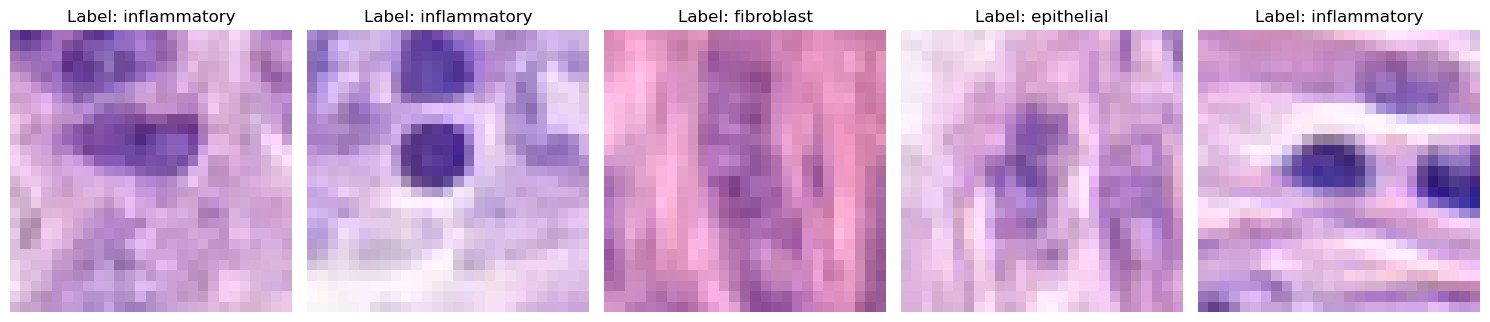

Validation Dataset:


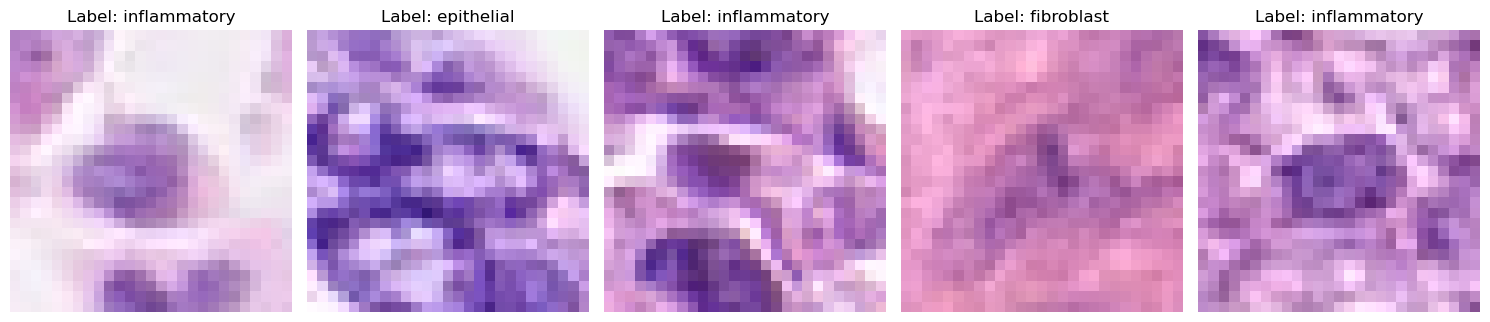

Test Dataset:


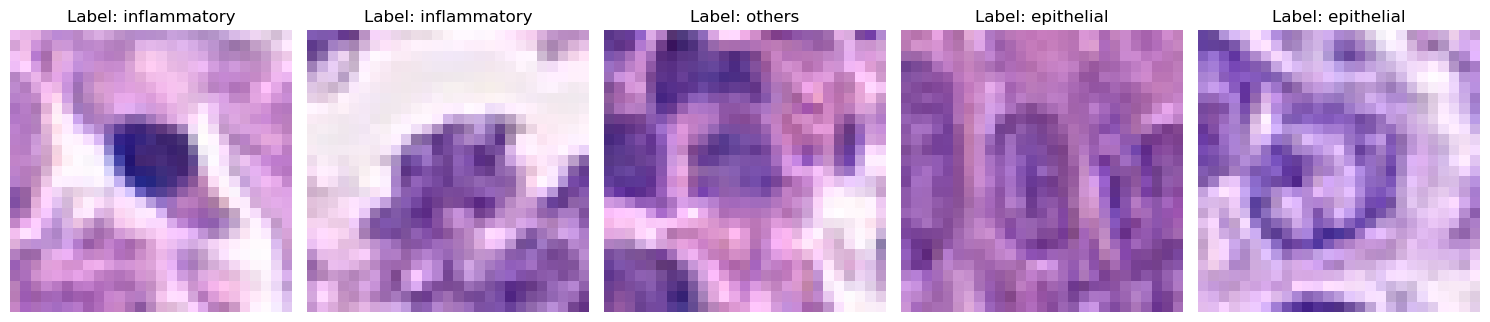

In [7]:
# Generating final data set
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255 )
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_ds_ct = train_datagen.flow_from_dataframe(
        dataframe=train_data_ct,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

val_ds_ct = val_datagen.flow_from_dataframe(
        dataframe=val_data_ct,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

test_ds_ct = val_datagen.flow_from_dataframe(
        dataframe=test_data_ct,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

# Define a function to plot some sample images for each class in the data set
def display_images(data_generator, num_images=5):
    images, labels = next(data_generator)  # Get a batch of images and labels

    # Create reverse mapping from class index to label name
    class_indices = data_generator.class_indices
    index_to_class = {v: k for k, v in class_indices.items()}

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow((images[i] * 255).astype('uint8'))
        label_index = np.argmax(labels[i])  # Get index of hot class
        label_name = index_to_class[label_index]  # Map to string
        plt.title(f"Label: {label_name}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Display images from training dataset
print("Training Dataset:")
display_images(train_ds_ct)

# Display images from validation dataset
print("Validation Dataset:")
display_images(val_ds_ct)

# Display images from test dataset
print("Test Dataset:")
display_images(test_ds_ct)

### II.2.2 Handling imbalancing problem for target feature

Found 6332 validated image filenames belonging to 4 classes.


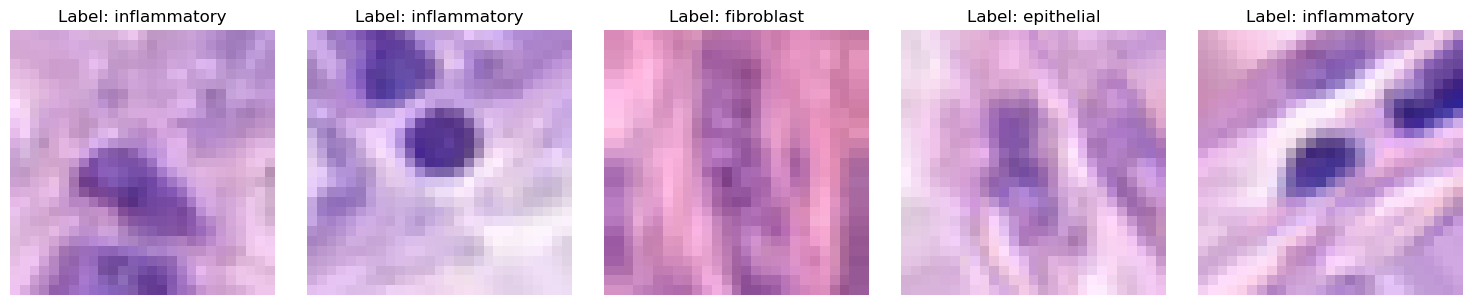

In [11]:
# Create an augmentation data set
us_raw_train_data_ct = train_data_ct.copy()

# Augmentation with specific options
augmentation_generator = ImageDataGenerator(rescale=1./255,
                                                horizontal_flip=True,
                                                vertical_flip=True,
                                                zoom_range=0.2,
                                                rotation_range=40,
                                                fill_mode='nearest'
                                            )

#Finalize the data set for augmentation
us_train_ds_ct = augmentation_generator.flow_from_dataframe(
        dataframe=us_raw_train_data_ct,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

# Fetch a batch of images and labels
images, labels = next(us_train_ds_ct)

# Number of images to display
num_images_to_display = 5

# Plot images
plt.figure(figsize=(15, 3))
for i in range(num_images_to_display):
    ax = plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(images[i])
    # Find the class label from the one-hot encoded label
    label_index = tf.argmax(labels[i])
    class_label = us_train_ds_ct.class_indices
    class_name = list(class_label.keys())[list(class_label.values()).index(label_index)]
    plt.title(f"Label: {class_name}")
    plt.axis("off")
plt.tight_layout()    
plt.show()

In [13]:
# Calculate class weights
class_labels_ct = train_data_ct['cellType'].astype(int)  # Convert labels to int for class weight calculation

# Retrieve unique classes
unique_classes_ct = np.unique(class_labels_ct)

# Compute class weights
class_weights_ct = compute_class_weight('balanced', classes=unique_classes_ct, y=class_labels_ct)
class_weight_dict_ct =dict(enumerate(class_weights_ct))
print("Class Weights:", class_weight_dict_ct)

Class Weights: {0: 1.3246861924686193, 1: 0.9652439024390244, 2: 0.5998484274346343, 3: 1.844988344988345}


### Observation
  - There is no data leakage after splitting the data set.
  - The distribution of classes is similar between data sets even with the imbalance problem.

# III. Model building
- For each target output, there will be two models:
    - **Baseline model**: a simple model to obtain a baseline measurement of the data set, this model will not apply any optimization techniques (on both the data set and the model)
    - **Solution model**: this model will be enhanced by applying several techniques on both data dataset and the model, with a different structure from the baseline model
- Details information of each model will be discussed in its section.

### Hyper parameters
There are several hyperparameters which I have used for this scenario, first are some common parameters of neural networks:
- **Learning Rate**: This hyperparameter controls how much model parameters will be adjusted during each iteration by the optimization process (loss function). Too high a learning rate might cause the model to pass the minimum, leading to a convergence issue, while too low a learning rate might increase the training time.
- **Batch size**: The number of training samples used to fine-tune the model weights in a single iteration. Too big a batch size can reduce training time, but may cause the model to overfit, while a small batch size increases the training time of the model, but provides a better generalization.
- **Number of neurons**: The number of neurons in each layer of the neural network. Too many neurons can make the model overfit while too less neurons can make the model underfit because it is too simple and can not capture the data pattern.
- **Number of Hidden layer**: The number of neuron layers between the input and output layers. More hidden layers will increase model capacity, allowing it to capture more complex patterns of the data, but too many hidden layers will cause the model to overfit and increase computational cost.
- **Activation Function**: This function is applied to neuron outputs to introduce non-linearity, which allows the network to learn complex patterns of the data. There are many types of activation functions, such as Relu, Tanh, or Sigmoid, etc.. And each of them will be suitable for a specific situation based on its mechanism.
- **Regularization Techniques Parameters**: these technique has the same purpose, which is to simplify the model to avoid an overfitting situation. In this scenario, I only used two techniques, which are dropout and L2 regularization:
    - **Drop out**: For every new batch of data, the model will randomly pick some neurons and turn them off (won't learn and update). The seed value will ensure that every time the model is re-trained, the dropout neurons will be the same. This method will prevent neurons too relying too much on each other and force them to learn multiple independent representations(fewer neurons learn the same aspect of the data, which is very wasteful).
    - **L2 regularization**: This technique will add a penalty to the loss function for having a large weight value, so it will shrink the weight. A large weight can make the model very sensitive to small changes, leading to unstable predictions. The λ (lambda-alpha) will control the regularization strength.
- **Optimizer**: This is the algorithm that updates the weights to minimize the loss function. Each type of optimizer will have a different mechanism and will affect how fast and well the model learning process.
- **Epoch**: The number of times the model is trained on the full training dataset. Too many epochs can lead to overfitting, while too few epochs might cause the model to underfit.
- **Step Per Epochs**: This parameter defines how many batches will be processed each epoch for training data.
- **Validation Steps**: Similar to the step per epoch, but for the validation set.

Next will be the special hyperparameters of CNN:
- **Kernel Size**: Kernel is a matrix (filter) that slides through the image to extract features; kernel size will control how big the matrix is.
- **Convolutional Layer and Filter Count**: this layer applies multiple filters to the input to extract different features, and filter count controls the number of filters; each filter will learning different features.
- **Pooling layer**: This layer reduce the size(dimension) of the data , keep only important information. Each type of pooling layer will have a different mechanism to keep the information.
- **Stride**: This value decides how many pixels the kernel(filter) will move at a time when sliding through the image. 
- **Padding**: This hyperparameter controls the size of the output by adding extra pixels around the edge of the input.
- **Batch Normalization Layer(BNL)**: After the convolutional layer, the output can be very big. BNL helps to normalize these outputs to have a mean of 0 and a standard deviation of 1, which helps the model to train faster and more stably.

And I have also used some extra hyperparameters such as:
- **Call Back Function**: For this scenario, I have used a Keras callback function (`ReduceLROnPlateau`) for the adaptive learning rate mechanism, which allows the model to change the learning rate value dynamically based on the performance metrics. This will allow the model to have a robust learning process and better convergence. This callback function will control the following hyperparameters:
  - **Monitoring** (`monitoring` parameter): This will be the main attribute used to control the learning rate, can be `loss`, `accuracy`, or other performance metrics value.
  - **Factor** (`factor` parameter): This parameter controls the reduction rate of the learning rate.
  - **Coldown** (`coldown` parameter): This parameter controls the coldown time of the function by epoch units; value = 0 means it will keep monitoring the model every epoch without rest.
  - **Patience** (`patience` parameter): This controls the number of epochs to wait before reducing the learning rate if the `monitoring` metric value doesn't improve.
  - **Minimum Learning Rate** (`min_lr` parameter): The learning rate value will never go lower than this value to avoid becoming too small the freezing the model from training.
    
### Model evaluation framework
Since our data set suffers from a class imbalance problem, and this is a medical field problem, using accuracy and loss as measurement metrics is not enough; therefore, I have used the following metrics as performance measurement metrics:

- **Precision**: Precision measures the accuracy in prediction of the model (`True Positive/(True Positive + False Positive)`). 
- **Recall**: Recall measures the prediction ability of the model (`True Positive/(True Positive + False Negative`) which is critical for this scenario since the problem is predicting cancer status and cancer type 
- **F1 Score**: This metric is the combination of both Precision and Recall (`2x(Precision x Recall)/(Precision + Recall)`), which provides a balanced view of the model performance, which is very suitable for this scenario since our data set is very imbalanced.
- **Receiver Operating Characteristic (ROC) Curve**: Since most models' output is in probability form, they need a threshold value to define which class the output actually in. Therefore, ROC demonstrates the model performance at different thresholds using False Positive Rate (FPR: How often negative examples are labeled as positive) and True Positive Rate (TPR: How often positive examples are classified correctly) for each class of the target output. The final curve will display the portion between TPR and FPR at all thresholds.
- **Area Under The Curve (AUC)**: The area mentioned here is the area under the ROC curve; the value of AUC demonstrates how good the ROC curve is; the closer the AUC to 1, the better the model performance. 

For multiple class classification problem, `Precision`, `Recall` and `F1 Scored` will be calculated using `Macro Average` mechanism, that each metric will be calculated independently for each class and the final value will be the average between all class, this mechanism will treat each class equally which is very importance in this scenario since the data is imbalance in class distribution.


In [15]:
# Custom function to plot ROC curve for binary classification model
def plot_roc_auc_binary(y_true, y_pred_probs):
    """
    Plots the ROC curve and calculates the AUC for binary classification.

    :param y_true: Array of true binary labels (0s and 1s).
    :param y_pred_probs: Array of predicted probabilities for the positive class.
    """
    # Calculate false positive rate (FPR) and true positive rate (TPR) for various thresholds
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    
    # Calculate the AUC (Area Under the Curve) score
    auc_score = roc_auc_score(y_true, y_pred_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Custom function to plot ROC curve for multi-class classification model
def plot_multiclass_roc_auc(y_true, y_pred_probs, class_names):
    """
    Plots ROC curves and calculates AUC for each class and the average AUC across all classes.
    
    :param y_true: Array of true labels.
    :param y_pred_probs: Array of predicted probabilities for each class.
    :param class_names: List of class names corresponding to the labels.
    """
    # Convert true labels into binary type for each class
    y_true_binary = label_binarize(y_true, classes=np.arange(len(class_names)))
    plt.figure(figsize=(10, 8))
    all_tpr = []
    mean_fpr = np.linspace(0, 1, 100)
    auc_scores = []
    
    # Compute ROC, AUC for each class by treating it as binary classfication problems againt each other
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true_binary[:, i], y_pred_probs[:, i])
        auc_score = auc(fpr, tpr)
        auc_scores.append(auc_score)
        # Plot the curve for each class
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc_score:.2f})')

        # Use numpy.interp now
        all_tpr.append(np.interp(mean_fpr, fpr, tpr))

    mean_tpr = np.mean(all_tpr, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='black', linestyle='--',
             label=f'Average ROC (AUC = {mean_auc:.2f})')

    plt.plot([0, 1], [0, 1], linestyle=':', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Display Precision, Recall and F1 for binary classfication model
def display_binary_metrics(y_true, y_pred):
    """
    Displays precision, recall, and F1 score for binary classification.

    :param y_true: Array of true binary labels (0s and 1s).
    :param y_pred: Array of predicted binary labels (0s and 1s).
    """
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

# Display Precision, Recall and F1 for multi-class classification model
def display_multiclass_metrics(y_true, y_pred):
    """
    Displays precision, recall, and F1 score for multi-class classification.
    
    :param y_true: Array of true labels.
    :param y_pred: Array of predicted labels.
    """
    # Calculate metrics with 'macro' average to treat all classes equally
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f"Precision (Macro Average): {precision:.2f}")
    print(f"Recall (Macro Average): {recall:.2f}")
    print(f"F1 Score (Macro Average): {f1:.2f}")

# Plot confusion matrix for binary classification model
def plot_confusion_matrix_binary(y_true, y_pred):
    """
    Plots the confusion matrix for binary classification.

    :param y_true: Array of true binary labels (0s and 1s).
    :param y_pred: Array of predicted binary labels (0s and 1s).
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create a display object for the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    
    # Plot the confusion matrix with a color map
    disp.plot(cmap=plt.cm.Blues)
    
    # Set plot title
    plt.title("Confusion Matrix")
    
    # Show the plot
    plt.show()

# Plot confusion matrix for multi-class classification model
def plot_confusion_matrix_multi_class(y_true, y_pred, class_names):
    """
    Plots the confusion matrix for multi-class classification with text labels in each cell.
    
    :param y_true: Array of true labels.
    :param y_pred: Array of predicted labels.
    :param class_names: List of class names corresponding to the labels.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create a confusion matrix display object
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
    
    # Annotate each cell with the numerical value
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black" if cm[i, j] < cm.max()/2 else "white")
    
    # Set plot title
    plt.title("Confusion Matrix")
    plt.show()

# Plot training curve
def plot_training_curves(histories):
    """
    Plots training and validation accuracy and loss curves for multiple models.

    :param histories: A dictionary where keys are model names and values are 
                      histories obtained from model.fit(), with keys 'accuracy', 'val_accuracy', 'loss', and 'val_loss'.
    """
    num_models = len(histories)
    fig, axes = plt.subplots(num_models, 2, figsize=(12, 6 * num_models), sharex=True)

    if num_models == 1:
        axes = np.expand_dims(axes, axis=0)  # Ensure axes is always a 2D array, for consistent indexing

    for i, (model_name, hist) in enumerate(histories.items()):
        epochs = range(len(hist['accuracy']))

        # Plot accuracy
        ax_acc = axes[i, 0]
        ax_acc.plot(epochs, hist['accuracy'], 'r', label='Train Acc')
        ax_acc.plot(epochs, hist['val_accuracy'], 'b', label='Val Acc')
        ax_acc.set_title(f'{model_name} Accuracy')
        ax_acc.set_xlabel('Epoch')
        ax_acc.set_ylabel('Accuracy')
        ax_acc.legend()

        # Plot loss
        ax_loss = axes[i, 1]
        ax_loss.plot(epochs, hist['loss'], 'r', label='Train Loss')
        ax_loss.plot(epochs, hist['val_loss'], 'b', label='Val Loss')
        ax_loss.set_title(f'{model_name} Loss')
        ax_loss.set_xlabel('Epoch')
        ax_loss.set_ylabel('Loss')
        ax_loss.legend()
    
    plt.tight_layout()
    plt.show()
    

## III.1. For 'IsCancerous' target output

- **BaseLine Model**: For this target output, I have used a simple neural network (MLP) with input shape equal to the size of the input data with only one hiddent layer (`Dense` or `fully connected` layer) of 512 neurons with `ReLU` activation function (for avoid vanishing gradient problem). The last layer will be the output layer with a number of neurons is 1 and an activation function is `Sigmoid`( since the problem is binary classification). Because the input data has a higher dimension than 1 so a `Flatten` layer will be added between the `Input` layer and the `Dense` layer to convert the input data to 1 dimension. I have `binary cross entropy` as the loss function (binary classification problem) and `Adam (Adaptive Moment Estimation)` with default parameter as my optimizer since Adam has many great features such as momentum which speed up the learning toward convergence and adaptive learning rate which allows it to adjust the learning rate for different weights during training. The reason why I have chose this structure as my baseline model because it will provide me more objective comparision to my solution model since they have the same core type as Neural Network.
  
- **Solution Model**: To archive a better performance for this scenario, I have adopted the structure of `RCCNet` model *(Basha et al. 2018)* that they had developed the model using almost similar data set of our scenario (slightly different in input size `27x27x3` and `32x32x3`) and archived very good result, with some of my individual modifications. The model will have four blocks. The first block will contains 2 `Convolutional Layer (CVL)` with 32 filters for each layer, all filters will have the size of 3x3, and the first CVL will had padding parameter set to `same` to perserve full detail from original images, the last layer in this block is a max pooling layer with pool size of 2x2 and stride value of 2 to reduce the height of the feature map by the half. The next block also has the same structure as the first block, but the number of filters in each `CVL` will be 64 instead of 32. The third block will be a fully connected block (FC) that contains a `Flatten` layer as the first layer (as explained in the baseline section), followed by a `Dense` layer of 512 neurons. The fourth block also has the same structure as the third block, except it doesn't have the flattened layer. The last layer will be the output layer with similar settings to the baseline model. For our scenario, instead of using a dropout rate equal to 0.5 as in the paper, I have used the rate of 0.2 for two `Dense` layers and added R2 regularization mechanism with the lambda value of 0.01 to achieve more balance than only using one regularization technique. `Batch Normalization` will be applied to all `CVL` and `Dense` layers. For the optimizer, I also have chosen `Adam` but instead of using fix a learning rate, I have use a adaptive mechanism similar to the paper through a callback function (mentioned above) with decay rate is a factor of square root of 0.1 if the validation loss won't improve after every 3 epochs, the loss function will also be the `binary cross entropy`. Furthermore, since the data set is very imbalance, I have used class weights as discussed in previous section to improve the training process.

For each model, I have trained them with the number of epochs equal to 100 and a batch size of 32, the starting learning rate value will be 000.1. I have tried different values, but these values gave the best result for my experiment.

### III.1.1 Baseline model

In [17]:
isCancerous_baseline = tf.keras.models.Sequential([
    tf.keras.Input(shape=(27, 27, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

isCancerous_baseline.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy',
                                                                                    tf.keras.metrics.Precision(name='precision'),
                                                                                    tf.keras.metrics.Recall(name='recall')])

isCancerous_baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2187)              0         
                                                                 
 dense (Dense)               (None, 512)               1120256   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 1,120,769
Trainable params: 1,120,769
Non-trainable params: 0
_________________________________________________________________


In [18]:
histories = {}
epochs = 100
# For unprocessing data
history = isCancerous_baseline.fit(
        train_ds_ic,
        steps_per_epoch=len(train_data_ic)//batch_size,
        validation_data=val_ds_ic,
        validation_steps=len(val_data_ic)// batch_size,
        epochs=epochs
    )

model_name = "BaseLine Model - Unprocessing Data"
histories[model_name] = history.history

Epoch 1/100
197/197 [==============================] - 14s 60ms/step - loss: 0.6166 - accuracy: 0.7321 - precision: 0.7256 - recall: 0.5728 - val_loss: 0.3909 - val_accuracy: 0.8546 - val_precision: 0.8396 - val_recall: 0.7978
Epoch 2/100
197/197 [==============================] - 6s 33ms/step - loss: 0.3812 - accuracy: 0.8373 - precision: 0.8149 - recall: 0.7891 - val_loss: 0.3566 - val_accuracy: 0.8495 - val_precision: 0.7703 - val_recall: 0.9020
Epoch 3/100
197/197 [==============================] - 7s 34ms/step - loss: 0.3655 - accuracy: 0.8408 - precision: 0.8141 - recall: 0.8014 - val_loss: 0.3605 - val_accuracy: 0.8418 - val_precision: 0.8895 - val_recall: 0.7014
Epoch 4/100
197/197 [==============================] - 7s 34ms/step - loss: 0.3370 - accuracy: 0.8573 - precision: 0.8306 - recall: 0.8265 - val_loss: 0.3284 - val_accuracy: 0.8635 - val_precision: 0.8617 - val_recall: 0.7947
Epoch 5/100
197/197 [==============================] - 6s 33ms/step - loss: 0.3277 - accuracy: 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



197/197 [==============================] - 7s 34ms/step - loss: 0.2399 - accuracy: 0.9000 - precision: 0.8788 - recall: 0.8815 - val_loss: 0.3588 - val_accuracy: 0.8533 - val_precision: 0.7637 - val_recall: 0.9300
Epoch 100/100
197/197 [==============================] - 7s 35ms/step - loss: 0.2360 - accuracy: 0.9035 - precision: 0.8850 - recall: 0.8837 - val_loss: 0.3025 - val_accuracy: 0.8712 - val_precision: 0.8296 - val_recall: 0.8631


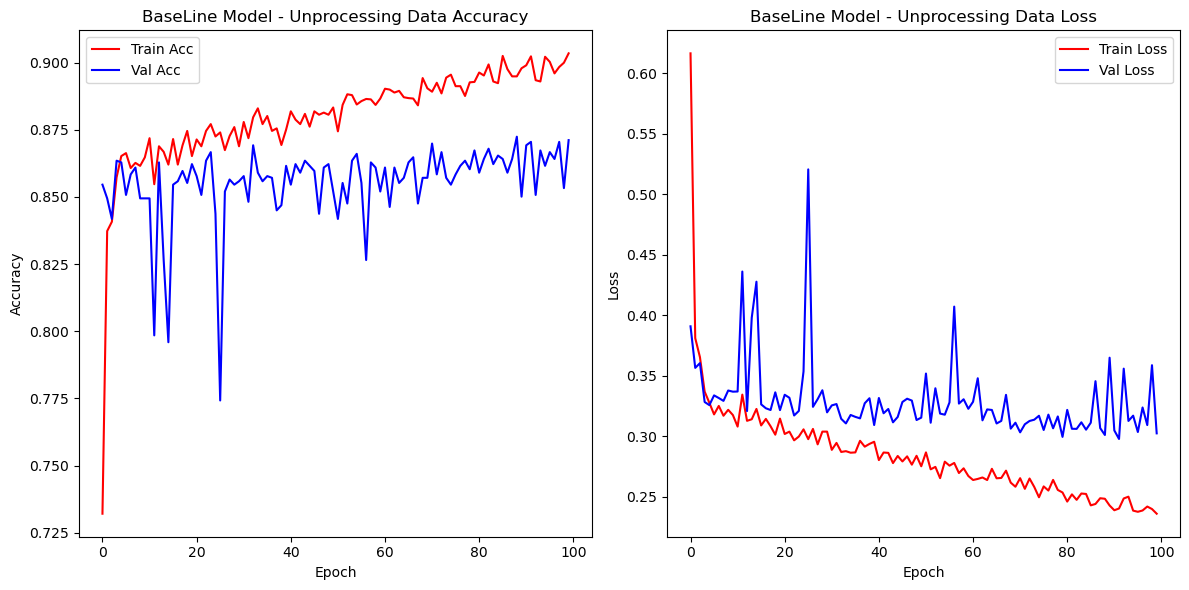

62/62 [==============================] - 2s 26ms/step
Precision: 0.85
Recall: 0.87
F1 Score: 0.86


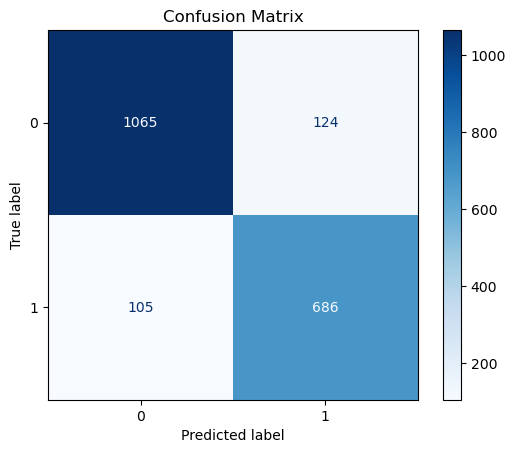

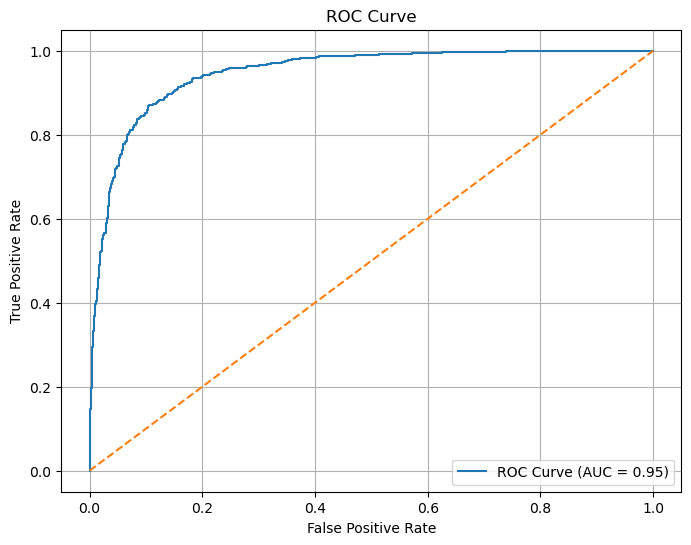

In [23]:
#Plot the training curve
plot_training_curves(histories)

true_labels = test_data_ic['isCancerous'].astype(int).values

# Use the generator to make predictions
predictions = isCancerous_baseline.predict(test_ds_ic, verbose=1).flatten()

predicted_labels = (predictions > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions

# Display precision, recall, and F1 score
display_binary_metrics(true_labels, predicted_labels)

# PLot confusion matrix
plot_confusion_matrix_binary(true_labels, predicted_labels)
# Plot ROC AUC
plot_roc_auc_binary(true_labels, predictions)

### III.1.2 Solution Model

In [24]:
l2_coeff = 0.01
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=3, min_lr=0.5e-15)
isCancerous_solution = tf.keras.models.Sequential([
    #First Block
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(27,27,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    #Second Block
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    #Third Block
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2, seed=42),
    #Fourth Block
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2, seed=42),
    #Output layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])
isCancerous_solution.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 25, 25, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                      

In [25]:
isCancerous_solution.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

In [32]:
histories = {}
epochs = 100
history_binary = isCancerous_solution.fit(
    us_train_ds_ic,
    steps_per_epoch=len(us_raw_train_data_ic) // batch_size,
    epochs=epochs,
    validation_data=val_ds_ic,
    validation_steps=len(val_data_ic) // batch_size,
    class_weight=class_weight_dict_ic
    , callbacks=[lr_reducer]
)
model_name = "Solution Model - Processing Data"
histories[model_name] = history_binary.history

Epoch 1/100
197/197 [==============================] - 24s 101ms/step - loss: 12.4041 - accuracy: 0.7916 - precision: 0.7157 - recall: 0.8294 - val_loss: 11.9345 - val_accuracy: 0.4101 - val_precision: 0.4101 - val_recall: 1.0000 - lr: 1.0000e-04
Epoch 2/100
197/197 [==============================] - 19s 94ms/step - loss: 10.5229 - accuracy: 0.8383 - precision: 0.7755 - recall: 0.8619 - val_loss: 9.9297 - val_accuracy: 0.6588 - val_precision: 0.5480 - val_recall: 0.9596 - lr: 1.0000e-04
Epoch 3/100
197/197 [==============================] - 15s 78ms/step - loss: 8.9682 - accuracy: 0.8454 - precision: 0.7881 - recall: 0.8591 - val_loss: 8.2230 - val_accuracy: 0.8788 - val_precision: 0.8259 - val_recall: 0.8927 - lr: 1.0000e-04
Epoch 4/100
197/197 [==============================] - 18s 92ms/step - loss: 7.6770 - accuracy: 0.8568 - precision: 0.8087 - recall: 0.8598 - val_loss: 7.0187 - val_accuracy: 0.8916 - val_precision: 0.8846 - val_recall: 0.8460 - lr: 1.0000e-04
Epoch 5/100
197/197 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



197/197 [==============================] - 19s 96ms/step - loss: 0.3500 - accuracy: 0.8959 - precision: 0.8660 - recall: 0.8871 - val_loss: 0.3359 - val_accuracy: 0.9152 - val_precision: 0.8696 - val_recall: 0.9331 - lr: 1.0000e-04
Epoch 36/100
197/197 [==============================] - 19s 95ms/step - loss: 0.3440 - accuracy: 0.8949 - precision: 0.8625 - recall: 0.8894 - val_loss: 0.2884 - val_accuracy: 0.9152 - val_precision: 0.8875 - val_recall: 0.9082 - lr: 1.0000e-04
Epoch 37/100
197/197 [==============================] - 18s 89ms/step - loss: 0.3385 - accuracy: 0.8960 - precision: 0.8652 - recall: 0.8899 - val_loss: 0.3444 - val_accuracy: 0.9050 - val_precision: 0.8412 - val_recall: 0.9471 - lr: 1.0000e-04
Epoch 38/100
197/197 [==============================] - 15s 75ms/step - loss: 0.3379 - accuracy: 0.8924 - precision: 0.8614 - recall: 0.8837 - val_loss: 0.2999 - val_accuracy: 0.9088 - val_precision: 0.8634 - val_recall: 0.9238 - lr: 1.0000e-04
Epoch 39/100
197/197 [===========

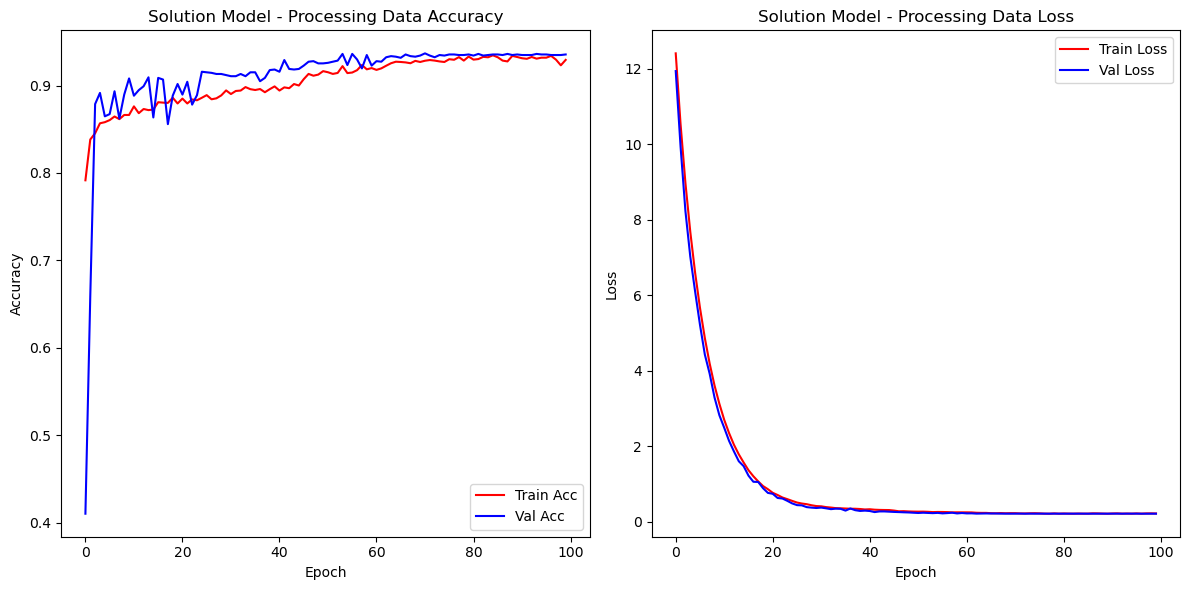

62/62 [==============================] - 1s 18ms/step
Precision: 0.92
Recall: 0.91
F1 Score: 0.91


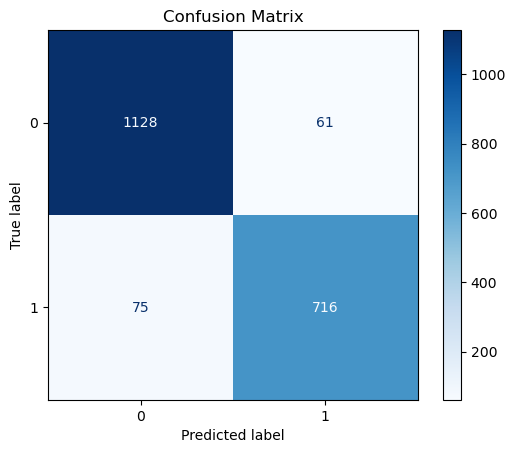

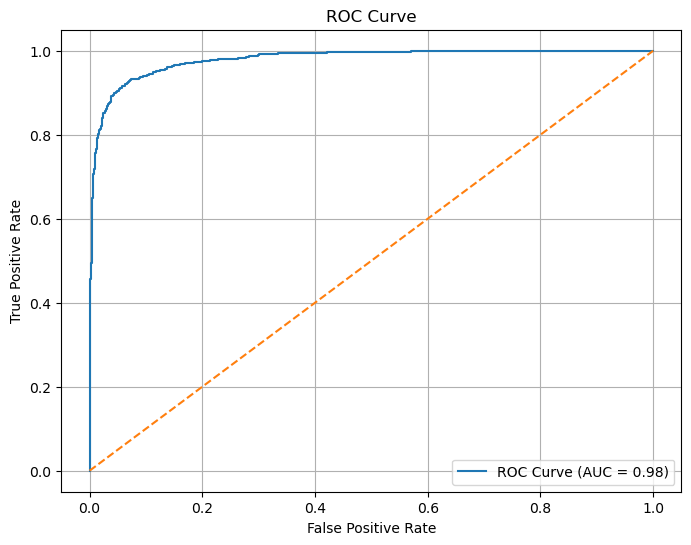

In [34]:
#Plot the training curve
plot_training_curves(histories)

true_labels = test_data_ic['isCancerous'].astype(int).values

# Use the generator to make predictions
predictions = isCancerous_solution.predict(test_ds_ic, verbose=1).flatten()

predicted_labels = (predictions > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions

# Display precision, recall, and F1 score
display_binary_metrics(true_labels, predicted_labels)

# PLot confusion matrix
plot_confusion_matrix_binary(true_labels, predicted_labels)
# Plot ROC AUC
plot_roc_auc_binary(true_labels, predictions)

### III.1.3 Observation
- For the baseline model, the model started to overfit after 30 epochs, and both training loss and accuracy are very fluctuating can be concluded that the models didn't perform well with the data set.
- For the solution model, after 60 epochs, the training process became more stablize, and the symtom of validation accuracy is a little higher than training accuracy can be explained by the consequence of augmentation application on the train data but not on test data, and since the augmentation combination is randomly chose, which might make the train data became significanly complicated than the validation data and affect the training accuracy. The value of all measurement metrics of this model on the test set is higher by around 6 percent compared to the baseline model.

## III.2. For 'CellType' target output
- **BaseLine Model**: For this target output, I have used the same baseline model structure of the binary classification, except for the output layer; Instead of `Sigmoid` activation function, `Softmax` function will be used since we are dealing with a multi-class classification problem, and the number of neurons in the output layer will be 4 as the number of cellt types. Beside that, I have used `categorical cross entropy (CCE)` as my loss function with the same reason there is a noticable point that for `Tensorflow` there are another type of loss function for multi-class problem which is `sparse categorical cross entropy (SCCE)`, the different between them is `CCE` is used for one hot encoding target feature and `SCCE` is used for label encoding target feature, so in this situation, `CCE` is more suitable since our target feature is one hot encoded (mentioned above). `Adam` with the default parameter value will still be the optimizer. 
  
- **Solution Model**: For this target output, I have used the same solution model structure with the binary classification along with other factors, with the same changes for the output layer and loss function.

I have trained these two models with a similar number of epochs and batch size as the binary classification problem. Still, for the solution model of this problem, I have changed the starting learning rate from 000.1 to 000.3 since it also helps to bring out the best outcome for part *III.2.4*.

### III.2.1 Baseline model
  - Baseline model with un-processed data

In [35]:
cellType_baseline = tf.keras.models.Sequential([
    tf.keras.Input(shape=(27, 27, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

cellType_baseline.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy',
                                                                                    tf.keras.metrics.Precision(name='precision'),
                                                                                    tf.keras.metrics.Recall(name='recall')])

cellType_baseline.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 2187)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               1120256   
                                                                 
 dense_6 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 1,122,308
Trainable params: 1,122,308
Non-trainable params: 0
_________________________________________________________________


In [36]:
histories = {}
epochs = 100
# For unprocessing data
history = cellType_baseline.fit(
        train_ds_ct,
        steps_per_epoch=len(train_data_ct)//batch_size,
        validation_data=val_ds_ct,
        validation_steps=len(val_data_ct)// batch_size,
        epochs=epochs
    )

model_name = "BaseLine Model - Unprocessing Data"
histories[model_name] = history.history

Epoch 1/100
197/197 [==============================] - 5s 24ms/step - loss: 1.2836 - accuracy: 0.5294 - precision: 0.6604 - recall: 0.3476 - val_loss: 0.9010 - val_accuracy: 0.6671 - val_precision: 0.8061 - val_recall: 0.4349
Epoch 2/100
197/197 [==============================] - 4s 19ms/step - loss: 0.9326 - accuracy: 0.6303 - precision: 0.7542 - recall: 0.4579 - val_loss: 0.8549 - val_accuracy: 0.6626 - val_precision: 0.7637 - val_recall: 0.5051
Epoch 3/100
197/197 [==============================] - 3s 15ms/step - loss: 0.8614 - accuracy: 0.6611 - precision: 0.7700 - recall: 0.5192 - val_loss: 0.8187 - val_accuracy: 0.6869 - val_precision: 0.7739 - val_recall: 0.5370
Epoch 4/100
197/197 [==============================] - 3s 16ms/step - loss: 0.8269 - accuracy: 0.6754 - precision: 0.7708 - recall: 0.5556 - val_loss: 0.8123 - val_accuracy: 0.6869 - val_precision: 0.7637 - val_recall: 0.5791
Epoch 5/100
197/197 [==============================] - 4s 22ms/step - loss: 0.8431 - accuracy: 0

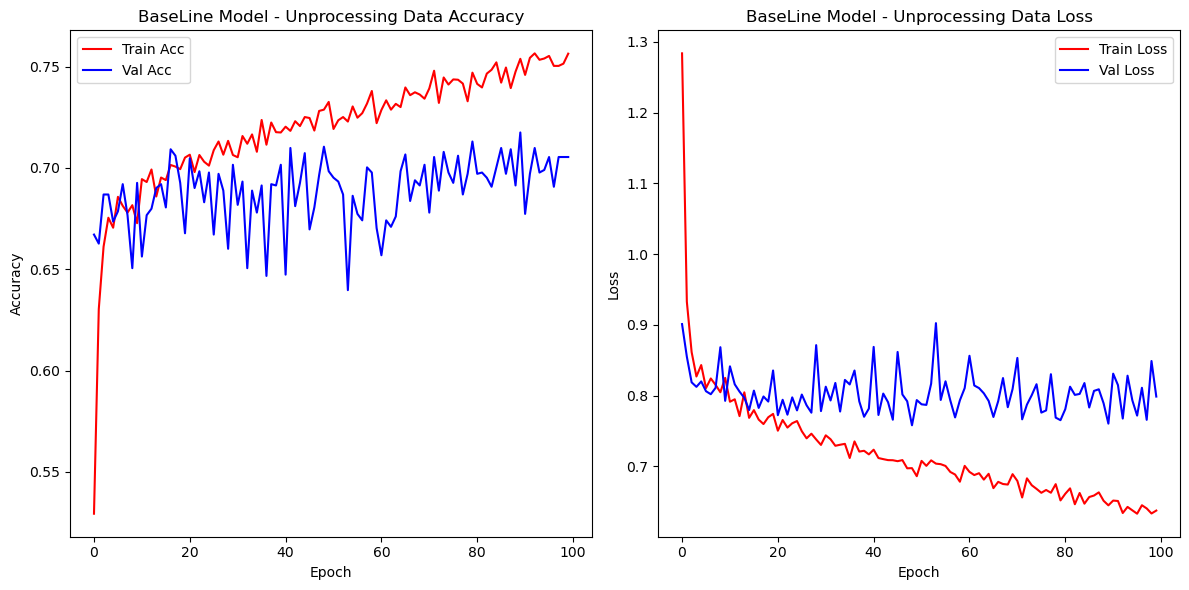

62/62 [==============================] - 1s 12ms/step
Precision (Macro Average): 0.65
Recall (Macro Average): 0.61
F1 Score (Macro Average): 0.60


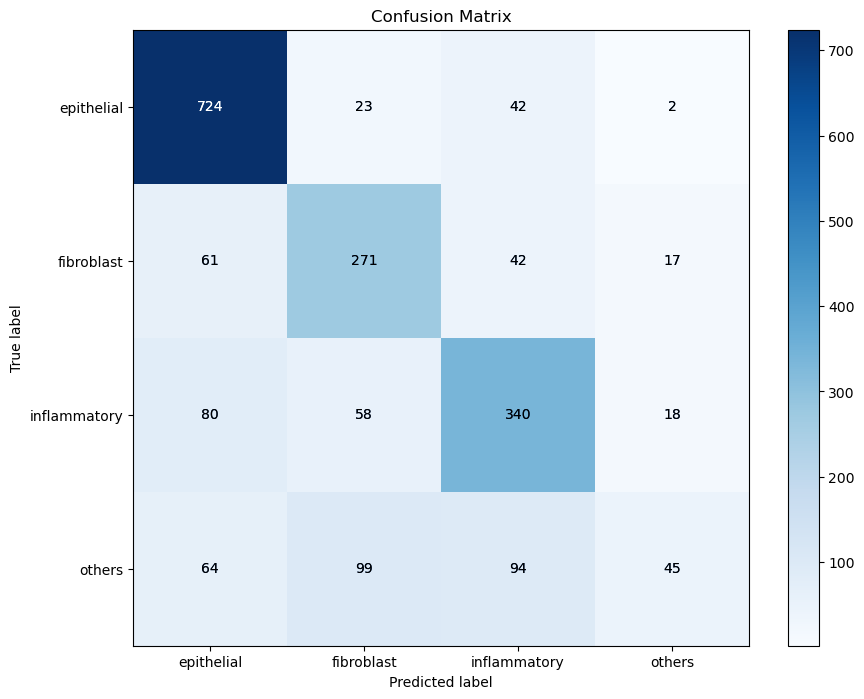

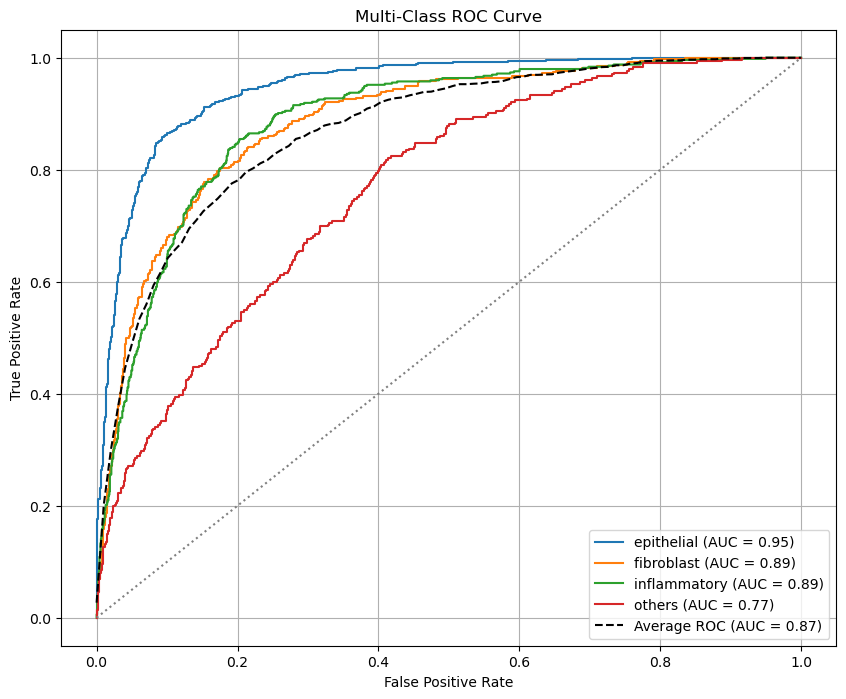

In [37]:
#Plot the training curve
plot_training_curves(histories)

# Get true labels from the generator
true_labels = np.concatenate([test_ds_ct[i][1] for i in range(len(test_ds_ct))])
true_labels_int = np.argmax(true_labels, axis=1)
class_names = list(test_ds_ct.class_indices.keys())

# Make prediction
pred_probabilities = cellType_baseline.predict(test_ds_ct)
pred_labels_int = np.argmax(pred_probabilities, axis=1)

# Display metrics
display_multiclass_metrics(true_labels_int,pred_labels_int)

#Plot confusion matrix
plot_confusion_matrix_multi_class(true_labels_int, pred_labels_int, class_names)

#Plot AUC ROC 
plot_multiclass_roc_auc(true_labels_int, pred_probabilities, class_names)

### III.2.2 Solution Model
- Explain what techniques did you use

In [17]:
l2_coeff = 0.01
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=3, min_lr=0.5e-15)
cellType_solution = tf.keras.models.Sequential([
    #First Block
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(27,27,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    #Second Block
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    #First Dense Layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2, seed=42),
    #Second Dense Layer
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2, seed=42),
    tf.keras.layers.Dense(4, activation='softmax')
])
cellType_solution.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 25, 25, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                        

In [19]:
cellType_solution.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
                     metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

In [30]:
histories = {}
epochs = 100
history_multiclass = cellType_solution.fit(
    us_train_ds_ct,
    steps_per_epoch=len(us_raw_train_data_ct) // batch_size,
    epochs=epochs,
    validation_data=val_ds_ct,
    validation_steps=len(val_data_ct) // batch_size,
    class_weight=class_weight_dict_ct
    , callbacks=[lr_reducer]
)
model_name = "Solution Model - Processing Data"

histories[model_name] = history_multiclass.history

Epoch 1/100
197/197 [==============================] - 13s 57ms/step - loss: 12.8490 - accuracy: 0.6176 - precision: 0.6481 - recall: 0.5784 - val_loss: 13.7225 - val_accuracy: 0.4101 - val_precision: 0.4101 - val_recall: 0.4101 - lr: 3.0000e-04
Epoch 2/100
197/197 [==============================] - 9s 46ms/step - loss: 10.4093 - accuracy: 0.6563 - precision: 0.6944 - recall: 0.6113 - val_loss: 10.2184 - val_accuracy: 0.4554 - val_precision: 0.4691 - val_recall: 0.4503 - lr: 3.0000e-04
Epoch 3/100
197/197 [==============================] - 11s 54ms/step - loss: 8.3018 - accuracy: 0.6811 - precision: 0.7229 - recall: 0.6349 - val_loss: 7.5247 - val_accuracy: 0.6097 - val_precision: 0.6423 - val_recall: 0.5612 - lr: 3.0000e-04
Epoch 4/100
197/197 [==============================] - 10s 48ms/step - loss: 6.5255 - accuracy: 0.6911 - precision: 0.7334 - recall: 0.6451 - val_loss: 5.6971 - val_accuracy: 0.6964 - val_precision: 0.7461 - val_recall: 0.6429 - lr: 3.0000e-04
Epoch 5/100
197/197 [

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



197/197 [==============================] - 10s 52ms/step - loss: 0.4918 - accuracy: 0.8462 - precision: 0.8757 - recall: 0.8073 - val_loss: 0.5659 - val_accuracy: 0.8144 - val_precision: 0.8411 - val_recall: 0.7902 - lr: 3.0000e-10
Epoch 74/100
197/197 [==============================] - 12s 60ms/step - loss: 0.4967 - accuracy: 0.8451 - precision: 0.8815 - recall: 0.8146 - val_loss: 0.5657 - val_accuracy: 0.8157 - val_precision: 0.8394 - val_recall: 0.7902 - lr: 3.0000e-10
Epoch 75/100
197/197 [==============================] - 11s 55ms/step - loss: 0.4971 - accuracy: 0.8486 - precision: 0.8767 - recall: 0.8140 - val_loss: 0.5656 - val_accuracy: 0.8144 - val_precision: 0.8408 - val_recall: 0.7883 - lr: 3.0000e-10
Epoch 76/100
197/197 [==============================] - 11s 55ms/step - loss: 0.4929 - accuracy: 0.8511 - precision: 0.8808 - recall: 0.8160 - val_loss: 0.5684 - val_accuracy: 0.8144 - val_precision: 0.8422 - val_recall: 0.7895 - lr: 9.4868e-11
Epoch 77/100
197/197 [===========

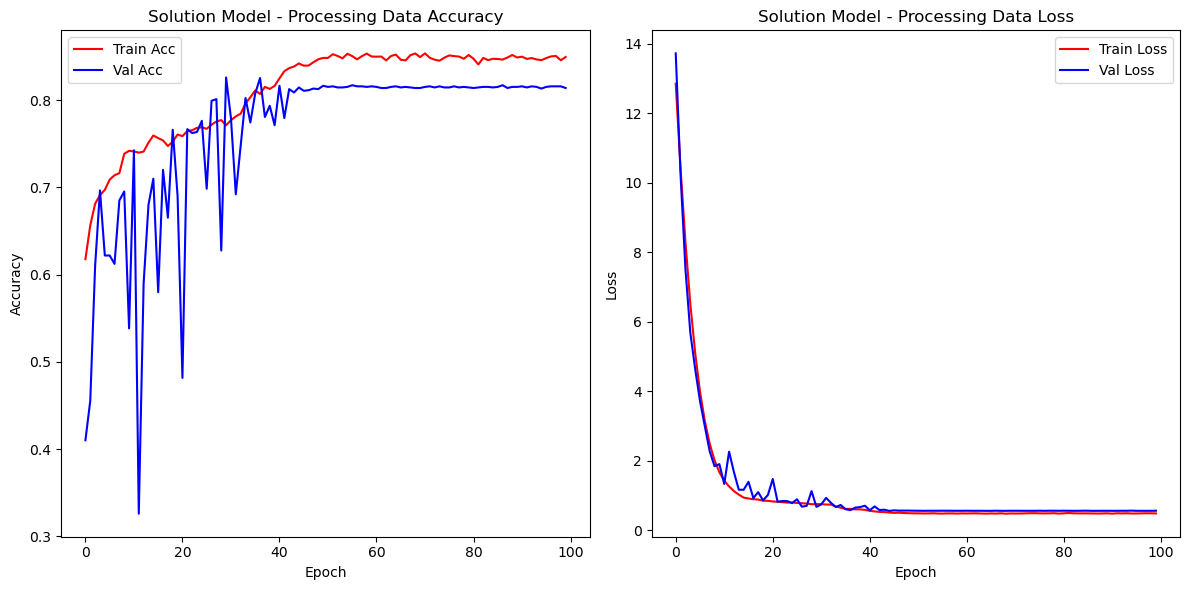

62/62 [==============================] - 2s 28ms/step
Precision (Macro Average): 0.78
Recall (Macro Average): 0.78
F1 Score (Macro Average): 0.78


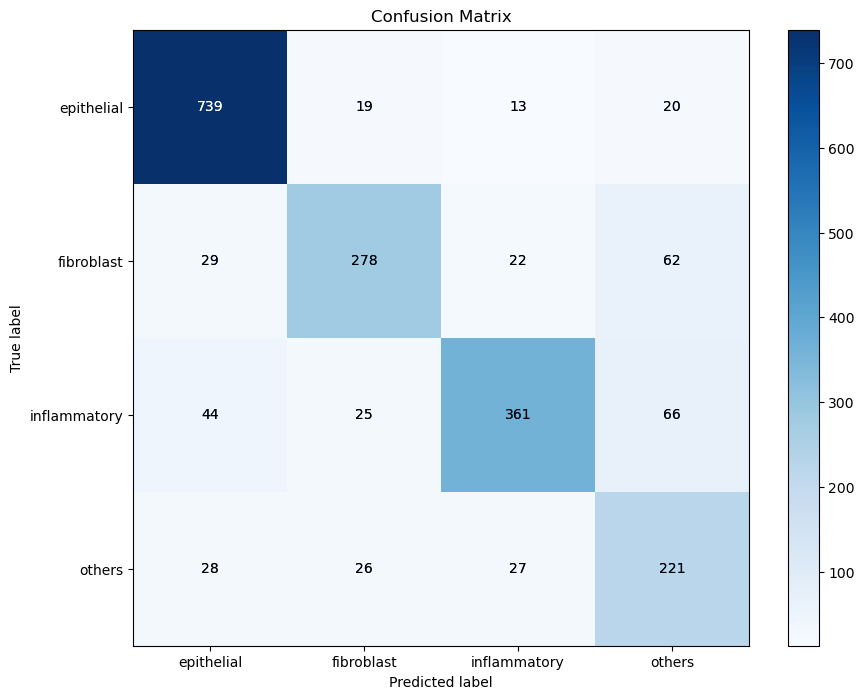

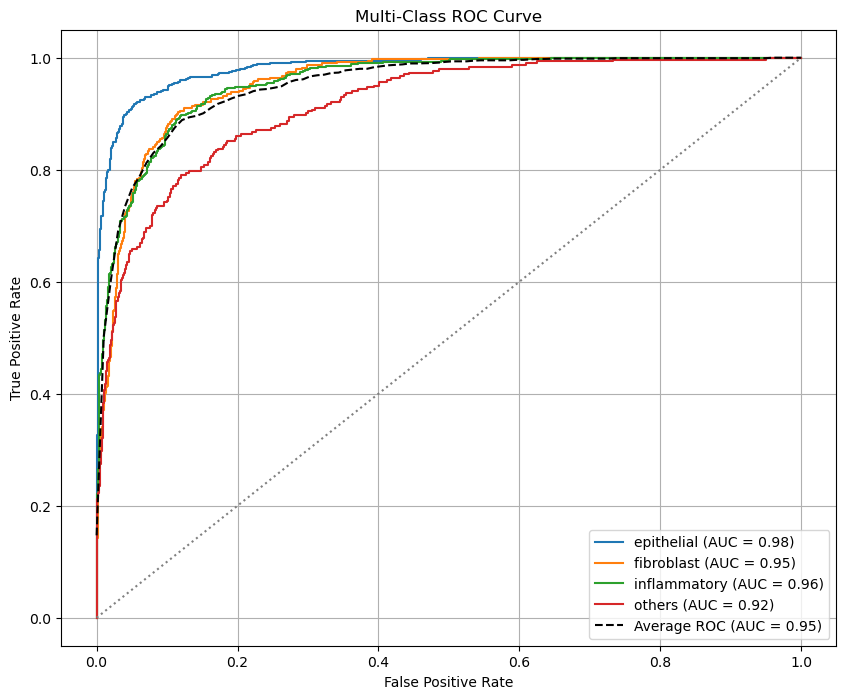

In [77]:
import json

#Convert to native Python types
#history_dict = {k: [float(v) for v in values] for k, values in history_multiclass.history.items()}

#with open('pre_fine_tuning_model_3NM_3DP_V_tune_augmentation.json', 'w') as f:
     #json.dump(history_dict, f)
histories = {}
with open('pre_fine_tuning_model_3NM_3DP_V_tune_augmentation.json', 'r') as f:
     loaded_history = json.load(f)

model_name = "Solution Model - Processing Data"

histories[model_name]= loaded_history

#Plot the training curve
plot_training_curves(histories)

# Get true labels from the generator
true_labels = np.concatenate([test_ds_ct[i][1] for i in range(len(test_ds_ct))])
true_labels_int = np.argmax(true_labels, axis=1)
class_names = list(test_ds_ct.class_indices.keys())

# Make prediction
pred_probabilities = cellType_solution.predict(test_ds_ct)
pred_labels_int = np.argmax(pred_probabilities, axis=1)

# Display metrics
display_multiclass_metrics(true_labels_int,pred_labels_int)

#Plot confusion matrix
plot_confusion_matrix_multi_class(true_labels_int, pred_labels_int, class_names)

#Plot AUC ROC 
plot_multiclass_roc_auc(true_labels_int, pred_probabilities, class_names)

# Save pre-fine-tuning model
#cellType_solution.save('pre_fine_tuning_model_3NM_3DP_V_tune_augmentation.h5')

### III.2.3 Observation
-  For the baseline model, the model started to be overfitting after 20 epochs, and the both training loss and accuracy are very fluctuated can be conclude that the models didn't perform well with the data set, the precision, recall and f1 scored on the test set are very low, only around 0.6, and the AUC score is significantly lower for the most minority class(others) compare to other 3 classes.
- For the solution model, after 40 epochs, the training process became more stable. The value of all measurement metrics of this model is higher by around 20% compared to the baseline model on the test set, with significant improvement in the AUC score of the most minority class (others).
- Compared to the original implementation of RCCNet *(Basha et al. 2018)*, my implementation achieves a similar F1Score value while the imbalance intensity in both implementations is different (our scenario is more serious), this might be explained by the effect of applying class weights and data augmentation techniques.

### III.2.4 (HD/DI) Leverage Unlabeled Data
After doing some research, I have come up with a solution to leverage the unlabeled data for further improvement of my model, which is using a semi-supervised learning method called `FlexMatch` algorithm *(Zhang et al. 2021)*, which is an upgraded version of `FixMatch` algorithm *(Sohn et al. 2020)*. The core concepts of these algorithms are:
- **Pseudo Labeling**: The model will use the prediction of its own on unlabeled data as a "fake" (pseudo) label to train itself. In both algorithms, this concept will be implemented by doing the following processes:
    - **Weak Augmentation**: The pseudo label for each sample will be created by making a prediction on that very simple augmented version of that sample, normally flipping or shifting.
    - **Strong Augmentation**: The same version of the sample will be applied strong augmentation methods to make it more complicated. In this case, I have used RandAugment of Imagaug library for a better experience, as mentioned in the `FixMatch` paper.
- **Consistency Loss**: This attribute measures the difference between the prediction of the model to a weak augmented version and the strong augmented version of the same sample. (which is cross-entropy loss because it is better for classification tasks, as mentioned in the paper)(formula 3rd in the Flexmatch paper)
- **Confident Threshold**: The pseudo label will only be chosen as the class if the prediction of the model on this class is higher than this value, otherwise, the sample will be skipped.

The key different between `FixMatch` and `FlexMatch` is the mechanism of controlling the confident threshold, for FixMatch, they have used a fix value of threshold for all class, but for `FlexMatch` the value of threeshold will be adjusted for each class based on how well the model perfomance on the class for each iteration (Curriculum Pseudo Labeling), well learned class will has higher threshold value and poorly learned class will have lower threshold value to gather more training sample, which might be more efficient in this scenario, where the data class distribution is imbalance (in training set and might happened in this unlabeled data also). The factor that `FlexMatch` uses to measure how well the model has learned on each class is called the learning effect, defined by the number of unlabeled samples that pass the threshold and are predicted as the class at the current time (formula 5th in the paper). The learning effect will be normalize by divide the learning effect of each class to the biggest learning effect, by this step, the learning effect of the most confident class will remain as 1, while the other poorly learned classese will has relative learning effect value (conceptually similar to min-max scaling) (formular 6th in the paper). The final threshold for each class will be calculated by multiplying the normalized learning effect by the original fixed predefined threshold (formula 7th in the paper). For each training step, these three calculations will be reproduced to update the threshold of each class dynamically.

For summarization, the `FlexMatch` algorithm will follow these steps:

- Calculating normal supervised loss on labeled data
- Calculating unsupervised loss for unlabeled data. For this step, the process will be:
    -  Make a model prediction on weak and strong augmented versions of the sample.
    -  Calculate the dynamic threshold for each class.
    -  Take the class with the highest probability value (p-value) of the weak prediction and create a pseudo label if the p-value is higher than the class threshold.
    -  Calculating consistency loss between pseudo-label value and strong prediction value.
- Calculate the final loss using both supervised loss and unsupervised loss (formula 9th in the paper).

There a noticeable point is that `FlexMatch` has a warmup mechanism which using the lower fixed threshold for first few epoch to avoid undertrained model might rejects too much sample and accepts incorrect pseudo-labels, but in this case, since I only want to train it for very few epochs to avoid ruining the pre-train model, and since the model has been trained with quite amound of labeled data with acceptable performance, I didn't implemented the warm up mechanism in this case.

For the drawbacks of this method, the biggest one is the configuration during the application process; the choice of hyperparameter values (such as the number of training epochs, augmentation parameters for both pre-training and current training process, or the parameters of the algorithms) will significantly affect the performance results or event break the pre-trained model. And since the parameter tuning solution for this scenario is very limited (due to the training time and hardware component capacity), I can only train the model repeatedly but individually, along with the observation and changing hyperparameter value every time I train the model, but didn't implement any automation mechanism for hyperparameter tuning.

For the implementation of this part, I have used some new hyperparameters:

- **Consistency Weight** `λ`: It controls the impact of unsupervised loss on the modal. A high λ will make the model learn faster on unlabeled data, but sensitive to noise; a low λ will give the model more resistance to noise but slower adaptation to unlabeled data.
- **Max Threshold**: This parameter is similar to the pre-fixed threshold in the `FixMatch` algorithm; the threshold value will never be passed this value.
- **Imagaug RandAugment** parameter: `n` is the number of augmentation options, and `m` is the magnitude of the augmentation, which controls how strong it is.
- **Number of classes**: Number of target feature class.

In [110]:
cellType_solution.load_weights('pre_fine_tuning_model_3NM_3DP_V_tune_augmentation.h5')

In [100]:
# Applying iaa RandomAugmentation class on ImageDataGenerator class
class RandAugmentGenerator(tf.keras.preprocessing.image.ImageDataGenerator):
    def __init__(self, n, m, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.rand_aug = iaa.RandAugment(n=n, m=m)

    def apply_transform(self, x, transform_parameters):
        x = tf.cast(x, tf.uint8)
        x_aug = self.rand_aug(image=x.numpy())
        x_aug = tf.cast(x_aug, tf.float32)
        return super().apply_transform(x_aug, transform_parameters)

# Define batch size for unlabeled data
# Because I want to use all labeled data and unlabeled data for each epoch
# Batch size for unlabel will be calculated as below
unlabeled_batch_size = len(extra_data_ct) // len(us_raw_train_data_ct) * batch_size

# Create Dummy label for unlabled data set
extra_data_ct["label"] = 0

# Weak augmentation
# In this case I have done only shiffting
unlabeled_datagen_weak = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True
)

unlabeled_generator_weak = unlabeled_datagen_weak.flow_from_dataframe(
    extra_data_ct,
    directory='./patch_images',
    x_col='ImageName',
    y_col='label',
    target_size=(27, 27),
    batch_size=unlabeled_batch_size,
    class_mode='raw',
    shuffle=False
)

# Strong Augmentation
# Augmentation setting for strong augmentation
unlabeled_datagen_strong = RandAugmentGenerator(
    n=3, m=3,
    rescale=1./255,
    fill_mode='nearest'
)

unlabeled_generator_strong = unlabeled_datagen_strong.flow_from_dataframe(
    extra_data_ct,
    directory='./patch_images',
    x_col='ImageName',
    y_col='label',
    target_size=(27, 27),
    batch_size=unlabeled_batch_size,
    class_mode='raw',
    shuffle=False
)

Found 10384 validated image filenames.
Found 10384 validated image filenames.


In [112]:
# --- Patch for deprecated np.bool ---
if not hasattr(np, 'bool'):
    np.bool = bool
# --- Hyperparameters ---
NUM_CLASSES = 4
MAX_THRESHOLD = 0.95
CONSISTENCY_WEIGHT = 0.7
EPOCH_NUM = 4
# --- Global Dictionary: Stores how many confident predictions per class ---
# Initialized to 1 to avoid division by zero during early normalization
class_positive_counts = {i: 1 for i in range(NUM_CLASSES)}

# Update count of confident pseudo-labels for each class
def update_class_positive_counts(pseudo_class, max_probs, base_threshold):
    global class_positive_counts
    for i in range(NUM_CLASSES):
        # Match samples that are pseudo-labeled as class i and have confidence > threshold
        match = tf.logical_and(tf.equal(pseudo_class, i), max_probs > base_threshold)
        # Accumulate the number of such confident predictions for class i
        class_positive_counts[i] += tf.reduce_sum(tf.cast(match, tf.int32)).numpy()

# Compute per-class dynamic thresholds
def get_dynamic_thresholds(base_threshold):
    # Get max confident count across all classes (used to normalize)
    max_count = max(class_positive_counts.values()) + 1e-8  # epsilon for numerical stability

    # Compute normalized learning effect (from FlexMatch formula 5th + 6th)
    class_learning_effect = {i: class_positive_counts[i] / max_count for i in range(NUM_CLASSES)}

    # Compute per-class thresholds (from FlexMatch formula 7th)
    dynamic_thresholds = [base_threshold * class_learning_effect[i] for i in range(NUM_CLASSES)]

    return tf.constant(dynamic_thresholds, dtype=tf.float32)

# Main FlexMatch Training Step
def flexmatch_step(x_labeled, y_labeled, x_unlabeled, model, optimizer, base_threshold,
                   training=True, class_weight_dict=None, consistency_weight=1.0):
    # Use categorical crossentropy loss (softmax outputs, not logits)
    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

    with tf.GradientTape() as tape:
        # Supervised Forward Pass
        preds_labeled = model(x_labeled, training=True)

        # Apply class weights to supervised loss
        if class_weight_dict is not None:
            y_labels_indices = tf.argmax(y_labeled, axis=1)
            sample_weights = tf.gather([class_weight_dict[i] for i in range(len(class_weight_dict))], y_labels_indices)
            supervised_loss = tf.reduce_mean(loss_fn(y_labeled, preds_labeled, sample_weight=sample_weights))
        else:
            supervised_loss = tf.reduce_mean(loss_fn(y_labeled, preds_labeled))

        # Initialize final loss and consistency loss
        final_loss = supervised_loss
        consistency_loss = tf.constant(0.0)

        # Unsupervised Consistency Loss Using Pseudo-Labels 
        if x_unlabeled is not None:
            # Make predicted on weak and strong augmentation sample
            weak_inputs, strong_inputs = x_unlabeled
            weak_preds = model(weak_inputs)
            strong_preds = model(strong_inputs)

            # Get pseudo-labels (argmax) and confidence (max prob) from weakly augmented inputs
            pseudo_class = tf.argmax(weak_preds, axis=-1)
            max_probs = tf.reduce_max(weak_preds, axis=-1)

            # Update class-level confidence counters 
            update_class_positive_counts(pseudo_class, max_probs, base_threshold)

            # Get per-class dynamic threshold 
            dynamic_thresholds = get_dynamic_thresholds_original(base_threshold)

            # Get threshold per sample by indexing via pseudo-label class
            thresholds_for_samples = tf.gather(dynamic_thresholds, pseudo_class)

            # Create mask for confident pseudo-labels (only those used for training)
            mask = max_probs > thresholds_for_samples

            # Convert pseudo-labels to one-hot encoding for loss computation
            pseudo_labels_hard = tf.one_hot(pseudo_class, depth=tf.shape(weak_preds)[-1])

            # Compute per-sample consistency loss
            per_example_loss = tf.keras.losses.categorical_crossentropy(pseudo_labels_hard, strong_preds)

            # Only include loss from samples that passed the confidence threshold
            # The epsilon function is used to create extremly small value in order to avoid the situation when mask = 0
            # Which will crash the the algorithm
            masked_loss = tf.reduce_sum(per_example_loss * tf.cast(mask, per_example_loss.dtype)) / \
                          (tf.reduce_sum(tf.cast(mask, tf.float32)) + tf.keras.backend.epsilon())

            # Weight the consistency loss
            consistency_loss = consistency_weight * masked_loss

            # Add to total loss
            final_loss += consistency_loss

        # Accuracy Metric for Supervised Labeled Data ---
        accuracy = tf.keras.metrics.CategoricalAccuracy()
        accuracy.update_state(y_labeled, preds_labeled)

        # Backward Pass and Optimizer Step ---
        if training:
            grads = tape.gradient(final_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Return Logging Metrics 
    return {
        "loss": final_loss,
        "supervised_loss": supervised_loss,
        "consistency_loss": consistency_loss,
        "accuracy": accuracy.result()
    }


# Train FlexMatch 
def train_flexmatch(model, optimizer,
                    labeled_gen, unlabeled_weak_gen, unlabeled_strong_gen,
                    val_gen, epochs, batch_size, class_weight_dict=None, consistency_weight=1.0):

    min_val_loss = np.inf
    history = {"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": []}

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs} - MAX_THRESHOLD: {MAX_THRESHOLD:.4f}")

        total_loss = 0
        total_supervised_loss = 0
        total_consistency_loss = 0
        total_accuracy = 0
        steps = 0

        # Calculating total batch
        total_batches = math.ceil(len(labeled_gen.filenames) / batch_size)
        progress_bar = tqdm(total=total_batches, desc="Training", ncols=100)

        # Apply FlexMatch step
        for (x_batch, y_batch), (x_unlabeled_weak, _), (x_unlabeled_strong, _) in zip(labeled_gen, unlabeled_weak_gen, unlabeled_strong_gen):
            result = flexmatch_step(x_batch, y_batch,
                                    (x_unlabeled_weak, x_unlabeled_strong),
                                    model, optimizer,
                                    base_threshold=MAX_THRESHOLD,
                                    class_weight_dict=class_weight_dict,
                                    consistency_weight=consistency_weight)

            total_loss += result["loss"]
            total_supervised_loss += result["supervised_loss"]
            total_consistency_loss += result["consistency_loss"]
            total_accuracy += result["accuracy"]
            # Print measurement metric for each step 
            print(f"Batch {steps}: loss = {result['loss'].numpy():.4f}, supervised_loss = {result['supervised_loss'].numpy():.4f}, consistency_loss = {result['consistency_loss'].numpy():.4f}, acc = {result['accuracy'].numpy():.4f}")
            steps += 1
            # Stop if number of step is higher then max step
            progress_bar.update(1)
            if steps * batch_size >= len(labeled_gen.filenames):
                break
        progress_bar.close()

        avg_loss = total_loss / steps
        avg_supervised_loss = total_supervised_loss / steps
        avg_consistency_loss = total_consistency_loss / steps
        avg_accuracy = total_accuracy / steps
        # Print average measurment metrics for the epoch
        print(f"Train - loss: {avg_loss.numpy():.4f}, supervised: {avg_supervised_loss.numpy():.4f}, consistency: {avg_consistency_loss.numpy():.4f}, acc: {avg_accuracy.numpy():.4f}")

        # Validation
        val_loss = 0
        val_acc = 0
        val_steps = 0
        for x_val_batch, y_val_batch in val_gen:
            result = flexmatch_step(x_val_batch, y_val_batch,
                                    None, model, optimizer,
                                    base_threshold=MAX_THRESHOLD,
                                    training=False,
                                    class_weight_dict=class_weight_dict)

            val_loss += result["loss"]
            val_acc += result["accuracy"]
            val_steps += 1
            if val_steps * batch_size >= len(val_gen.filenames):
                break

        avg_val_loss = val_loss / val_steps
        avg_val_accuracy = val_acc / val_steps
        # Print validation metrics 
        print(f"Validation - loss: {avg_val_loss.numpy():.4f}, acc: {avg_val_accuracy.numpy():.4f}")

        history["loss"].append(avg_loss.numpy())
        history["val_loss"].append(avg_val_loss.numpy())
        history["accuracy"].append(avg_accuracy.numpy())
        history["val_accuracy"].append(avg_val_accuracy.numpy())

        # Learning rate decay if val loss goes up
        if avg_val_loss < min_val_loss:
            min_val_loss = avg_val_loss
        else:
            new_lr = max(optimizer.learning_rate.numpy() * np.sqrt(0.1), 0.5e-15)
            optimizer.learning_rate.assign(new_lr)
            print(f" Learning rate decayed to {new_lr:.2e}")

    return history

In [114]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-8)
history = train_flexmatch(cellType_solution, 
                         labeled_gen=us_train_ds_ct, 
                         unlabeled_weak_gen=unlabeled_generator_weak, 
                         unlabeled_strong_gen=unlabeled_generator_strong, 
                         val_gen=val_ds_ct, 
                         optimizer=optimizer,
                         epochs=EPOCH_NUM,
                         batch_size=batch_size,
                         class_weight_dict=class_weight_dict_ct,
                         consistency_weight=CONSISTENCY_WEIGHT)


Epoch 1/4 - MAX_THRESHOLD: 0.9500


Training:   1%|▎                                                    | 1/198 [00:00<01:58,  1.66it/s]

Batch 0: loss = 3.9031, supervised_loss = 0.2933, consistency_loss = 3.6097, acc = 0.8438


Training:   1%|▌                                                    | 2/198 [00:01<01:52,  1.74it/s]

Batch 1: loss = 4.1002, supervised_loss = 0.4586, consistency_loss = 3.6416, acc = 0.8125


Training:   2%|▊                                                    | 3/198 [00:01<01:48,  1.79it/s]

Batch 2: loss = 3.5147, supervised_loss = 0.5487, consistency_loss = 2.9659, acc = 0.7500


Training:   2%|█                                                    | 4/198 [00:02<01:46,  1.83it/s]

Batch 3: loss = 4.3768, supervised_loss = 0.5925, consistency_loss = 3.7843, acc = 0.7500


Training:   3%|█▎                                                   | 5/198 [00:02<01:42,  1.89it/s]

Batch 4: loss = 4.1247, supervised_loss = 0.2489, consistency_loss = 3.8758, acc = 0.8750


Training:   3%|█▌                                                   | 6/198 [00:03<01:39,  1.94it/s]

Batch 5: loss = 3.4606, supervised_loss = 0.3498, consistency_loss = 3.1108, acc = 0.8438


Training:   4%|█▊                                                   | 7/198 [00:03<01:36,  1.98it/s]

Batch 6: loss = 6.1841, supervised_loss = 0.3195, consistency_loss = 5.8646, acc = 0.8438


Training:   4%|██▏                                                  | 8/198 [00:04<01:30,  2.10it/s]

Batch 7: loss = 5.6868, supervised_loss = 0.4124, consistency_loss = 5.2744, acc = 0.7812


Training:   5%|██▍                                                  | 9/198 [00:04<01:28,  2.12it/s]

Batch 8: loss = 4.0072, supervised_loss = 0.3432, consistency_loss = 3.6641, acc = 0.8750


Training:   5%|██▋                                                 | 10/198 [00:05<01:33,  2.00it/s]

Batch 9: loss = 2.8435, supervised_loss = 0.4291, consistency_loss = 2.4145, acc = 0.8125


Training:   6%|██▉                                                 | 11/198 [00:05<01:38,  1.90it/s]

Batch 10: loss = 2.8780, supervised_loss = 0.3897, consistency_loss = 2.4883, acc = 0.8438


Training:   6%|███▏                                                | 12/198 [00:06<01:43,  1.80it/s]

Batch 11: loss = 2.5981, supervised_loss = 0.5188, consistency_loss = 2.0793, acc = 0.7500


Training:   7%|███▍                                                | 13/198 [00:06<01:44,  1.77it/s]

Batch 12: loss = 3.5829, supervised_loss = 0.4940, consistency_loss = 3.0889, acc = 0.8125


Training:   7%|███▋                                                | 14/198 [00:07<01:41,  1.81it/s]

Batch 13: loss = 2.0599, supervised_loss = 0.4081, consistency_loss = 1.6518, acc = 0.8125


Training:   8%|███▉                                                | 15/198 [00:07<01:34,  1.93it/s]

Batch 14: loss = 1.8540, supervised_loss = 0.2561, consistency_loss = 1.5979, acc = 0.9062


Training:   8%|████▏                                               | 16/198 [00:08<01:33,  1.95it/s]

Batch 15: loss = 1.1169, supervised_loss = 0.4742, consistency_loss = 0.6427, acc = 0.7500


Training:   9%|████▍                                               | 17/198 [00:08<01:31,  1.98it/s]

Batch 16: loss = 2.3194, supervised_loss = 0.3605, consistency_loss = 1.9589, acc = 0.8438


Training:   9%|████▋                                               | 18/198 [00:09<01:28,  2.03it/s]

Batch 17: loss = 0.8951, supervised_loss = 0.2466, consistency_loss = 0.6485, acc = 0.9688


Training:  10%|████▉                                               | 19/198 [00:09<01:29,  1.99it/s]

Batch 18: loss = 0.9821, supervised_loss = 0.1539, consistency_loss = 0.8282, acc = 1.0000


Training:  10%|█████▎                                              | 20/198 [00:10<01:34,  1.87it/s]

Batch 19: loss = 1.6546, supervised_loss = 0.1681, consistency_loss = 1.4864, acc = 0.9688


Training:  11%|█████▌                                              | 21/198 [00:11<01:36,  1.84it/s]

Batch 20: loss = 2.6362, supervised_loss = 0.6112, consistency_loss = 2.0251, acc = 0.7500


Training:  11%|█████▊                                              | 22/198 [00:11<01:34,  1.86it/s]

Batch 21: loss = 3.6580, supervised_loss = 0.3237, consistency_loss = 3.3342, acc = 0.9375


Training:  12%|██████                                              | 23/198 [00:12<01:36,  1.82it/s]

Batch 22: loss = 0.7829, supervised_loss = 0.1717, consistency_loss = 0.6112, acc = 0.9375


Training:  12%|██████▎                                             | 24/198 [00:12<01:30,  1.92it/s]

Batch 23: loss = 5.8127, supervised_loss = 0.4147, consistency_loss = 5.3981, acc = 0.7812


Training:  13%|██████▌                                             | 25/198 [00:13<01:26,  2.01it/s]

Batch 24: loss = 2.7564, supervised_loss = 0.4096, consistency_loss = 2.3468, acc = 0.8125


Training:  13%|██████▊                                             | 26/198 [00:13<01:25,  2.02it/s]

Batch 25: loss = 5.1421, supervised_loss = 0.3958, consistency_loss = 4.7464, acc = 0.9062


Training:  14%|███████                                             | 27/198 [00:14<01:24,  2.02it/s]

Batch 26: loss = 6.0347, supervised_loss = 0.3729, consistency_loss = 5.6618, acc = 0.8125


Training:  14%|███████▎                                            | 28/198 [00:14<01:24,  2.02it/s]

Batch 27: loss = 4.0148, supervised_loss = 0.3806, consistency_loss = 3.6342, acc = 0.9062


Training:  15%|███████▌                                            | 29/198 [00:15<01:24,  2.00it/s]

Batch 28: loss = 2.3611, supervised_loss = 0.4526, consistency_loss = 1.9086, acc = 0.8125


Training:  15%|███████▉                                            | 30/198 [00:15<01:28,  1.90it/s]

Batch 29: loss = 2.0255, supervised_loss = 0.1820, consistency_loss = 1.8435, acc = 0.9688


Training:  16%|████████▏                                           | 31/198 [00:16<01:26,  1.94it/s]

Batch 30: loss = 3.2982, supervised_loss = 0.3164, consistency_loss = 2.9818, acc = 0.8438


Training:  16%|████████▍                                           | 32/198 [00:16<01:30,  1.83it/s]

Batch 31: loss = 2.7514, supervised_loss = 0.3662, consistency_loss = 2.3852, acc = 0.8750


Training:  17%|████████▋                                           | 33/198 [00:17<01:35,  1.73it/s]

Batch 32: loss = 2.4147, supervised_loss = 0.6345, consistency_loss = 1.7801, acc = 0.7812


Training:  17%|████████▉                                           | 34/198 [00:17<01:28,  1.85it/s]

Batch 33: loss = 1.0631, supervised_loss = 0.3803, consistency_loss = 0.6828, acc = 0.8438


Training:  18%|█████████▏                                          | 35/198 [00:18<01:27,  1.87it/s]

Batch 34: loss = 2.9468, supervised_loss = 0.3896, consistency_loss = 2.5572, acc = 0.8750


Training:  18%|█████████▍                                          | 36/198 [00:18<01:25,  1.90it/s]

Batch 35: loss = 3.0064, supervised_loss = 0.4082, consistency_loss = 2.5982, acc = 0.8438


Training:  19%|█████████▋                                          | 37/198 [00:19<01:21,  1.98it/s]

Batch 36: loss = 2.9189, supervised_loss = 0.5804, consistency_loss = 2.3385, acc = 0.8125


Training:  19%|█████████▉                                          | 38/198 [00:19<01:24,  1.90it/s]

Batch 37: loss = 2.2632, supervised_loss = 0.2021, consistency_loss = 2.0611, acc = 0.9688


Training:  20%|██████████▏                                         | 39/198 [00:20<01:25,  1.86it/s]

Batch 38: loss = 1.8324, supervised_loss = 0.4730, consistency_loss = 1.3594, acc = 0.8438


Training:  20%|██████████▌                                         | 40/198 [00:21<01:28,  1.78it/s]

Batch 39: loss = 2.7510, supervised_loss = 0.3613, consistency_loss = 2.3896, acc = 0.8750


Training:  21%|██████████▊                                         | 41/198 [00:21<01:34,  1.66it/s]

Batch 40: loss = 1.5045, supervised_loss = 0.4381, consistency_loss = 1.0665, acc = 0.9062


Training:  21%|███████████                                         | 42/198 [00:22<01:31,  1.70it/s]

Batch 41: loss = 2.7598, supervised_loss = 0.3182, consistency_loss = 2.4417, acc = 0.8125


Training:  22%|███████████▎                                        | 43/198 [00:22<01:31,  1.70it/s]

Batch 42: loss = 3.3693, supervised_loss = 0.2621, consistency_loss = 3.1072, acc = 0.9375


Training:  22%|███████████▌                                        | 44/198 [00:23<01:27,  1.75it/s]

Batch 43: loss = 3.0111, supervised_loss = 0.3734, consistency_loss = 2.6377, acc = 0.8125


Training:  23%|███████████▊                                        | 45/198 [00:23<01:23,  1.83it/s]

Batch 44: loss = 1.9400, supervised_loss = 0.6487, consistency_loss = 1.2913, acc = 0.7812


Training:  23%|████████████                                        | 46/198 [00:24<01:22,  1.85it/s]

Batch 45: loss = 1.7250, supervised_loss = 0.2868, consistency_loss = 1.4381, acc = 0.9062


Training:  24%|████████████▎                                       | 47/198 [00:25<01:22,  1.84it/s]

Batch 46: loss = 2.7714, supervised_loss = 0.5355, consistency_loss = 2.2359, acc = 0.8438


Training:  24%|████████████▌                                       | 48/198 [00:25<01:22,  1.82it/s]

Batch 47: loss = 2.0031, supervised_loss = 0.4380, consistency_loss = 1.5651, acc = 0.8750


Training:  25%|████████████▊                                       | 49/198 [00:26<01:22,  1.81it/s]

Batch 48: loss = 0.9034, supervised_loss = 0.3037, consistency_loss = 0.5997, acc = 0.8750


Training:  25%|█████████████▏                                      | 50/198 [00:26<01:20,  1.84it/s]

Batch 49: loss = 1.6887, supervised_loss = 0.6638, consistency_loss = 1.0249, acc = 0.8125


Training:  26%|█████████████▍                                      | 51/198 [00:27<01:20,  1.83it/s]

Batch 50: loss = 2.3858, supervised_loss = 0.8149, consistency_loss = 1.5710, acc = 0.6250


Training:  26%|█████████████▋                                      | 52/198 [00:27<01:17,  1.89it/s]

Batch 51: loss = 2.3049, supervised_loss = 0.3808, consistency_loss = 1.9241, acc = 0.7812


Training:  27%|█████████████▉                                      | 53/198 [00:28<01:15,  1.93it/s]

Batch 52: loss = 1.7279, supervised_loss = 0.3414, consistency_loss = 1.3865, acc = 0.8438


Training:  27%|██████████████▏                                     | 54/198 [00:28<01:13,  1.97it/s]

Batch 53: loss = 4.6574, supervised_loss = 0.6646, consistency_loss = 3.9928, acc = 0.7812


Training:  28%|██████████████▍                                     | 55/198 [00:29<01:10,  2.03it/s]

Batch 54: loss = 3.4100, supervised_loss = 0.1720, consistency_loss = 3.2380, acc = 0.9062


Training:  28%|██████████████▋                                     | 56/198 [00:29<01:03,  2.22it/s]

Batch 55: loss = 2.5911, supervised_loss = 0.2258, consistency_loss = 2.3654, acc = 0.9375


Training:  29%|██████████████▉                                     | 57/198 [00:30<01:06,  2.13it/s]

Batch 56: loss = 3.9850, supervised_loss = 0.2301, consistency_loss = 3.7548, acc = 0.8750


Training:  29%|███████████████▏                                    | 58/198 [00:30<01:10,  2.00it/s]

Batch 57: loss = 4.6573, supervised_loss = 0.1489, consistency_loss = 4.5084, acc = 0.9688


Training:  30%|███████████████▍                                    | 59/198 [00:31<01:12,  1.93it/s]

Batch 58: loss = 6.0194, supervised_loss = 0.5325, consistency_loss = 5.4869, acc = 0.8125


Training:  30%|███████████████▊                                    | 60/198 [00:31<01:13,  1.88it/s]

Batch 59: loss = 4.3790, supervised_loss = 0.1905, consistency_loss = 4.1885, acc = 0.9375


Training:  31%|████████████████                                    | 61/198 [00:32<01:13,  1.87it/s]

Batch 60: loss = 4.4649, supervised_loss = 0.3784, consistency_loss = 4.0864, acc = 0.9062


Training:  31%|████████████████▎                                   | 62/198 [00:32<01:09,  1.95it/s]

Batch 61: loss = 2.7213, supervised_loss = 0.3769, consistency_loss = 2.3444, acc = 0.8438


Training:  32%|████████████████▌                                   | 63/198 [00:33<01:09,  1.94it/s]

Batch 62: loss = 3.6846, supervised_loss = 1.0825, consistency_loss = 2.6021, acc = 0.6875


Training:  32%|████████████████▊                                   | 64/198 [00:33<01:08,  1.95it/s]

Batch 63: loss = 1.8972, supervised_loss = 0.3091, consistency_loss = 1.5881, acc = 0.9062


Training:  33%|█████████████████                                   | 65/198 [00:34<01:05,  2.03it/s]

Batch 64: loss = 1.6234, supervised_loss = 0.4406, consistency_loss = 1.1827, acc = 0.8125


Training:  33%|█████████████████▎                                  | 66/198 [00:34<01:04,  2.06it/s]

Batch 65: loss = 1.3911, supervised_loss = 0.4786, consistency_loss = 0.9125, acc = 0.8438


Training:  34%|█████████████████▌                                  | 67/198 [00:35<01:08,  1.92it/s]

Batch 66: loss = 1.8858, supervised_loss = 0.4091, consistency_loss = 1.4767, acc = 0.8438


Training:  34%|█████████████████▊                                  | 68/198 [00:35<01:09,  1.87it/s]

Batch 67: loss = 5.9415, supervised_loss = 0.8783, consistency_loss = 5.0632, acc = 0.8125


Training:  35%|██████████████████                                  | 69/198 [00:36<01:13,  1.77it/s]

Batch 68: loss = 4.3961, supervised_loss = 0.1691, consistency_loss = 4.2270, acc = 0.9375


Training:  35%|██████████████████▍                                 | 70/198 [00:37<01:12,  1.77it/s]

Batch 69: loss = 5.0967, supervised_loss = 0.2296, consistency_loss = 4.8671, acc = 0.8750


Training:  36%|██████████████████▋                                 | 71/198 [00:37<01:08,  1.86it/s]

Batch 70: loss = 6.5836, supervised_loss = 0.4417, consistency_loss = 6.1419, acc = 0.8438


Training:  36%|██████████████████▉                                 | 72/198 [00:38<01:08,  1.84it/s]

Batch 71: loss = 6.5263, supervised_loss = 0.4784, consistency_loss = 6.0479, acc = 0.9062


Training:  37%|███████████████████▏                                | 73/198 [00:38<01:05,  1.90it/s]

Batch 72: loss = 6.3476, supervised_loss = 0.2688, consistency_loss = 6.0787, acc = 0.8750


Training:  37%|███████████████████▍                                | 74/198 [00:39<01:04,  1.93it/s]

Batch 73: loss = 6.6512, supervised_loss = 0.3452, consistency_loss = 6.3061, acc = 0.9062


Training:  38%|███████████████████▋                                | 75/198 [00:39<01:02,  1.98it/s]

Batch 74: loss = 5.9217, supervised_loss = 0.6617, consistency_loss = 5.2600, acc = 0.7812


Training:  38%|███████████████████▉                                | 76/198 [00:40<01:02,  1.94it/s]

Batch 75: loss = 6.9122, supervised_loss = 0.3249, consistency_loss = 6.5873, acc = 0.8750


Training:  39%|████████████████████▏                               | 77/198 [00:40<01:02,  1.93it/s]

Batch 76: loss = 7.8553, supervised_loss = 0.4481, consistency_loss = 7.4072, acc = 0.8438


Training:  39%|████████████████████▍                               | 78/198 [00:41<01:05,  1.82it/s]

Batch 77: loss = 5.1453, supervised_loss = 0.2304, consistency_loss = 4.9150, acc = 0.9062


Training:  40%|████████████████████▋                               | 79/198 [00:41<01:05,  1.82it/s]

Batch 78: loss = 7.8418, supervised_loss = 0.4828, consistency_loss = 7.3590, acc = 0.7812


Training:  40%|█████████████████████                               | 80/198 [00:42<01:05,  1.81it/s]

Batch 79: loss = 7.5081, supervised_loss = 0.3506, consistency_loss = 7.1575, acc = 0.8438


Training:  41%|█████████████████████▎                              | 81/198 [00:42<01:01,  1.91it/s]

Batch 80: loss = 6.6635, supervised_loss = 0.3936, consistency_loss = 6.2699, acc = 0.8438


Training:  41%|█████████████████████▌                              | 82/198 [00:43<00:59,  1.94it/s]

Batch 81: loss = 5.4533, supervised_loss = 0.3156, consistency_loss = 5.1378, acc = 0.8750


Training:  42%|█████████████████████▊                              | 83/198 [00:43<00:59,  1.95it/s]

Batch 82: loss = 6.3557, supervised_loss = 0.4834, consistency_loss = 5.8723, acc = 0.9062


Training:  42%|██████████████████████                              | 84/198 [00:44<00:56,  2.02it/s]

Batch 83: loss = 6.2134, supervised_loss = 0.4031, consistency_loss = 5.8103, acc = 0.8750


Training:  43%|██████████████████████▎                             | 85/198 [00:44<00:54,  2.06it/s]

Batch 84: loss = 7.5896, supervised_loss = 0.1733, consistency_loss = 7.4164, acc = 1.0000


Training:  43%|██████████████████████▌                             | 86/198 [00:45<00:57,  1.96it/s]

Batch 85: loss = 6.0451, supervised_loss = 0.4310, consistency_loss = 5.6141, acc = 0.8438


Training:  44%|██████████████████████▊                             | 87/198 [00:45<00:57,  1.94it/s]

Batch 86: loss = 4.0869, supervised_loss = 0.5716, consistency_loss = 3.5154, acc = 0.8438


Training:  44%|███████████████████████                             | 88/198 [00:46<00:59,  1.85it/s]

Batch 87: loss = 5.6753, supervised_loss = 0.3269, consistency_loss = 5.3484, acc = 0.9062


Training:  45%|███████████████████████▎                            | 89/198 [00:46<00:58,  1.85it/s]

Batch 88: loss = 4.9873, supervised_loss = 0.3544, consistency_loss = 4.6330, acc = 0.8750


Training:  45%|███████████████████████▋                            | 90/198 [00:47<00:59,  1.83it/s]

Batch 89: loss = 3.6768, supervised_loss = 0.4411, consistency_loss = 3.2357, acc = 0.7812


Training:  46%|███████████████████████▉                            | 91/198 [00:47<00:54,  1.97it/s]

Batch 90: loss = 5.6401, supervised_loss = 0.2697, consistency_loss = 5.3704, acc = 0.9062


Training:  46%|████████████████████████▏                           | 92/198 [00:48<00:53,  1.97it/s]

Batch 91: loss = 3.5324, supervised_loss = 0.3347, consistency_loss = 3.1977, acc = 0.8438


Training:  47%|████████████████████████▍                           | 93/198 [00:48<00:51,  2.05it/s]

Batch 92: loss = 1.6033, supervised_loss = 0.4174, consistency_loss = 1.1859, acc = 0.8438


Training:  47%|████████████████████████▋                           | 94/198 [00:49<00:50,  2.05it/s]

Batch 93: loss = 6.6290, supervised_loss = 0.2886, consistency_loss = 6.3404, acc = 0.9062


Training:  48%|████████████████████████▉                           | 95/198 [00:49<00:51,  2.01it/s]

Batch 94: loss = 6.4572, supervised_loss = 0.6290, consistency_loss = 5.8282, acc = 0.8438


Training:  48%|█████████████████████████▏                          | 96/198 [00:50<00:54,  1.88it/s]

Batch 95: loss = 6.9434, supervised_loss = 0.5858, consistency_loss = 6.3576, acc = 0.7812


Training:  49%|█████████████████████████▍                          | 97/198 [00:51<00:55,  1.83it/s]

Batch 96: loss = 6.2494, supervised_loss = 0.2942, consistency_loss = 5.9552, acc = 0.8438


Training:  49%|█████████████████████████▋                          | 98/198 [00:51<00:56,  1.78it/s]

Batch 97: loss = 4.3967, supervised_loss = 0.4353, consistency_loss = 3.9614, acc = 0.7812


Training:  50%|██████████████████████████                          | 99/198 [00:52<00:56,  1.76it/s]

Batch 98: loss = 5.3228, supervised_loss = 0.6321, consistency_loss = 4.6908, acc = 0.7812


Training:  51%|█████████████████████████▊                         | 100/198 [00:52<00:51,  1.89it/s]

Batch 99: loss = 7.9657, supervised_loss = 0.2908, consistency_loss = 7.6748, acc = 0.8125


Training:  51%|██████████████████████████                         | 101/198 [00:53<00:49,  1.96it/s]

Batch 100: loss = 4.9256, supervised_loss = 0.2783, consistency_loss = 4.6472, acc = 0.8438


Training:  52%|██████████████████████████▎                        | 102/198 [00:53<00:47,  2.01it/s]

Batch 101: loss = 7.3820, supervised_loss = 0.3785, consistency_loss = 7.0035, acc = 0.8438


Training:  52%|██████████████████████████▌                        | 103/198 [00:54<00:47,  1.99it/s]

Batch 102: loss = 4.8868, supervised_loss = 0.4080, consistency_loss = 4.4788, acc = 0.7812


Training:  53%|██████████████████████████▊                        | 104/198 [00:54<00:48,  1.96it/s]

Batch 103: loss = 1.2159, supervised_loss = 0.2628, consistency_loss = 0.9532, acc = 0.9375


Training:  53%|███████████████████████████                        | 105/198 [00:55<00:50,  1.83it/s]

Batch 104: loss = 1.1626, supervised_loss = 0.4273, consistency_loss = 0.7353, acc = 0.8750


Training:  54%|███████████████████████████▎                       | 106/198 [00:55<00:50,  1.82it/s]

Batch 105: loss = 1.4516, supervised_loss = 0.4688, consistency_loss = 0.9828, acc = 0.8750


Training:  54%|███████████████████████████▌                       | 107/198 [00:56<00:50,  1.81it/s]

Batch 106: loss = 1.5482, supervised_loss = 0.3515, consistency_loss = 1.1966, acc = 0.9062


Training:  55%|███████████████████████████▊                       | 108/198 [00:57<00:51,  1.76it/s]

Batch 107: loss = 4.2186, supervised_loss = 0.4544, consistency_loss = 3.7642, acc = 0.8438


Training:  55%|████████████████████████████                       | 109/198 [00:57<00:50,  1.77it/s]

Batch 108: loss = 8.3499, supervised_loss = 0.5690, consistency_loss = 7.7809, acc = 0.7812


Training:  56%|████████████████████████████▎                      | 110/198 [00:58<00:46,  1.88it/s]

Batch 109: loss = 8.8931, supervised_loss = 0.4129, consistency_loss = 8.4802, acc = 0.8438


Training:  56%|████████████████████████████▌                      | 111/198 [00:58<00:45,  1.92it/s]

Batch 110: loss = 5.9930, supervised_loss = 0.2314, consistency_loss = 5.7616, acc = 0.9062


Training:  57%|████████████████████████████▊                      | 112/198 [00:59<00:44,  1.94it/s]

Batch 111: loss = 6.7228, supervised_loss = 0.7769, consistency_loss = 5.9458, acc = 0.7812


Training:  57%|█████████████████████████████                      | 113/198 [00:59<00:42,  1.99it/s]

Batch 112: loss = 6.6494, supervised_loss = 0.2311, consistency_loss = 6.4182, acc = 0.9375


Training:  58%|█████████████████████████████▎                     | 114/198 [01:00<00:42,  1.95it/s]

Batch 113: loss = 5.6282, supervised_loss = 0.4472, consistency_loss = 5.1810, acc = 0.8438


Training:  58%|█████████████████████████████▌                     | 115/198 [01:00<00:43,  1.91it/s]

Batch 114: loss = 6.5000, supervised_loss = 0.3473, consistency_loss = 6.1527, acc = 0.9375


Training:  59%|█████████████████████████████▉                     | 116/198 [01:01<00:44,  1.86it/s]

Batch 115: loss = 1.9015, supervised_loss = 0.5832, consistency_loss = 1.3183, acc = 0.8125


Training:  59%|██████████████████████████████▏                    | 117/198 [01:01<00:44,  1.82it/s]

Batch 116: loss = 1.9607, supervised_loss = 0.2405, consistency_loss = 1.7202, acc = 0.8438


Training:  60%|██████████████████████████████▍                    | 118/198 [01:02<00:43,  1.82it/s]

Batch 117: loss = 7.4360, supervised_loss = 0.5842, consistency_loss = 6.8518, acc = 0.7812


Training:  60%|██████████████████████████████▋                    | 119/198 [01:02<00:42,  1.88it/s]

Batch 118: loss = 6.1644, supervised_loss = 0.2338, consistency_loss = 5.9306, acc = 0.9375


Training:  61%|██████████████████████████████▉                    | 120/198 [01:03<00:40,  1.91it/s]

Batch 119: loss = 6.3432, supervised_loss = 0.5309, consistency_loss = 5.8123, acc = 0.7812


Training:  61%|███████████████████████████████▏                   | 121/198 [01:03<00:39,  1.95it/s]

Batch 120: loss = 7.4093, supervised_loss = 0.2774, consistency_loss = 7.1319, acc = 0.8438


Training:  62%|███████████████████████████████▍                   | 122/198 [01:04<00:37,  2.04it/s]

Batch 121: loss = 7.1033, supervised_loss = 0.3091, consistency_loss = 6.7942, acc = 0.8125


Training:  62%|███████████████████████████████▋                   | 123/198 [01:04<00:35,  2.09it/s]

Batch 122: loss = 7.0873, supervised_loss = 0.3566, consistency_loss = 6.7306, acc = 0.9375


Training:  63%|███████████████████████████████▉                   | 124/198 [01:05<00:39,  1.87it/s]

Batch 123: loss = 8.1239, supervised_loss = 0.3883, consistency_loss = 7.7356, acc = 0.8750


Training:  63%|████████████████████████████████▏                  | 125/198 [01:05<00:38,  1.88it/s]

Batch 124: loss = 2.3158, supervised_loss = 0.5955, consistency_loss = 1.7203, acc = 0.8438


Training:  64%|████████████████████████████████▍                  | 126/198 [01:06<00:41,  1.73it/s]

Batch 125: loss = 2.0044, supervised_loss = 0.3100, consistency_loss = 1.6944, acc = 0.9062


Training:  64%|████████████████████████████████▋                  | 127/198 [01:07<00:42,  1.68it/s]

Batch 126: loss = 6.2082, supervised_loss = 0.4049, consistency_loss = 5.8032, acc = 0.8438


Training:  65%|████████████████████████████████▉                  | 128/198 [01:07<00:39,  1.79it/s]

Batch 127: loss = 4.7849, supervised_loss = 0.4569, consistency_loss = 4.3280, acc = 0.7812


Training:  65%|█████████████████████████████████▏                 | 129/198 [01:08<00:37,  1.86it/s]

Batch 128: loss = 4.5468, supervised_loss = 0.4127, consistency_loss = 4.1341, acc = 0.8438


Training:  66%|█████████████████████████████████▍                 | 130/198 [01:08<00:36,  1.88it/s]

Batch 129: loss = 6.7654, supervised_loss = 0.4113, consistency_loss = 6.3540, acc = 0.8438


Training:  66%|█████████████████████████████████▋                 | 131/198 [01:09<00:35,  1.89it/s]

Batch 130: loss = 5.8844, supervised_loss = 0.3305, consistency_loss = 5.5539, acc = 0.9375


Training:  67%|██████████████████████████████████                 | 132/198 [01:09<00:34,  1.92it/s]

Batch 131: loss = 6.0765, supervised_loss = 0.3888, consistency_loss = 5.6877, acc = 0.8750


Training:  67%|██████████████████████████████████▎                | 133/198 [01:10<00:34,  1.87it/s]

Batch 132: loss = 3.2636, supervised_loss = 0.3585, consistency_loss = 2.9051, acc = 0.8125


Training:  68%|██████████████████████████████████▌                | 134/198 [01:10<00:35,  1.81it/s]

Batch 133: loss = 2.0970, supervised_loss = 0.2424, consistency_loss = 1.8546, acc = 0.9062


Training:  68%|██████████████████████████████████▊                | 135/198 [01:11<00:35,  1.76it/s]

Batch 134: loss = 3.3969, supervised_loss = 0.5853, consistency_loss = 2.8116, acc = 0.7812


Training:  69%|███████████████████████████████████                | 136/198 [01:12<00:35,  1.74it/s]

Batch 135: loss = 6.8699, supervised_loss = 0.3302, consistency_loss = 6.5398, acc = 0.9062


Training:  69%|███████████████████████████████████▎               | 137/198 [01:12<00:34,  1.78it/s]

Batch 136: loss = 8.9763, supervised_loss = 0.3944, consistency_loss = 8.5820, acc = 0.8438


Training:  70%|███████████████████████████████████▌               | 138/198 [01:13<00:32,  1.86it/s]

Batch 137: loss = 6.8297, supervised_loss = 0.4194, consistency_loss = 6.4103, acc = 0.7500


Training:  70%|███████████████████████████████████▊               | 139/198 [01:13<00:31,  1.88it/s]

Batch 138: loss = 4.1251, supervised_loss = 0.3067, consistency_loss = 3.8184, acc = 0.8125


Training:  71%|████████████████████████████████████               | 140/198 [01:14<00:29,  1.93it/s]

Batch 139: loss = 6.4062, supervised_loss = 0.6499, consistency_loss = 5.7563, acc = 0.8125


Training:  71%|████████████████████████████████████▎              | 141/198 [01:14<00:29,  1.96it/s]

Batch 140: loss = 6.3021, supervised_loss = 0.3751, consistency_loss = 5.9270, acc = 0.8750


Training:  72%|████████████████████████████████████▌              | 142/198 [01:15<00:29,  1.90it/s]

Batch 141: loss = 8.4399, supervised_loss = 0.7424, consistency_loss = 7.6975, acc = 0.7812


Training:  72%|████████████████████████████████████▊              | 143/198 [01:15<00:28,  1.92it/s]

Batch 142: loss = 1.9228, supervised_loss = 0.4759, consistency_loss = 1.4469, acc = 0.8125


Training:  73%|█████████████████████████████████████              | 144/198 [01:16<00:28,  1.90it/s]

Batch 143: loss = 6.2756, supervised_loss = 0.3982, consistency_loss = 5.8775, acc = 0.8438


Training:  73%|█████████████████████████████████████▎             | 145/198 [01:16<00:27,  1.96it/s]

Batch 144: loss = 4.8117, supervised_loss = 0.4942, consistency_loss = 4.3176, acc = 0.8750


Training:  74%|█████████████████████████████████████▌             | 146/198 [01:17<00:25,  2.02it/s]

Batch 145: loss = 6.1991, supervised_loss = 0.6942, consistency_loss = 5.5049, acc = 0.7500


Training:  74%|█████████████████████████████████████▊             | 147/198 [01:17<00:24,  2.11it/s]

Batch 146: loss = 6.5380, supervised_loss = 0.2217, consistency_loss = 6.3163, acc = 0.9062


Training:  75%|██████████████████████████████████████             | 148/198 [01:17<00:22,  2.23it/s]

Batch 147: loss = 4.3195, supervised_loss = 0.5259, consistency_loss = 3.7936, acc = 0.8125


Training:  75%|██████████████████████████████████████▍            | 149/198 [01:18<00:21,  2.28it/s]

Batch 148: loss = 4.7800, supervised_loss = 0.3093, consistency_loss = 4.4706, acc = 0.8750


Training:  76%|██████████████████████████████████████▋            | 150/198 [01:18<00:20,  2.35it/s]

Batch 149: loss = 4.1611, supervised_loss = 0.2462, consistency_loss = 3.9149, acc = 0.8750


Training:  76%|██████████████████████████████████████▉            | 151/198 [01:19<00:20,  2.34it/s]

Batch 150: loss = 3.9452, supervised_loss = 0.4090, consistency_loss = 3.5362, acc = 0.8438


Training:  77%|███████████████████████████████████████▏           | 152/198 [01:19<00:21,  2.17it/s]

Batch 151: loss = 4.7852, supervised_loss = 0.6751, consistency_loss = 4.1101, acc = 0.7188


Training:  77%|███████████████████████████████████████▍           | 153/198 [01:20<00:21,  2.10it/s]

Batch 152: loss = 4.9270, supervised_loss = 0.2441, consistency_loss = 4.6828, acc = 0.9375


Training:  78%|███████████████████████████████████████▋           | 154/198 [01:20<00:22,  1.94it/s]

Batch 153: loss = 4.9817, supervised_loss = 0.4058, consistency_loss = 4.5759, acc = 0.9062


Training:  78%|███████████████████████████████████████▉           | 155/198 [01:21<00:22,  1.89it/s]

Batch 154: loss = 5.1451, supervised_loss = 0.3523, consistency_loss = 4.7928, acc = 0.9375


Training:  79%|████████████████████████████████████████▏          | 156/198 [01:21<00:22,  1.85it/s]

Batch 155: loss = 6.9708, supervised_loss = 0.4534, consistency_loss = 6.5173, acc = 0.9375


Training:  79%|████████████████████████████████████████▍          | 157/198 [01:22<00:22,  1.79it/s]

Batch 156: loss = 7.2769, supervised_loss = 0.4105, consistency_loss = 6.8664, acc = 0.7812


Training:  80%|████████████████████████████████████████▋          | 158/198 [01:23<00:21,  1.84it/s]

Batch 157: loss = 1.9716, supervised_loss = 0.3095, consistency_loss = 1.6621, acc = 0.8438


Training:  80%|████████████████████████████████████████▉          | 159/198 [01:23<00:20,  1.94it/s]

Batch 158: loss = 6.2888, supervised_loss = 0.3135, consistency_loss = 5.9754, acc = 0.8750


Training:  81%|█████████████████████████████████████████▏         | 160/198 [01:23<00:19,  1.96it/s]

Batch 159: loss = 8.8827, supervised_loss = 0.5736, consistency_loss = 8.3091, acc = 0.8750


Training:  81%|█████████████████████████████████████████▍         | 161/198 [01:24<00:18,  1.99it/s]

Batch 160: loss = 6.6960, supervised_loss = 0.3597, consistency_loss = 6.3363, acc = 0.8750


Training:  82%|█████████████████████████████████████████▋         | 162/198 [01:25<00:19,  1.87it/s]

Batch 161: loss = 7.0647, supervised_loss = 0.3635, consistency_loss = 6.7012, acc = 0.9375


Training:  82%|█████████████████████████████████████████▉         | 163/198 [01:25<00:19,  1.83it/s]

Batch 162: loss = 7.8708, supervised_loss = 0.1846, consistency_loss = 7.6862, acc = 0.9375


Training:  83%|██████████████████████████████████████████▏        | 164/198 [01:26<00:18,  1.82it/s]

Batch 163: loss = 5.4944, supervised_loss = 0.1849, consistency_loss = 5.3095, acc = 0.9688


Training:  83%|██████████████████████████████████████████▌        | 165/198 [01:26<00:18,  1.78it/s]

Batch 164: loss = 6.6860, supervised_loss = 0.4983, consistency_loss = 6.1878, acc = 0.7500


Training:  84%|██████████████████████████████████████████▊        | 166/198 [01:27<00:17,  1.80it/s]

Batch 165: loss = 8.3567, supervised_loss = 0.8289, consistency_loss = 7.5278, acc = 0.7812


Training:  84%|███████████████████████████████████████████        | 167/198 [01:27<00:16,  1.83it/s]

Batch 166: loss = 5.3767, supervised_loss = 0.2766, consistency_loss = 5.1001, acc = 0.9062


Training:  85%|███████████████████████████████████████████▎       | 168/198 [01:28<00:15,  1.90it/s]

Batch 167: loss = 3.8947, supervised_loss = 0.3266, consistency_loss = 3.5681, acc = 0.8438


Training:  85%|███████████████████████████████████████████▌       | 169/198 [01:28<00:15,  1.89it/s]

Batch 168: loss = 2.7814, supervised_loss = 0.3049, consistency_loss = 2.4765, acc = 0.8438


Training:  86%|███████████████████████████████████████████▊       | 170/198 [01:29<00:14,  1.93it/s]

Batch 169: loss = 6.3759, supervised_loss = 0.4926, consistency_loss = 5.8833, acc = 0.8125


Training:  86%|████████████████████████████████████████████       | 171/198 [01:29<00:14,  1.91it/s]

Batch 170: loss = 7.7072, supervised_loss = 0.4354, consistency_loss = 7.2717, acc = 0.8438


Training:  87%|████████████████████████████████████████████▎      | 172/198 [01:30<00:14,  1.85it/s]

Batch 171: loss = 4.9065, supervised_loss = 0.6526, consistency_loss = 4.2540, acc = 0.7812


Training:  87%|████████████████████████████████████████████▌      | 173/198 [01:31<00:13,  1.79it/s]

Batch 172: loss = 5.7630, supervised_loss = 0.3916, consistency_loss = 5.3714, acc = 0.9375


Training:  88%|████████████████████████████████████████████▊      | 174/198 [01:31<00:13,  1.84it/s]

Batch 173: loss = 6.3806, supervised_loss = 0.3804, consistency_loss = 6.0003, acc = 0.8438


Training:  88%|█████████████████████████████████████████████      | 175/198 [01:32<00:12,  1.87it/s]

Batch 174: loss = 6.0085, supervised_loss = 0.2593, consistency_loss = 5.7492, acc = 0.9688


Training:  89%|█████████████████████████████████████████████▎     | 176/198 [01:32<00:11,  1.85it/s]

Batch 175: loss = 5.3090, supervised_loss = 0.4213, consistency_loss = 4.8877, acc = 0.8125


Training:  89%|█████████████████████████████████████████████▌     | 177/198 [01:33<00:10,  1.98it/s]

Batch 176: loss = 6.7279, supervised_loss = 0.3498, consistency_loss = 6.3781, acc = 0.9062


Training:  90%|█████████████████████████████████████████████▊     | 178/198 [01:33<00:09,  2.04it/s]

Batch 177: loss = 6.8394, supervised_loss = 0.3973, consistency_loss = 6.4421, acc = 0.8750


Training:  90%|██████████████████████████████████████████████     | 179/198 [01:33<00:09,  2.08it/s]

Batch 178: loss = 6.8655, supervised_loss = 0.4344, consistency_loss = 6.4311, acc = 0.8750


Training:  91%|██████████████████████████████████████████████▎    | 180/198 [01:34<00:08,  2.06it/s]

Batch 179: loss = 8.1884, supervised_loss = 0.7533, consistency_loss = 7.4351, acc = 0.6562


Training:  91%|██████████████████████████████████████████████▌    | 181/198 [01:34<00:08,  2.05it/s]

Batch 180: loss = 5.0063, supervised_loss = 0.6123, consistency_loss = 4.3941, acc = 0.8750


Training:  92%|██████████████████████████████████████████████▉    | 182/198 [01:35<00:08,  1.95it/s]

Batch 181: loss = 4.3724, supervised_loss = 0.4029, consistency_loss = 3.9695, acc = 0.9062


Training:  92%|███████████████████████████████████████████████▏   | 183/198 [01:36<00:07,  1.97it/s]

Batch 182: loss = 7.3679, supervised_loss = 0.3594, consistency_loss = 7.0085, acc = 0.9062


Training:  93%|███████████████████████████████████████████████▍   | 184/198 [01:36<00:07,  1.90it/s]

Batch 183: loss = 5.8017, supervised_loss = 0.4505, consistency_loss = 5.3511, acc = 0.8438


Training:  93%|███████████████████████████████████████████████▋   | 185/198 [01:37<00:06,  1.86it/s]

Batch 184: loss = 5.3488, supervised_loss = 0.7407, consistency_loss = 4.6081, acc = 0.7188


Training:  94%|███████████████████████████████████████████████▉   | 186/198 [01:37<00:06,  1.96it/s]

Batch 185: loss = 7.0750, supervised_loss = 0.4028, consistency_loss = 6.6722, acc = 0.8750


Training:  94%|████████████████████████████████████████████████▏  | 187/198 [01:38<00:05,  2.01it/s]

Batch 186: loss = 6.8441, supervised_loss = 0.5812, consistency_loss = 6.2629, acc = 0.7500


Training:  95%|████████████████████████████████████████████████▍  | 188/198 [01:38<00:04,  2.03it/s]

Batch 187: loss = 6.8733, supervised_loss = 0.5141, consistency_loss = 6.3592, acc = 0.8125


Training:  95%|████████████████████████████████████████████████▋  | 189/198 [01:39<00:04,  2.06it/s]

Batch 188: loss = 4.0687, supervised_loss = 0.3375, consistency_loss = 3.7312, acc = 0.9062


Training:  96%|████████████████████████████████████████████████▉  | 190/198 [01:39<00:03,  2.07it/s]

Batch 189: loss = 3.8993, supervised_loss = 0.2732, consistency_loss = 3.6261, acc = 0.9062


Training:  96%|█████████████████████████████████████████████████▏ | 191/198 [01:40<00:03,  1.95it/s]

Batch 190: loss = 5.3320, supervised_loss = 0.4692, consistency_loss = 4.8628, acc = 0.7812


Training:  97%|█████████████████████████████████████████████████▍ | 192/198 [01:40<00:03,  1.95it/s]

Batch 191: loss = 5.7231, supervised_loss = 0.3255, consistency_loss = 5.3977, acc = 0.8750


Training:  97%|█████████████████████████████████████████████████▋ | 193/198 [01:41<00:02,  1.88it/s]

Batch 192: loss = 5.9053, supervised_loss = 0.2282, consistency_loss = 5.6770, acc = 0.9375


Training:  98%|█████████████████████████████████████████████████▉ | 194/198 [01:41<00:02,  1.86it/s]

Batch 193: loss = 5.0318, supervised_loss = 0.3558, consistency_loss = 4.6760, acc = 0.9375


Training:  98%|██████████████████████████████████████████████████▏| 195/198 [01:42<00:01,  1.73it/s]

Batch 194: loss = 4.6403, supervised_loss = 0.5221, consistency_loss = 4.1182, acc = 0.7500


Training:  99%|██████████████████████████████████████████████████▍| 196/198 [01:42<00:01,  1.84it/s]

Batch 195: loss = 3.8972, supervised_loss = 0.4047, consistency_loss = 3.4925, acc = 0.8125


Training:  99%|██████████████████████████████████████████████████▋| 197/198 [01:43<00:00,  1.94it/s]

Batch 196: loss = 6.0985, supervised_loss = 0.3157, consistency_loss = 5.7828, acc = 0.8571


Training: 100%|███████████████████████████████████████████████████| 198/198 [01:43<00:00,  1.91it/s]

Batch 197: loss = 6.1202, supervised_loss = 0.3852, consistency_loss = 5.7350, acc = 0.9062
Train - loss: 4.7249, supervised: 0.4084, consistency: 4.3164, acc: 0.8527


Validation - loss: 0.5360, acc: 0.8056

Epoch 2/4 - MAX_THRESHOLD: 0.9500


Training:   1%|▎                                                    | 1/198 [00:00<01:30,  2.17it/s]

Batch 0: loss = 4.4878, supervised_loss = 0.2741, consistency_loss = 4.2137, acc = 0.8750


Training:   1%|▌                                                    | 2/198 [00:00<01:31,  2.15it/s]

Batch 1: loss = 6.1533, supervised_loss = 0.4059, consistency_loss = 5.7474, acc = 0.9062


Training:   2%|▊                                                    | 3/198 [00:01<01:29,  2.17it/s]

Batch 2: loss = 7.2807, supervised_loss = 0.4657, consistency_loss = 6.8150, acc = 0.8750


Training:   2%|█                                                    | 4/198 [00:01<01:28,  2.19it/s]

Batch 3: loss = 4.6291, supervised_loss = 0.3900, consistency_loss = 4.2390, acc = 0.9062


Training:   3%|█▎                                                   | 5/198 [00:02<01:39,  1.94it/s]

Batch 4: loss = 5.0191, supervised_loss = 0.2625, consistency_loss = 4.7566, acc = 0.8750


Training:   3%|█▌                                                   | 6/198 [00:02<01:40,  1.90it/s]

Batch 5: loss = 7.0254, supervised_loss = 0.3061, consistency_loss = 6.7193, acc = 0.9062


Training:   4%|█▊                                                   | 7/198 [00:03<01:42,  1.87it/s]

Batch 6: loss = 4.8637, supervised_loss = 0.3304, consistency_loss = 4.5333, acc = 0.8750


Training:   4%|██▏                                                  | 8/198 [00:04<01:43,  1.84it/s]

Batch 7: loss = 3.8620, supervised_loss = 0.3925, consistency_loss = 3.4695, acc = 0.7812


Training:   5%|██▍                                                  | 9/198 [00:04<01:41,  1.86it/s]

Batch 8: loss = 3.2493, supervised_loss = 0.3019, consistency_loss = 2.9473, acc = 0.9062


Training:   5%|██▋                                                 | 10/198 [00:05<01:37,  1.92it/s]

Batch 9: loss = 7.0150, supervised_loss = 0.4846, consistency_loss = 6.5304, acc = 0.8125


Training:   6%|██▉                                                 | 11/198 [00:05<01:35,  1.97it/s]

Batch 10: loss = 5.6091, supervised_loss = 0.4090, consistency_loss = 5.2000, acc = 0.8750


Training:   6%|███▏                                                | 12/198 [00:06<01:31,  2.03it/s]

Batch 11: loss = 5.3941, supervised_loss = 0.4479, consistency_loss = 4.9462, acc = 0.8125


Training:   7%|███▍                                                | 13/198 [00:06<01:28,  2.08it/s]

Batch 12: loss = 7.6901, supervised_loss = 0.5245, consistency_loss = 7.1655, acc = 0.7188


Training:   7%|███▋                                                | 14/198 [00:06<01:26,  2.12it/s]

Batch 13: loss = 7.5509, supervised_loss = 0.3781, consistency_loss = 7.1727, acc = 0.8125


Training:   8%|███▉                                                | 15/198 [00:07<01:33,  1.96it/s]

Batch 14: loss = 8.0414, supervised_loss = 0.4787, consistency_loss = 7.5627, acc = 0.7500


Training:   8%|████▏                                               | 16/198 [00:08<01:34,  1.92it/s]

Batch 15: loss = 6.3969, supervised_loss = 0.3287, consistency_loss = 6.0683, acc = 0.8438


Training:   9%|████▍                                               | 17/198 [00:08<01:36,  1.87it/s]

Batch 16: loss = 7.6800, supervised_loss = 0.3815, consistency_loss = 7.2985, acc = 0.8438


Training:   9%|████▋                                               | 18/198 [00:09<01:36,  1.87it/s]

Batch 17: loss = 3.1005, supervised_loss = 0.3010, consistency_loss = 2.7995, acc = 0.8750


Training:  10%|████▉                                               | 19/198 [00:09<01:37,  1.83it/s]

Batch 18: loss = 3.9552, supervised_loss = 0.2623, consistency_loss = 3.6929, acc = 0.8750


Training:  10%|█████▎                                              | 20/198 [00:10<01:31,  1.94it/s]

Batch 19: loss = 4.3884, supervised_loss = 0.3267, consistency_loss = 4.0617, acc = 0.9062


Training:  11%|█████▌                                              | 21/198 [00:10<01:29,  1.99it/s]

Batch 20: loss = 4.7755, supervised_loss = 0.7511, consistency_loss = 4.0244, acc = 0.7188


Training:  11%|█████▊                                              | 22/198 [00:11<01:25,  2.05it/s]

Batch 21: loss = 3.5521, supervised_loss = 0.3386, consistency_loss = 3.2135, acc = 0.9062


Training:  12%|██████                                              | 23/198 [00:11<01:23,  2.10it/s]

Batch 22: loss = 1.7545, supervised_loss = 0.2537, consistency_loss = 1.5008, acc = 0.9375


Training:  12%|██████▎                                             | 24/198 [00:12<01:23,  2.08it/s]

Batch 23: loss = 1.4123, supervised_loss = 0.4301, consistency_loss = 0.9822, acc = 0.7812


Training:  13%|██████▌                                             | 25/198 [00:12<01:23,  2.07it/s]

Batch 24: loss = 1.4104, supervised_loss = 0.4074, consistency_loss = 1.0030, acc = 0.7812


Training:  13%|██████▊                                             | 26/198 [00:13<01:25,  2.02it/s]

Batch 25: loss = 1.1443, supervised_loss = 0.3550, consistency_loss = 0.7893, acc = 0.8438


Training:  14%|███████                                             | 27/198 [00:13<01:27,  1.96it/s]

Batch 26: loss = 1.9366, supervised_loss = 0.3954, consistency_loss = 1.5412, acc = 0.7812


Training:  14%|███████▎                                            | 28/198 [00:14<01:24,  2.02it/s]

Batch 27: loss = 1.3594, supervised_loss = 0.3867, consistency_loss = 0.9728, acc = 0.9688


Training:  15%|███████▌                                            | 29/198 [00:14<01:23,  2.02it/s]

Batch 28: loss = 4.2640, supervised_loss = 0.4161, consistency_loss = 3.8480, acc = 0.8438


Training:  15%|███████▉                                            | 30/198 [00:15<01:21,  2.06it/s]

Batch 29: loss = 5.6464, supervised_loss = 0.2085, consistency_loss = 5.4379, acc = 1.0000


Training:  16%|████████▏                                           | 31/198 [00:15<01:17,  2.15it/s]

Batch 30: loss = 2.9996, supervised_loss = 0.3864, consistency_loss = 2.6132, acc = 0.8438


Training:  16%|████████▍                                           | 32/198 [00:15<01:14,  2.23it/s]

Batch 31: loss = 2.4686, supervised_loss = 0.3285, consistency_loss = 2.1400, acc = 0.9062


Training:  17%|████████▋                                           | 33/198 [00:16<01:12,  2.27it/s]

Batch 32: loss = 1.8776, supervised_loss = 0.6127, consistency_loss = 1.2649, acc = 0.7500


Training:  17%|████████▉                                           | 34/198 [00:16<01:13,  2.22it/s]

Batch 33: loss = 2.4309, supervised_loss = 0.3230, consistency_loss = 2.1079, acc = 0.8438


Training:  18%|█████████▏                                          | 35/198 [00:17<01:16,  2.13it/s]

Batch 34: loss = 0.9083, supervised_loss = 0.5059, consistency_loss = 0.4024, acc = 0.8750


Training:  18%|█████████▍                                          | 36/198 [00:17<01:23,  1.95it/s]

Batch 35: loss = 3.8307, supervised_loss = 0.3697, consistency_loss = 3.4609, acc = 0.8438


Training:  19%|█████████▋                                          | 37/198 [00:18<01:25,  1.88it/s]

Batch 36: loss = 5.2234, supervised_loss = 0.5057, consistency_loss = 4.7178, acc = 0.8438


Training:  19%|█████████▉                                          | 38/198 [00:19<01:26,  1.85it/s]

Batch 37: loss = 6.0529, supervised_loss = 0.2020, consistency_loss = 5.8509, acc = 0.9375


Training:  20%|██████████▏                                         | 39/198 [00:19<01:26,  1.83it/s]

Batch 38: loss = 6.1875, supervised_loss = 0.4050, consistency_loss = 5.7826, acc = 0.7500


Training:  20%|██████████▌                                         | 40/198 [00:20<01:23,  1.90it/s]

Batch 39: loss = 4.1790, supervised_loss = 0.5225, consistency_loss = 3.6564, acc = 0.7812


Training:  21%|██████████▊                                         | 41/198 [00:20<01:16,  2.05it/s]

Batch 40: loss = 4.8566, supervised_loss = 0.5024, consistency_loss = 4.3542, acc = 0.8438


Training:  21%|███████████                                         | 42/198 [00:20<01:12,  2.16it/s]

Batch 41: loss = 5.5528, supervised_loss = 0.3419, consistency_loss = 5.2108, acc = 0.8125


Training:  22%|███████████▎                                        | 43/198 [00:21<01:10,  2.20it/s]

Batch 42: loss = 1.7628, supervised_loss = 0.2230, consistency_loss = 1.5398, acc = 0.9688


Training:  22%|███████████▌                                        | 44/198 [00:21<01:12,  2.14it/s]

Batch 43: loss = 2.2335, supervised_loss = 0.3109, consistency_loss = 1.9226, acc = 0.8750


Training:  23%|███████████▊                                        | 45/198 [00:22<01:14,  2.07it/s]

Batch 44: loss = 1.4317, supervised_loss = 0.5619, consistency_loss = 0.8698, acc = 0.7812


Training:  23%|████████████                                        | 46/198 [00:22<01:15,  2.01it/s]

Batch 45: loss = 6.3876, supervised_loss = 0.3474, consistency_loss = 6.0401, acc = 0.8438


Training:  24%|████████████▎                                       | 47/198 [00:23<01:20,  1.87it/s]

Batch 46: loss = 2.3924, supervised_loss = 0.4047, consistency_loss = 1.9877, acc = 0.8750


Training:  24%|████████████▌                                       | 48/198 [00:24<01:22,  1.82it/s]

Batch 47: loss = 5.0005, supervised_loss = 0.4853, consistency_loss = 4.5152, acc = 0.8438


Training:  25%|████████████▊                                       | 49/198 [00:24<01:22,  1.80it/s]

Batch 48: loss = 4.0966, supervised_loss = 0.2561, consistency_loss = 3.8406, acc = 0.9375


Training:  25%|█████████████▏                                      | 50/198 [00:25<01:22,  1.79it/s]

Batch 49: loss = 3.5930, supervised_loss = 0.6750, consistency_loss = 2.9179, acc = 0.7500


Training:  26%|█████████████▍                                      | 51/198 [00:25<01:21,  1.80it/s]

Batch 50: loss = 3.0215, supervised_loss = 0.6576, consistency_loss = 2.3638, acc = 0.7188


Training:  26%|█████████████▋                                      | 52/198 [00:26<01:17,  1.87it/s]

Batch 51: loss = 1.1660, supervised_loss = 0.3783, consistency_loss = 0.7877, acc = 0.8125


Training:  27%|█████████████▉                                      | 53/198 [00:26<01:16,  1.89it/s]

Batch 52: loss = 1.9308, supervised_loss = 0.3876, consistency_loss = 1.5432, acc = 0.8438


Training:  27%|██████████████▏                                     | 54/198 [00:27<01:14,  1.93it/s]

Batch 53: loss = 4.1575, supervised_loss = 0.6110, consistency_loss = 3.5465, acc = 0.7500


Training:  28%|██████████████▍                                     | 55/198 [00:27<01:16,  1.88it/s]

Batch 54: loss = 1.1667, supervised_loss = 0.2189, consistency_loss = 0.9478, acc = 0.9375


Training:  28%|██████████████▋                                     | 56/198 [00:28<01:14,  1.91it/s]

Batch 55: loss = 4.1243, supervised_loss = 0.2146, consistency_loss = 3.9097, acc = 0.9688


Training:  29%|██████████████▉                                     | 57/198 [00:28<01:16,  1.84it/s]

Batch 56: loss = 5.2492, supervised_loss = 0.2158, consistency_loss = 5.0334, acc = 0.9062


Training:  29%|███████████████▏                                    | 58/198 [00:29<01:18,  1.78it/s]

Batch 57: loss = 3.4245, supervised_loss = 0.2020, consistency_loss = 3.2225, acc = 0.9375


Training:  30%|███████████████▍                                    | 59/198 [00:30<01:18,  1.77it/s]

Batch 58: loss = 3.5112, supervised_loss = 0.4554, consistency_loss = 3.0558, acc = 0.8438


Training:  30%|███████████████▊                                    | 60/198 [00:30<01:15,  1.83it/s]

Batch 59: loss = 3.2940, supervised_loss = 0.2748, consistency_loss = 3.0192, acc = 0.9062


Training:  31%|████████████████                                    | 61/198 [00:31<01:12,  1.90it/s]

Batch 60: loss = 5.7614, supervised_loss = 0.4444, consistency_loss = 5.3169, acc = 0.8125


Training:  31%|████████████████▎                                   | 62/198 [00:31<01:12,  1.87it/s]

Batch 61: loss = 5.5593, supervised_loss = 0.5238, consistency_loss = 5.0355, acc = 0.7500


Training:  32%|████████████████▌                                   | 63/198 [00:32<01:09,  1.93it/s]

Batch 62: loss = 7.1615, supervised_loss = 1.3071, consistency_loss = 5.8544, acc = 0.7500


Training:  32%|████████████████▊                                   | 64/198 [00:32<01:12,  1.85it/s]

Batch 63: loss = 6.6084, supervised_loss = 0.2438, consistency_loss = 6.3645, acc = 0.9062


Training:  33%|█████████████████                                   | 65/198 [00:33<01:12,  1.85it/s]

Batch 64: loss = 5.8175, supervised_loss = 0.3457, consistency_loss = 5.4718, acc = 0.9062


Training:  33%|█████████████████▎                                  | 66/198 [00:33<01:13,  1.78it/s]

Batch 65: loss = 3.6209, supervised_loss = 0.4624, consistency_loss = 3.1585, acc = 0.8750


Training:  34%|█████████████████▌                                  | 67/198 [00:34<01:14,  1.75it/s]

Batch 66: loss = 5.9352, supervised_loss = 0.2926, consistency_loss = 5.6427, acc = 0.9062


Training:  34%|█████████████████▊                                  | 68/198 [00:35<01:13,  1.76it/s]

Batch 67: loss = 5.7364, supervised_loss = 0.7877, consistency_loss = 4.9487, acc = 0.7188


Training:  35%|██████████████████                                  | 69/198 [00:35<01:09,  1.86it/s]

Batch 68: loss = 3.5424, supervised_loss = 0.2115, consistency_loss = 3.3309, acc = 0.9062


Training:  35%|██████████████████▍                                 | 70/198 [00:35<01:06,  1.93it/s]

Batch 69: loss = 6.0076, supervised_loss = 0.2816, consistency_loss = 5.7260, acc = 0.8750


Training:  36%|██████████████████▋                                 | 71/198 [00:36<01:03,  2.01it/s]

Batch 70: loss = 3.7691, supervised_loss = 0.4188, consistency_loss = 3.3503, acc = 0.8125


Training:  36%|██████████████████▉                                 | 72/198 [00:36<01:01,  2.05it/s]

Batch 71: loss = 3.1186, supervised_loss = 0.4119, consistency_loss = 2.7067, acc = 0.9062


Training:  37%|███████████████████▏                                | 73/198 [00:37<01:06,  1.87it/s]

Batch 72: loss = 1.4374, supervised_loss = 0.2085, consistency_loss = 1.2289, acc = 0.9375


Training:  37%|███████████████████▍                                | 74/198 [00:38<01:07,  1.85it/s]

Batch 73: loss = 0.8645, supervised_loss = 0.3833, consistency_loss = 0.4812, acc = 0.8750


Training:  38%|███████████████████▋                                | 75/198 [00:38<01:11,  1.71it/s]

Batch 74: loss = 1.5338, supervised_loss = 0.6773, consistency_loss = 0.8565, acc = 0.7812


Training:  38%|███████████████████▉                                | 76/198 [00:39<01:13,  1.65it/s]

Batch 75: loss = 4.4278, supervised_loss = 0.3568, consistency_loss = 4.0710, acc = 0.8438


Training:  39%|████████████████████▏                               | 77/198 [00:39<01:11,  1.69it/s]

Batch 76: loss = 6.7133, supervised_loss = 0.3830, consistency_loss = 6.3304, acc = 0.8750


Training:  39%|████████████████████▍                               | 78/198 [00:40<01:05,  1.82it/s]

Batch 77: loss = 5.3111, supervised_loss = 0.3472, consistency_loss = 4.9640, acc = 0.8438


Training:  40%|████████████████████▋                               | 79/198 [00:40<01:01,  1.93it/s]

Batch 78: loss = 5.7832, supervised_loss = 0.3579, consistency_loss = 5.4253, acc = 0.8750


Training:  40%|█████████████████████                               | 80/198 [00:41<00:58,  2.02it/s]

Batch 79: loss = 3.2425, supervised_loss = 0.4002, consistency_loss = 2.8424, acc = 0.8750


Training:  41%|█████████████████████▎                              | 81/198 [00:41<00:58,  2.01it/s]

Batch 80: loss = 3.9050, supervised_loss = 0.3333, consistency_loss = 3.5717, acc = 0.8125


Training:  41%|█████████████████████▌                              | 82/198 [00:42<00:58,  1.98it/s]

Batch 81: loss = 3.8140, supervised_loss = 0.4102, consistency_loss = 3.4037, acc = 0.8750


Training:  42%|█████████████████████▊                              | 83/198 [00:42<00:58,  1.95it/s]

Batch 82: loss = 4.4081, supervised_loss = 0.5123, consistency_loss = 3.8957, acc = 0.8438


Training:  42%|██████████████████████                              | 84/198 [00:43<01:00,  1.87it/s]

Batch 83: loss = 1.0669, supervised_loss = 0.3745, consistency_loss = 0.6924, acc = 0.8438


Training:  43%|██████████████████████▎                             | 85/198 [00:44<01:02,  1.80it/s]

Batch 84: loss = 1.8061, supervised_loss = 0.2320, consistency_loss = 1.5740, acc = 0.9062


Training:  43%|██████████████████████▌                             | 86/198 [00:44<01:02,  1.78it/s]

Batch 85: loss = 1.7998, supervised_loss = 0.3596, consistency_loss = 1.4402, acc = 0.9062


Training:  44%|██████████████████████▊                             | 87/198 [00:45<01:01,  1.80it/s]

Batch 86: loss = 6.5084, supervised_loss = 0.7935, consistency_loss = 5.7149, acc = 0.7188


Training:  44%|███████████████████████                             | 88/198 [00:45<00:58,  1.87it/s]

Batch 87: loss = 5.8388, supervised_loss = 0.3495, consistency_loss = 5.4893, acc = 0.8750


Training:  45%|███████████████████████▎                            | 89/198 [00:46<00:55,  1.95it/s]

Batch 88: loss = 4.9020, supervised_loss = 0.3839, consistency_loss = 4.5181, acc = 0.9062


Training:  45%|███████████████████████▋                            | 90/198 [00:46<00:55,  1.94it/s]

Batch 89: loss = 3.8378, supervised_loss = 0.4166, consistency_loss = 3.4212, acc = 0.8750


Training:  46%|███████████████████████▉                            | 91/198 [00:47<00:54,  1.98it/s]

Batch 90: loss = 6.1505, supervised_loss = 0.3662, consistency_loss = 5.7843, acc = 0.8750


Training:  46%|████████████████████████▏                           | 92/198 [00:47<00:57,  1.84it/s]

Batch 91: loss = 4.7614, supervised_loss = 0.2646, consistency_loss = 4.4968, acc = 0.8750


Training:  47%|████████████████████████▍                           | 93/198 [00:48<00:56,  1.87it/s]

Batch 92: loss = 4.4195, supervised_loss = 0.6001, consistency_loss = 3.8194, acc = 0.8125


Training:  47%|████████████████████████▋                           | 94/198 [00:48<00:59,  1.76it/s]

Batch 93: loss = 1.8961, supervised_loss = 0.2855, consistency_loss = 1.6106, acc = 0.9062


Training:  48%|████████████████████████▉                           | 95/198 [00:49<00:57,  1.79it/s]

Batch 94: loss = 4.8699, supervised_loss = 0.4775, consistency_loss = 4.3923, acc = 0.8438


Training:  48%|█████████████████████████▏                          | 96/198 [00:50<00:56,  1.80it/s]

Batch 95: loss = 5.7245, supervised_loss = 0.7156, consistency_loss = 5.0089, acc = 0.7188


Training:  49%|█████████████████████████▍                          | 97/198 [00:50<00:53,  1.87it/s]

Batch 96: loss = 7.6478, supervised_loss = 0.3630, consistency_loss = 7.2848, acc = 0.7812


Training:  49%|█████████████████████████▋                          | 98/198 [00:50<00:52,  1.92it/s]

Batch 97: loss = 5.7595, supervised_loss = 0.4544, consistency_loss = 5.3051, acc = 0.7812


Training:  50%|██████████████████████████                          | 99/198 [00:51<00:51,  1.91it/s]

Batch 98: loss = 5.9517, supervised_loss = 0.4960, consistency_loss = 5.4558, acc = 0.8125


Training:  51%|█████████████████████████▊                         | 100/198 [00:52<00:51,  1.91it/s]

Batch 99: loss = 6.3394, supervised_loss = 0.2216, consistency_loss = 6.1179, acc = 0.8750


Training:  51%|██████████████████████████                         | 101/198 [00:52<00:51,  1.87it/s]

Batch 100: loss = 7.0177, supervised_loss = 0.3020, consistency_loss = 6.7158, acc = 0.7812


Training:  52%|██████████████████████████▎                        | 102/198 [00:53<00:51,  1.88it/s]

Batch 101: loss = 4.7111, supervised_loss = 0.3664, consistency_loss = 4.3448, acc = 0.8438


Training:  52%|██████████████████████████▌                        | 103/198 [00:53<00:52,  1.82it/s]

Batch 102: loss = 1.3788, supervised_loss = 0.4706, consistency_loss = 0.9082, acc = 0.8438


Training:  53%|██████████████████████████▊                        | 104/198 [00:54<00:49,  1.89it/s]

Batch 103: loss = 1.9219, supervised_loss = 0.1792, consistency_loss = 1.7427, acc = 0.9375


Training:  53%|███████████████████████████                        | 105/198 [00:54<00:50,  1.83it/s]

Batch 104: loss = 2.3380, supervised_loss = 0.4790, consistency_loss = 1.8591, acc = 0.8438


Training:  54%|███████████████████████████▎                       | 106/198 [00:55<00:48,  1.91it/s]

Batch 105: loss = 2.0868, supervised_loss = 0.5360, consistency_loss = 1.5509, acc = 0.8438


Training:  54%|███████████████████████████▌                       | 107/198 [00:55<00:46,  1.96it/s]

Batch 106: loss = 1.8012, supervised_loss = 0.2926, consistency_loss = 1.5086, acc = 0.8750


Training:  55%|███████████████████████████▊                       | 108/198 [00:56<00:44,  2.00it/s]

Batch 107: loss = 3.0514, supervised_loss = 0.4103, consistency_loss = 2.6411, acc = 0.8750


Training:  55%|████████████████████████████                       | 109/198 [00:56<00:45,  1.95it/s]

Batch 108: loss = 3.9725, supervised_loss = 0.5692, consistency_loss = 3.4033, acc = 0.8125


Training:  56%|████████████████████████████▎                      | 110/198 [00:57<00:44,  1.97it/s]

Batch 109: loss = 1.3494, supervised_loss = 0.3577, consistency_loss = 0.9917, acc = 0.8438


Training:  56%|████████████████████████████▌                      | 111/198 [00:57<00:46,  1.86it/s]

Batch 110: loss = 1.6093, supervised_loss = 0.2705, consistency_loss = 1.3388, acc = 0.8438


Training:  57%|████████████████████████████▊                      | 112/198 [00:58<00:46,  1.84it/s]

Batch 111: loss = 2.6245, supervised_loss = 0.6794, consistency_loss = 1.9451, acc = 0.7500


Training:  57%|█████████████████████████████                      | 113/198 [00:58<00:47,  1.81it/s]

Batch 112: loss = 2.0182, supervised_loss = 0.2557, consistency_loss = 1.7625, acc = 0.9062


Training:  58%|█████████████████████████████▎                     | 114/198 [00:59<00:46,  1.81it/s]

Batch 113: loss = 2.4584, supervised_loss = 0.4871, consistency_loss = 1.9713, acc = 0.8125


Training:  58%|█████████████████████████████▌                     | 115/198 [01:00<00:47,  1.75it/s]

Batch 114: loss = 1.5992, supervised_loss = 0.3652, consistency_loss = 1.2340, acc = 0.8750


Training:  59%|█████████████████████████████▉                     | 116/198 [01:00<00:43,  1.89it/s]

Batch 115: loss = 1.1298, supervised_loss = 0.6339, consistency_loss = 0.4959, acc = 0.7188


Training:  59%|██████████████████████████████▏                    | 117/198 [01:01<00:41,  1.95it/s]

Batch 116: loss = 1.3755, supervised_loss = 0.2248, consistency_loss = 1.1507, acc = 0.8750


Training:  60%|██████████████████████████████▍                    | 118/198 [01:01<00:42,  1.87it/s]

Batch 117: loss = 4.3920, supervised_loss = 0.3082, consistency_loss = 4.0838, acc = 0.8750


Training:  60%|██████████████████████████████▋                    | 119/198 [01:02<00:40,  1.97it/s]

Batch 118: loss = 5.4650, supervised_loss = 0.1921, consistency_loss = 5.2729, acc = 0.9062


Training:  61%|██████████████████████████████▉                    | 120/198 [01:02<00:40,  1.93it/s]

Batch 119: loss = 5.6811, supervised_loss = 0.5935, consistency_loss = 5.0876, acc = 0.8125


Training:  61%|███████████████████████████████▏                   | 121/198 [01:03<00:41,  1.87it/s]

Batch 120: loss = 3.4790, supervised_loss = 0.3382, consistency_loss = 3.1408, acc = 0.8125


Training:  62%|███████████████████████████████▍                   | 122/198 [01:03<00:40,  1.88it/s]

Batch 121: loss = 3.3847, supervised_loss = 0.3869, consistency_loss = 2.9978, acc = 0.8125


Training:  62%|███████████████████████████████▋                   | 123/198 [01:04<00:41,  1.82it/s]

Batch 122: loss = 3.5234, supervised_loss = 0.1914, consistency_loss = 3.3321, acc = 0.9375


Training:  63%|███████████████████████████████▉                   | 124/198 [01:04<00:42,  1.74it/s]

Batch 123: loss = 2.9778, supervised_loss = 0.4983, consistency_loss = 2.4795, acc = 0.8438


Training:  63%|████████████████████████████████▏                  | 125/198 [01:05<00:39,  1.85it/s]

Batch 124: loss = 1.5400, supervised_loss = 0.7046, consistency_loss = 0.8354, acc = 0.8438


Training:  64%|████████████████████████████████▍                  | 126/198 [01:05<00:37,  1.91it/s]

Batch 125: loss = 2.0492, supervised_loss = 0.3760, consistency_loss = 1.6732, acc = 0.8125


Training:  64%|████████████████████████████████▋                  | 127/198 [01:06<00:37,  1.88it/s]

Batch 126: loss = 1.9202, supervised_loss = 0.3872, consistency_loss = 1.5330, acc = 0.8125


Training:  65%|████████████████████████████████▉                  | 128/198 [01:06<00:35,  1.98it/s]

Batch 127: loss = 1.0538, supervised_loss = 0.4737, consistency_loss = 0.5802, acc = 0.8125


Training:  65%|█████████████████████████████████▏                 | 129/198 [01:07<00:33,  2.03it/s]

Batch 128: loss = 1.8272, supervised_loss = 0.5676, consistency_loss = 1.2596, acc = 0.7188


Training:  66%|█████████████████████████████████▍                 | 130/198 [01:07<00:35,  1.90it/s]

Batch 129: loss = 1.6149, supervised_loss = 0.4222, consistency_loss = 1.1927, acc = 0.7812


Training:  66%|█████████████████████████████████▋                 | 131/198 [01:08<00:35,  1.90it/s]

Batch 130: loss = 4.4624, supervised_loss = 0.4194, consistency_loss = 4.0430, acc = 0.8750


Training:  67%|██████████████████████████████████                 | 132/198 [01:09<00:35,  1.87it/s]

Batch 131: loss = 4.3047, supervised_loss = 0.2707, consistency_loss = 4.0340, acc = 0.9375


Training:  67%|██████████████████████████████████▎                | 133/198 [01:09<00:35,  1.83it/s]

Batch 132: loss = 3.0522, supervised_loss = 0.4389, consistency_loss = 2.6133, acc = 0.8750


Training:  68%|██████████████████████████████████▌                | 134/198 [01:10<00:34,  1.87it/s]

Batch 133: loss = 3.5716, supervised_loss = 0.2919, consistency_loss = 3.2797, acc = 0.8750


Training:  68%|██████████████████████████████████▊                | 135/198 [01:10<00:32,  1.95it/s]

Batch 134: loss = 4.0212, supervised_loss = 0.4414, consistency_loss = 3.5798, acc = 0.8438


Training:  69%|███████████████████████████████████                | 136/198 [01:11<00:31,  1.97it/s]

Batch 135: loss = 3.5487, supervised_loss = 0.3508, consistency_loss = 3.1979, acc = 0.8438


Training:  69%|███████████████████████████████████▎               | 137/198 [01:11<00:30,  2.03it/s]

Batch 136: loss = 2.7823, supervised_loss = 0.3964, consistency_loss = 2.3859, acc = 0.8750


Training:  70%|███████████████████████████████████▌               | 138/198 [01:11<00:28,  2.10it/s]

Batch 137: loss = 1.2134, supervised_loss = 0.2899, consistency_loss = 0.9235, acc = 0.9688


Training:  70%|███████████████████████████████████▊               | 139/198 [01:12<00:29,  2.00it/s]

Batch 138: loss = 1.6780, supervised_loss = 0.3243, consistency_loss = 1.3537, acc = 0.8438


Training:  71%|████████████████████████████████████               | 140/198 [01:13<00:30,  1.87it/s]

Batch 139: loss = 3.1517, supervised_loss = 0.5242, consistency_loss = 2.6275, acc = 0.7500


Training:  71%|████████████████████████████████████▎              | 141/198 [01:13<00:31,  1.79it/s]

Batch 140: loss = 2.8907, supervised_loss = 0.4949, consistency_loss = 2.3958, acc = 0.8438


Training:  72%|████████████████████████████████████▌              | 142/198 [01:14<00:32,  1.74it/s]

Batch 141: loss = 1.9714, supervised_loss = 0.7935, consistency_loss = 1.1780, acc = 0.7500


Training:  72%|████████████████████████████████████▊              | 143/198 [01:14<00:31,  1.73it/s]

Batch 142: loss = 4.3406, supervised_loss = 0.3758, consistency_loss = 3.9648, acc = 0.8125


Training:  73%|█████████████████████████████████████              | 144/198 [01:15<00:30,  1.79it/s]

Batch 143: loss = 1.8975, supervised_loss = 0.4142, consistency_loss = 1.4833, acc = 0.8438


Training:  73%|█████████████████████████████████████▎             | 145/198 [01:15<00:29,  1.83it/s]

Batch 144: loss = 4.3425, supervised_loss = 0.4227, consistency_loss = 3.9198, acc = 0.8750


Training:  74%|█████████████████████████████████████▌             | 146/198 [01:16<00:27,  1.90it/s]

Batch 145: loss = 3.4275, supervised_loss = 0.6825, consistency_loss = 2.7451, acc = 0.7500


Training:  74%|█████████████████████████████████████▊             | 147/198 [01:16<00:26,  1.94it/s]

Batch 146: loss = 1.4303, supervised_loss = 0.1791, consistency_loss = 1.2511, acc = 0.9688


Training:  75%|██████████████████████████████████████             | 148/198 [01:17<00:25,  1.98it/s]

Batch 147: loss = 5.3996, supervised_loss = 0.3241, consistency_loss = 5.0756, acc = 0.8438


Training:  75%|██████████████████████████████████████▍            | 149/198 [01:18<00:27,  1.81it/s]

Batch 148: loss = 1.3516, supervised_loss = 0.2072, consistency_loss = 1.1444, acc = 1.0000


Training:  76%|██████████████████████████████████████▋            | 150/198 [01:18<00:27,  1.78it/s]

Batch 149: loss = 0.8533, supervised_loss = 0.2575, consistency_loss = 0.5958, acc = 0.9062


Training:  76%|██████████████████████████████████████▉            | 151/198 [01:19<00:27,  1.68it/s]

Batch 150: loss = 6.8827, supervised_loss = 0.4372, consistency_loss = 6.4456, acc = 0.9062


Training:  77%|███████████████████████████████████████▏           | 152/198 [01:19<00:27,  1.70it/s]

Batch 151: loss = 5.4166, supervised_loss = 0.6283, consistency_loss = 4.7884, acc = 0.7812


Training:  77%|███████████████████████████████████████▍           | 153/198 [01:20<00:25,  1.76it/s]

Batch 152: loss = 3.9131, supervised_loss = 0.2303, consistency_loss = 3.6828, acc = 0.9062


Training:  78%|███████████████████████████████████████▋           | 154/198 [01:20<00:23,  1.85it/s]

Batch 153: loss = 7.9739, supervised_loss = 0.4312, consistency_loss = 7.5428, acc = 0.8125


Training:  78%|███████████████████████████████████████▉           | 155/198 [01:21<00:22,  1.93it/s]

Batch 154: loss = 5.7223, supervised_loss = 0.3844, consistency_loss = 5.3380, acc = 0.8438


Training:  79%|████████████████████████████████████████▏          | 156/198 [01:21<00:21,  1.96it/s]

Batch 155: loss = 1.5146, supervised_loss = 0.3496, consistency_loss = 1.1650, acc = 0.8750


Training:  79%|████████████████████████████████████████▍          | 157/198 [01:22<00:20,  1.99it/s]

Batch 156: loss = 4.9154, supervised_loss = 0.4034, consistency_loss = 4.5120, acc = 0.8438


Training:  80%|████████████████████████████████████████▋          | 158/198 [01:22<00:21,  1.89it/s]

Batch 157: loss = 3.8191, supervised_loss = 0.4519, consistency_loss = 3.3672, acc = 0.7812


Training:  80%|████████████████████████████████████████▉          | 159/198 [01:23<00:21,  1.83it/s]

Batch 158: loss = 1.5996, supervised_loss = 0.3230, consistency_loss = 1.2765, acc = 0.9062


Training:  81%|█████████████████████████████████████████▏         | 160/198 [01:24<00:21,  1.78it/s]

Batch 159: loss = 1.1436, supervised_loss = 0.4325, consistency_loss = 0.7111, acc = 0.8438


Training:  81%|█████████████████████████████████████████▍         | 161/198 [01:24<00:20,  1.80it/s]

Batch 160: loss = 2.1602, supervised_loss = 0.4068, consistency_loss = 1.7534, acc = 0.8125


Training:  82%|█████████████████████████████████████████▋         | 162/198 [01:25<00:20,  1.76it/s]

Batch 161: loss = 2.3886, supervised_loss = 0.5490, consistency_loss = 1.8397, acc = 0.8125


Training:  82%|█████████████████████████████████████████▉         | 163/198 [01:25<00:19,  1.79it/s]

Batch 162: loss = 0.8104, supervised_loss = 0.1832, consistency_loss = 0.6272, acc = 0.9375


Training:  83%|██████████████████████████████████████████▏        | 164/198 [01:26<00:18,  1.88it/s]

Batch 163: loss = 0.9963, supervised_loss = 0.1630, consistency_loss = 0.8333, acc = 0.9375


Training:  83%|██████████████████████████████████████████▌        | 165/198 [01:26<00:17,  1.91it/s]

Batch 164: loss = 1.1566, supervised_loss = 0.5207, consistency_loss = 0.6360, acc = 0.6875


Training:  84%|██████████████████████████████████████████▊        | 166/198 [01:27<00:16,  2.00it/s]

Batch 165: loss = 1.6621, supervised_loss = 0.5855, consistency_loss = 1.0766, acc = 0.7812


Training:  84%|███████████████████████████████████████████        | 167/198 [01:27<00:16,  1.91it/s]

Batch 166: loss = 1.4910, supervised_loss = 0.3353, consistency_loss = 1.1557, acc = 0.8750


Training:  85%|███████████████████████████████████████████▎       | 168/198 [01:28<00:16,  1.82it/s]

Batch 167: loss = 1.2743, supervised_loss = 0.3177, consistency_loss = 0.9565, acc = 0.8750


Training:  85%|███████████████████████████████████████████▌       | 169/198 [01:28<00:15,  1.83it/s]

Batch 168: loss = 3.0515, supervised_loss = 0.3837, consistency_loss = 2.6678, acc = 0.8438


Training:  86%|███████████████████████████████████████████▊       | 170/198 [01:29<00:15,  1.84it/s]

Batch 169: loss = 3.4637, supervised_loss = 0.4755, consistency_loss = 2.9881, acc = 0.9062


Training:  86%|████████████████████████████████████████████       | 171/198 [01:30<00:14,  1.84it/s]

Batch 170: loss = 3.4421, supervised_loss = 0.5151, consistency_loss = 2.9270, acc = 0.7188


Training:  87%|████████████████████████████████████████████▎      | 172/198 [01:30<00:13,  1.92it/s]

Batch 171: loss = 2.9022, supervised_loss = 0.6549, consistency_loss = 2.2472, acc = 0.7500


Training:  87%|████████████████████████████████████████████▌      | 173/198 [01:31<00:12,  1.95it/s]

Batch 172: loss = 3.1142, supervised_loss = 0.3895, consistency_loss = 2.7247, acc = 0.9062


Training:  88%|████████████████████████████████████████████▊      | 174/198 [01:31<00:12,  1.95it/s]

Batch 173: loss = 2.3645, supervised_loss = 0.4187, consistency_loss = 1.9458, acc = 0.8750


Training:  88%|█████████████████████████████████████████████      | 175/198 [01:31<00:11,  2.01it/s]

Batch 174: loss = 1.8757, supervised_loss = 0.2801, consistency_loss = 1.5957, acc = 0.8750


Training:  89%|█████████████████████████████████████████████▎     | 176/198 [01:32<00:10,  2.08it/s]

Batch 175: loss = 2.1760, supervised_loss = 0.3444, consistency_loss = 1.8316, acc = 0.8125


Training:  89%|█████████████████████████████████████████████▌     | 177/198 [01:33<00:11,  1.90it/s]

Batch 176: loss = 1.3215, supervised_loss = 0.3018, consistency_loss = 1.0197, acc = 0.8750


Training:  90%|█████████████████████████████████████████████▊     | 178/198 [01:33<00:10,  1.90it/s]

Batch 177: loss = 2.4340, supervised_loss = 0.3882, consistency_loss = 2.0458, acc = 0.8438


Training:  90%|██████████████████████████████████████████████     | 179/198 [01:34<00:10,  1.78it/s]

Batch 178: loss = 2.6467, supervised_loss = 0.4581, consistency_loss = 2.1886, acc = 0.8125


Training:  91%|██████████████████████████████████████████████▎    | 180/198 [01:34<00:09,  1.80it/s]

Batch 179: loss = 2.1326, supervised_loss = 0.6917, consistency_loss = 1.4409, acc = 0.7500


Training:  91%|██████████████████████████████████████████████▌    | 181/198 [01:35<00:09,  1.87it/s]

Batch 180: loss = 3.7127, supervised_loss = 0.5767, consistency_loss = 3.1360, acc = 0.8750


Training:  92%|██████████████████████████████████████████████▉    | 182/198 [01:35<00:08,  1.94it/s]

Batch 181: loss = 1.6806, supervised_loss = 0.4484, consistency_loss = 1.2321, acc = 0.8750


Training:  92%|███████████████████████████████████████████████▏   | 183/198 [01:36<00:07,  2.09it/s]

Batch 182: loss = 2.6432, supervised_loss = 0.4596, consistency_loss = 2.1837, acc = 0.7812


Training:  93%|███████████████████████████████████████████████▍   | 184/198 [01:36<00:06,  2.09it/s]

Batch 183: loss = 2.7911, supervised_loss = 0.4509, consistency_loss = 2.3401, acc = 0.8125


Training:  93%|███████████████████████████████████████████████▋   | 185/198 [01:37<00:06,  2.08it/s]

Batch 184: loss = 3.5502, supervised_loss = 0.8743, consistency_loss = 2.6759, acc = 0.6875


Training:  94%|███████████████████████████████████████████████▉   | 186/198 [01:37<00:05,  2.08it/s]

Batch 185: loss = 4.7931, supervised_loss = 0.4331, consistency_loss = 4.3600, acc = 0.8438


Training:  94%|████████████████████████████████████████████████▏  | 187/198 [01:38<00:05,  1.87it/s]

Batch 186: loss = 6.6251, supervised_loss = 0.6028, consistency_loss = 6.0224, acc = 0.7500


Training:  95%|████████████████████████████████████████████████▍  | 188/198 [01:38<00:05,  1.85it/s]

Batch 187: loss = 3.8228, supervised_loss = 0.3610, consistency_loss = 3.4618, acc = 0.9062


Training:  95%|████████████████████████████████████████████████▋  | 189/198 [01:39<00:04,  1.83it/s]

Batch 188: loss = 1.9664, supervised_loss = 0.3500, consistency_loss = 1.6164, acc = 0.9062


Training:  96%|████████████████████████████████████████████████▉  | 190/198 [01:39<00:04,  1.80it/s]

Batch 189: loss = 2.1976, supervised_loss = 0.1995, consistency_loss = 1.9980, acc = 0.9688


Training:  96%|█████████████████████████████████████████████████▏ | 191/198 [01:40<00:03,  1.89it/s]

Batch 190: loss = 1.3056, supervised_loss = 0.5934, consistency_loss = 0.7122, acc = 0.8125


Training:  97%|█████████████████████████████████████████████████▍ | 192/198 [01:40<00:03,  1.95it/s]

Batch 191: loss = 0.8772, supervised_loss = 0.3039, consistency_loss = 0.5733, acc = 0.8438


Training:  97%|█████████████████████████████████████████████████▋ | 193/198 [01:41<00:02,  2.04it/s]

Batch 192: loss = 0.7711, supervised_loss = 0.2590, consistency_loss = 0.5120, acc = 0.9062


Training:  98%|█████████████████████████████████████████████████▉ | 194/198 [01:41<00:01,  2.04it/s]

Batch 193: loss = 2.8250, supervised_loss = 0.4219, consistency_loss = 2.4031, acc = 0.9062


Training:  98%|██████████████████████████████████████████████████▏| 195/198 [01:42<00:01,  2.01it/s]

Batch 194: loss = 5.8494, supervised_loss = 0.4859, consistency_loss = 5.3635, acc = 0.6875


Training:  99%|██████████████████████████████████████████████████▍| 196/198 [01:42<00:01,  1.94it/s]

Batch 195: loss = 4.4409, supervised_loss = 0.5069, consistency_loss = 3.9340, acc = 0.7812


Training:  99%|██████████████████████████████████████████████████▋| 197/198 [01:43<00:00,  1.89it/s]

Batch 196: loss = 5.0698, supervised_loss = 0.4178, consistency_loss = 4.6520, acc = 0.8571


Training: 100%|███████████████████████████████████████████████████| 198/198 [01:43<00:00,  1.90it/s]

Batch 197: loss = 3.7992, supervised_loss = 0.3158, consistency_loss = 3.4834, acc = 0.8750
Train - loss: 3.6063, supervised: 0.4104, consistency: 3.1960, acc: 0.8465


Validation - loss: 0.5347, acc: 0.8125

Epoch 3/4 - MAX_THRESHOLD: 0.9500


Training:   1%|▎                                                    | 1/198 [00:00<02:04,  1.59it/s]

Batch 0: loss = 4.1381, supervised_loss = 0.2668, consistency_loss = 3.8712, acc = 0.9375


Training:   1%|▌                                                    | 2/198 [00:01<01:58,  1.66it/s]

Batch 1: loss = 6.8696, supervised_loss = 0.4495, consistency_loss = 6.4201, acc = 0.8438


Training:   2%|▊                                                    | 3/198 [00:01<01:56,  1.68it/s]

Batch 2: loss = 7.2130, supervised_loss = 0.4376, consistency_loss = 6.7755, acc = 0.8438


Training:   2%|█                                                    | 4/198 [00:02<01:57,  1.66it/s]

Batch 3: loss = 5.8321, supervised_loss = 0.4024, consistency_loss = 5.4297, acc = 0.8438


Training:   3%|█▎                                                   | 5/198 [00:02<01:51,  1.73it/s]

Batch 4: loss = 5.7115, supervised_loss = 0.2356, consistency_loss = 5.4759, acc = 0.9062


Training:   3%|█▌                                                   | 6/198 [00:03<01:45,  1.82it/s]

Batch 5: loss = 5.9242, supervised_loss = 0.2827, consistency_loss = 5.6414, acc = 0.9062


Training:   4%|█▊                                                   | 7/198 [00:03<01:44,  1.82it/s]

Batch 6: loss = 5.6623, supervised_loss = 0.3177, consistency_loss = 5.3446, acc = 0.8438


Training:   4%|██▏                                                  | 8/198 [00:04<01:41,  1.88it/s]

Batch 7: loss = 5.6268, supervised_loss = 0.2895, consistency_loss = 5.3373, acc = 0.8750


Training:   5%|██▍                                                  | 9/198 [00:05<01:48,  1.74it/s]

Batch 8: loss = 4.4795, supervised_loss = 0.2123, consistency_loss = 4.2672, acc = 0.9375


Training:   5%|██▋                                                 | 10/198 [00:05<01:46,  1.77it/s]

Batch 9: loss = 6.6875, supervised_loss = 0.4113, consistency_loss = 6.2762, acc = 0.9062


Training:   6%|██▉                                                 | 11/198 [00:06<01:51,  1.67it/s]

Batch 10: loss = 7.1300, supervised_loss = 0.4973, consistency_loss = 6.6326, acc = 0.8750


Training:   6%|███▏                                                | 12/198 [00:06<01:49,  1.70it/s]

Batch 11: loss = 5.2683, supervised_loss = 0.4603, consistency_loss = 4.8080, acc = 0.8438


Training:   7%|███▍                                                | 13/198 [00:07<01:46,  1.74it/s]

Batch 12: loss = 7.1811, supervised_loss = 0.4599, consistency_loss = 6.7212, acc = 0.7812


Training:   7%|███▋                                                | 14/198 [00:07<01:38,  1.86it/s]

Batch 13: loss = 6.1558, supervised_loss = 0.4563, consistency_loss = 5.6995, acc = 0.8125


Training:   8%|███▉                                                | 15/198 [00:08<01:35,  1.92it/s]

Batch 14: loss = 5.7321, supervised_loss = 0.3291, consistency_loss = 5.4030, acc = 0.9062


Training:   8%|████▏                                               | 16/198 [00:08<01:32,  1.96it/s]

Batch 15: loss = 5.2904, supervised_loss = 0.3074, consistency_loss = 4.9830, acc = 0.8438


Training:   9%|████▍                                               | 17/198 [00:09<01:29,  2.01it/s]

Batch 16: loss = 7.2704, supervised_loss = 0.4088, consistency_loss = 6.8615, acc = 0.8125


Training:   9%|████▋                                               | 18/198 [00:09<01:29,  2.02it/s]

Batch 17: loss = 6.0560, supervised_loss = 0.3480, consistency_loss = 5.7080, acc = 0.8750


Training:  10%|████▉                                               | 19/198 [00:10<01:31,  1.96it/s]

Batch 18: loss = 2.5961, supervised_loss = 0.2496, consistency_loss = 2.3465, acc = 0.8750


Training:  10%|█████▎                                              | 20/198 [00:10<01:31,  1.95it/s]

Batch 19: loss = 2.9581, supervised_loss = 0.2401, consistency_loss = 2.7179, acc = 0.9375


Training:  11%|█████▌                                              | 21/198 [00:11<01:31,  1.94it/s]

Batch 20: loss = 2.9706, supervised_loss = 0.6703, consistency_loss = 2.3003, acc = 0.7188


Training:  11%|█████▊                                              | 22/198 [00:11<01:30,  1.94it/s]

Batch 21: loss = 3.2951, supervised_loss = 0.3736, consistency_loss = 2.9215, acc = 0.9375


Training:  12%|██████                                              | 23/198 [00:12<01:28,  1.98it/s]

Batch 22: loss = 3.7308, supervised_loss = 0.2226, consistency_loss = 3.5082, acc = 0.9375


Training:  12%|██████▎                                             | 24/198 [00:12<01:25,  2.03it/s]

Batch 23: loss = 5.0888, supervised_loss = 0.4472, consistency_loss = 4.6416, acc = 0.7500


Training:  13%|██████▌                                             | 25/198 [00:13<01:25,  2.01it/s]

Batch 24: loss = 5.3085, supervised_loss = 0.4190, consistency_loss = 4.8896, acc = 0.7812


Training:  13%|██████▊                                             | 26/198 [00:13<01:22,  2.09it/s]

Batch 25: loss = 4.2426, supervised_loss = 0.3791, consistency_loss = 3.8635, acc = 0.8438


Training:  14%|███████                                             | 27/198 [00:14<01:20,  2.12it/s]

Batch 26: loss = 6.6046, supervised_loss = 0.3322, consistency_loss = 6.2725, acc = 0.8125


Training:  14%|███████▎                                            | 28/198 [00:14<01:23,  2.04it/s]

Batch 27: loss = 5.6098, supervised_loss = 0.3131, consistency_loss = 5.2967, acc = 0.9375


Training:  15%|███████▌                                            | 29/198 [00:15<01:28,  1.91it/s]

Batch 28: loss = 6.9900, supervised_loss = 0.4510, consistency_loss = 6.5390, acc = 0.7812


Training:  15%|███████▉                                            | 30/198 [00:15<01:27,  1.91it/s]

Batch 29: loss = 6.1551, supervised_loss = 0.2331, consistency_loss = 5.9220, acc = 0.9062


Training:  16%|████████▏                                           | 31/198 [00:16<01:30,  1.85it/s]

Batch 30: loss = 6.3297, supervised_loss = 0.3463, consistency_loss = 5.9834, acc = 0.8438


Training:  16%|████████▍                                           | 32/198 [00:17<01:29,  1.85it/s]

Batch 31: loss = 4.0427, supervised_loss = 0.3616, consistency_loss = 3.6811, acc = 0.8750


Training:  17%|████████▋                                           | 33/198 [00:17<01:26,  1.91it/s]

Batch 32: loss = 2.1010, supervised_loss = 0.5973, consistency_loss = 1.5038, acc = 0.7500


Training:  17%|████████▉                                           | 34/198 [00:18<01:21,  2.00it/s]

Batch 33: loss = 1.3516, supervised_loss = 0.3615, consistency_loss = 0.9900, acc = 0.8438


Training:  18%|█████████▏                                          | 35/198 [00:18<01:19,  2.04it/s]

Batch 34: loss = 1.1115, supervised_loss = 0.3977, consistency_loss = 0.7138, acc = 0.8750


Training:  18%|█████████▍                                          | 36/198 [00:18<01:20,  2.01it/s]

Batch 35: loss = 0.9598, supervised_loss = 0.3928, consistency_loss = 0.5670, acc = 0.8750


Training:  19%|█████████▋                                          | 37/198 [00:19<01:20,  1.99it/s]

Batch 36: loss = 6.3035, supervised_loss = 0.6090, consistency_loss = 5.6945, acc = 0.7812


Training:  19%|█████████▉                                          | 38/198 [00:20<01:23,  1.91it/s]

Batch 37: loss = 6.4221, supervised_loss = 0.2398, consistency_loss = 6.1823, acc = 0.9062


Training:  20%|██████████▏                                         | 39/198 [00:20<01:23,  1.90it/s]

Batch 38: loss = 7.0942, supervised_loss = 0.4316, consistency_loss = 6.6626, acc = 0.8125


Training:  20%|██████████▌                                         | 40/198 [00:21<01:28,  1.80it/s]

Batch 39: loss = 5.7990, supervised_loss = 0.3953, consistency_loss = 5.4038, acc = 0.9062


Training:  21%|██████████▊                                         | 41/198 [00:21<01:26,  1.82it/s]

Batch 40: loss = 5.9580, supervised_loss = 0.3869, consistency_loss = 5.5711, acc = 0.8438


Training:  21%|███████████                                         | 42/198 [00:22<01:28,  1.76it/s]

Batch 41: loss = 5.5354, supervised_loss = 0.4491, consistency_loss = 5.0863, acc = 0.7500


Training:  22%|███████████▎                                        | 43/198 [00:22<01:23,  1.87it/s]

Batch 42: loss = 5.0430, supervised_loss = 0.2547, consistency_loss = 4.7883, acc = 0.8750


Training:  22%|███████████▌                                        | 44/198 [00:23<01:21,  1.89it/s]

Batch 43: loss = 4.6564, supervised_loss = 0.2684, consistency_loss = 4.3881, acc = 0.8750


Training:  23%|███████████▊                                        | 45/198 [00:23<01:15,  2.01it/s]

Batch 44: loss = 2.7622, supervised_loss = 0.5528, consistency_loss = 2.2093, acc = 0.8438


Training:  23%|████████████                                        | 46/198 [00:24<01:13,  2.06it/s]

Batch 45: loss = 2.2488, supervised_loss = 0.3399, consistency_loss = 1.9089, acc = 0.8750


Training:  24%|████████████▎                                       | 47/198 [00:24<01:16,  1.98it/s]

Batch 46: loss = 7.5571, supervised_loss = 0.4778, consistency_loss = 7.0793, acc = 0.8438


Training:  24%|████████████▌                                       | 48/198 [00:25<01:16,  1.96it/s]

Batch 47: loss = 7.6649, supervised_loss = 0.4841, consistency_loss = 7.1808, acc = 0.7812


Training:  25%|████████████▊                                       | 49/198 [00:25<01:19,  1.87it/s]

Batch 48: loss = 8.8563, supervised_loss = 0.2611, consistency_loss = 8.5952, acc = 0.8750


Training:  25%|█████████████▏                                      | 50/198 [00:26<01:20,  1.84it/s]

Batch 49: loss = 6.1516, supervised_loss = 0.6438, consistency_loss = 5.5078, acc = 0.8438


Training:  26%|█████████████▍                                      | 51/198 [00:27<01:19,  1.84it/s]

Batch 50: loss = 4.8567, supervised_loss = 0.6343, consistency_loss = 4.2224, acc = 0.6875


Training:  26%|█████████████▋                                      | 52/198 [00:27<01:22,  1.77it/s]

Batch 51: loss = 6.1520, supervised_loss = 0.4151, consistency_loss = 5.7370, acc = 0.7500


Training:  27%|█████████████▉                                      | 53/198 [00:28<01:16,  1.89it/s]

Batch 52: loss = 5.7056, supervised_loss = 0.5188, consistency_loss = 5.1868, acc = 0.7500


Training:  27%|██████████████▏                                     | 54/198 [00:28<01:13,  1.96it/s]

Batch 53: loss = 1.2341, supervised_loss = 0.5747, consistency_loss = 0.6594, acc = 0.7500


Training:  28%|██████████████▍                                     | 55/198 [00:29<01:11,  1.99it/s]

Batch 54: loss = 1.5402, supervised_loss = 0.2472, consistency_loss = 1.2930, acc = 0.9375


Training:  28%|██████████████▋                                     | 56/198 [00:29<01:09,  2.04it/s]

Batch 55: loss = 5.9807, supervised_loss = 0.2289, consistency_loss = 5.7517, acc = 0.9688


Training:  29%|██████████████▉                                     | 57/198 [00:30<01:12,  1.95it/s]

Batch 56: loss = 5.7203, supervised_loss = 0.2005, consistency_loss = 5.5198, acc = 0.9062


Training:  29%|███████████████▏                                    | 58/198 [00:30<01:14,  1.88it/s]

Batch 57: loss = 5.2499, supervised_loss = 0.1841, consistency_loss = 5.0658, acc = 0.9375


Training:  30%|███████████████▍                                    | 59/198 [00:31<01:12,  1.91it/s]

Batch 58: loss = 6.6721, supervised_loss = 0.7006, consistency_loss = 5.9715, acc = 0.7500


Training:  30%|███████████████▊                                    | 60/198 [00:31<01:13,  1.89it/s]

Batch 59: loss = 4.4862, supervised_loss = 0.1686, consistency_loss = 4.3176, acc = 1.0000


Training:  31%|████████████████                                    | 61/198 [00:32<01:13,  1.87it/s]

Batch 60: loss = 4.5551, supervised_loss = 0.4303, consistency_loss = 4.1247, acc = 0.8750


Training:  31%|████████████████▎                                   | 62/198 [00:32<01:10,  1.94it/s]

Batch 61: loss = 1.1761, supervised_loss = 0.4495, consistency_loss = 0.7266, acc = 0.8125


Training:  32%|████████████████▌                                   | 63/198 [00:33<01:08,  1.97it/s]

Batch 62: loss = 3.4605, supervised_loss = 1.0621, consistency_loss = 2.3984, acc = 0.7500


Training:  32%|████████████████▊                                   | 64/198 [00:33<01:05,  2.05it/s]

Batch 63: loss = 3.4503, supervised_loss = 0.2754, consistency_loss = 3.1750, acc = 0.9062


Training:  33%|█████████████████                                   | 65/198 [00:34<01:04,  2.06it/s]

Batch 64: loss = 5.5012, supervised_loss = 0.4080, consistency_loss = 5.0932, acc = 0.8750


Training:  33%|█████████████████▎                                  | 66/198 [00:34<01:04,  2.04it/s]

Batch 65: loss = 5.7304, supervised_loss = 0.4385, consistency_loss = 5.2919, acc = 0.8438


Training:  34%|█████████████████▌                                  | 67/198 [00:35<01:09,  1.89it/s]

Batch 66: loss = 6.3405, supervised_loss = 0.3266, consistency_loss = 6.0139, acc = 0.8750


Training:  34%|█████████████████▊                                  | 68/198 [00:35<01:10,  1.83it/s]

Batch 67: loss = 6.5783, supervised_loss = 0.7859, consistency_loss = 5.7924, acc = 0.7812


Training:  35%|██████████████████                                  | 69/198 [00:36<01:11,  1.81it/s]

Batch 68: loss = 4.3771, supervised_loss = 0.2555, consistency_loss = 4.1216, acc = 0.9375


Training:  35%|██████████████████▍                                 | 70/198 [00:36<01:11,  1.79it/s]

Batch 69: loss = 8.1682, supervised_loss = 0.2854, consistency_loss = 7.8829, acc = 0.8125


Training:  36%|██████████████████▋                                 | 71/198 [00:37<01:10,  1.80it/s]

Batch 70: loss = 5.9724, supervised_loss = 0.5470, consistency_loss = 5.4254, acc = 0.7500


Training:  36%|██████████████████▉                                 | 72/198 [00:37<01:07,  1.88it/s]

Batch 71: loss = 1.4878, supervised_loss = 0.6752, consistency_loss = 0.8126, acc = 0.7812


Training:  37%|███████████████████▏                                | 73/198 [00:38<01:03,  1.96it/s]

Batch 72: loss = 3.7888, supervised_loss = 0.3038, consistency_loss = 3.4849, acc = 0.8750


Training:  37%|███████████████████▍                                | 74/198 [00:38<01:03,  1.96it/s]

Batch 73: loss = 6.3666, supervised_loss = 0.3041, consistency_loss = 6.0625, acc = 0.9375


Training:  38%|███████████████████▋                                | 75/198 [00:39<01:02,  1.98it/s]

Batch 74: loss = 6.3899, supervised_loss = 0.8711, consistency_loss = 5.5188, acc = 0.7188


Training:  38%|███████████████████▉                                | 76/198 [00:39<01:03,  1.91it/s]

Batch 75: loss = 4.3116, supervised_loss = 0.3308, consistency_loss = 3.9808, acc = 0.8125


Training:  39%|████████████████████▏                               | 77/198 [00:40<01:03,  1.91it/s]

Batch 76: loss = 5.0345, supervised_loss = 0.3491, consistency_loss = 4.6854, acc = 0.8750


Training:  39%|████████████████████▍                               | 78/198 [00:41<01:04,  1.87it/s]

Batch 77: loss = 3.4999, supervised_loss = 0.1749, consistency_loss = 3.3250, acc = 0.8750


Training:  40%|████████████████████▋                               | 79/198 [00:41<01:05,  1.81it/s]

Batch 78: loss = 2.6366, supervised_loss = 0.5018, consistency_loss = 2.1349, acc = 0.8125


Training:  40%|█████████████████████                               | 80/198 [00:42<01:02,  1.88it/s]

Batch 79: loss = 3.8128, supervised_loss = 0.3550, consistency_loss = 3.4578, acc = 0.8750


Training:  41%|█████████████████████▎                              | 81/198 [00:42<01:02,  1.88it/s]

Batch 80: loss = 2.4605, supervised_loss = 0.2547, consistency_loss = 2.2058, acc = 0.9375


Training:  41%|█████████████████████▌                              | 82/198 [00:43<01:01,  1.89it/s]

Batch 81: loss = 2.9349, supervised_loss = 0.3851, consistency_loss = 2.5497, acc = 0.8750


Training:  42%|█████████████████████▊                              | 83/198 [00:43<01:00,  1.92it/s]

Batch 82: loss = 4.2399, supervised_loss = 0.5193, consistency_loss = 3.7206, acc = 0.9062


Training:  42%|██████████████████████                              | 84/198 [00:44<01:00,  1.88it/s]

Batch 83: loss = 4.4694, supervised_loss = 0.3636, consistency_loss = 4.1058, acc = 0.8125


Training:  43%|██████████████████████▎                             | 85/198 [00:44<00:58,  1.92it/s]

Batch 84: loss = 6.9098, supervised_loss = 0.2365, consistency_loss = 6.6733, acc = 0.9062


Training:  43%|██████████████████████▌                             | 86/198 [00:45<01:00,  1.85it/s]

Batch 85: loss = 4.5133, supervised_loss = 0.4987, consistency_loss = 4.0146, acc = 0.8125


Training:  44%|██████████████████████▊                             | 87/198 [00:45<01:02,  1.77it/s]

Batch 86: loss = 4.2302, supervised_loss = 0.7278, consistency_loss = 3.5024, acc = 0.8438


Training:  44%|███████████████████████                             | 88/198 [00:46<01:02,  1.77it/s]

Batch 87: loss = 4.0794, supervised_loss = 0.3183, consistency_loss = 3.7611, acc = 0.8438


Training:  45%|███████████████████████▎                            | 89/198 [00:47<01:03,  1.72it/s]

Batch 88: loss = 9.5207, supervised_loss = 0.5211, consistency_loss = 8.9996, acc = 0.8750


Training:  45%|███████████████████████▋                            | 90/198 [00:47<01:01,  1.76it/s]

Batch 89: loss = 6.5813, supervised_loss = 0.3680, consistency_loss = 6.2134, acc = 0.8125


Training:  46%|███████████████████████▉                            | 91/198 [00:48<00:57,  1.85it/s]

Batch 90: loss = 4.5886, supervised_loss = 0.2272, consistency_loss = 4.3614, acc = 0.9062


Training:  46%|████████████████████████▏                           | 92/198 [00:48<00:55,  1.90it/s]

Batch 91: loss = 7.7382, supervised_loss = 0.2725, consistency_loss = 7.4658, acc = 0.9062


Training:  47%|████████████████████████▍                           | 93/198 [00:49<00:54,  1.92it/s]

Batch 92: loss = 5.6560, supervised_loss = 0.4443, consistency_loss = 5.2118, acc = 0.8438


Training:  47%|████████████████████████▋                           | 94/198 [00:49<00:54,  1.92it/s]

Batch 93: loss = 4.9757, supervised_loss = 0.2103, consistency_loss = 4.7653, acc = 0.9688


Training:  48%|████████████████████████▉                           | 95/198 [00:50<00:58,  1.77it/s]

Batch 94: loss = 6.3293, supervised_loss = 0.5972, consistency_loss = 5.7321, acc = 0.8438


Training:  48%|█████████████████████████▏                          | 96/198 [00:50<00:58,  1.75it/s]

Batch 95: loss = 7.2426, supervised_loss = 0.6773, consistency_loss = 6.5652, acc = 0.7812


Training:  49%|█████████████████████████▍                          | 97/198 [00:51<00:59,  1.69it/s]

Batch 96: loss = 2.7159, supervised_loss = 0.3784, consistency_loss = 2.3375, acc = 0.8438


Training:  49%|█████████████████████████▋                          | 98/198 [00:52<00:57,  1.73it/s]

Batch 97: loss = 2.2726, supervised_loss = 0.6153, consistency_loss = 1.6573, acc = 0.7500


Training:  50%|██████████████████████████                          | 99/198 [00:52<00:55,  1.77it/s]

Batch 98: loss = 5.0388, supervised_loss = 0.6561, consistency_loss = 4.3827, acc = 0.8125


Training:  51%|█████████████████████████▊                         | 100/198 [00:53<00:55,  1.76it/s]

Batch 99: loss = 6.9318, supervised_loss = 0.2537, consistency_loss = 6.6781, acc = 0.8750


Training:  51%|██████████████████████████                         | 101/198 [00:53<00:53,  1.82it/s]

Batch 100: loss = 5.7638, supervised_loss = 0.2820, consistency_loss = 5.4818, acc = 0.8438


Training:  52%|██████████████████████████▎                        | 102/198 [00:54<00:53,  1.81it/s]

Batch 101: loss = 5.9218, supervised_loss = 0.4094, consistency_loss = 5.5124, acc = 0.7500


Training:  52%|██████████████████████████▌                        | 103/198 [00:54<00:51,  1.84it/s]

Batch 102: loss = 5.4191, supervised_loss = 0.4979, consistency_loss = 4.9212, acc = 0.8125


Training:  53%|██████████████████████████▊                        | 104/198 [00:55<00:52,  1.79it/s]

Batch 103: loss = 5.8106, supervised_loss = 0.1801, consistency_loss = 5.6305, acc = 0.9062


Training:  53%|███████████████████████████                        | 105/198 [00:56<00:53,  1.73it/s]

Batch 104: loss = 6.1276, supervised_loss = 0.3824, consistency_loss = 5.7452, acc = 0.8125


Training:  54%|███████████████████████████▎                       | 106/198 [00:56<00:54,  1.68it/s]

Batch 105: loss = 6.0918, supervised_loss = 0.4471, consistency_loss = 5.6448, acc = 0.8750


Training:  54%|███████████████████████████▌                       | 107/198 [00:57<00:53,  1.71it/s]

Batch 106: loss = 6.7314, supervised_loss = 0.2892, consistency_loss = 6.4422, acc = 0.9062


Training:  55%|███████████████████████████▊                       | 108/198 [00:57<00:49,  1.83it/s]

Batch 107: loss = 5.1676, supervised_loss = 0.3846, consistency_loss = 4.7830, acc = 0.8125


Training:  55%|████████████████████████████                       | 109/198 [00:58<00:47,  1.86it/s]

Batch 108: loss = 6.9629, supervised_loss = 0.4574, consistency_loss = 6.5055, acc = 0.8438


Training:  56%|████████████████████████████▎                      | 110/198 [00:58<00:45,  1.95it/s]

Batch 109: loss = 4.7545, supervised_loss = 0.3334, consistency_loss = 4.4211, acc = 0.9062


Training:  56%|████████████████████████████▌                      | 111/198 [00:59<00:44,  1.96it/s]

Batch 110: loss = 3.3039, supervised_loss = 0.2127, consistency_loss = 3.0913, acc = 0.8438


Training:  57%|████████████████████████████▊                      | 112/198 [00:59<00:42,  2.01it/s]

Batch 111: loss = 7.1314, supervised_loss = 0.6448, consistency_loss = 6.4866, acc = 0.7812


Training:  57%|█████████████████████████████                      | 113/198 [01:00<00:44,  1.93it/s]

Batch 112: loss = 6.1770, supervised_loss = 0.2466, consistency_loss = 5.9304, acc = 0.9062


Training:  58%|█████████████████████████████▎                     | 114/198 [01:00<00:45,  1.83it/s]

Batch 113: loss = 6.0602, supervised_loss = 0.4538, consistency_loss = 5.6064, acc = 0.8438


Training:  58%|█████████████████████████████▌                     | 115/198 [01:01<00:47,  1.76it/s]

Batch 114: loss = 5.7954, supervised_loss = 0.4587, consistency_loss = 5.3367, acc = 0.8750


Training:  59%|█████████████████████████████▉                     | 116/198 [01:02<00:46,  1.76it/s]

Batch 115: loss = 5.8944, supervised_loss = 0.5105, consistency_loss = 5.3839, acc = 0.8125


Training:  59%|██████████████████████████████▏                    | 117/198 [01:02<00:45,  1.77it/s]

Batch 116: loss = 6.3612, supervised_loss = 0.2698, consistency_loss = 6.0914, acc = 0.8750


Training:  60%|██████████████████████████████▍                    | 118/198 [01:03<00:45,  1.76it/s]

Batch 117: loss = 5.1222, supervised_loss = 0.4979, consistency_loss = 4.6244, acc = 0.8750


Training:  60%|██████████████████████████████▋                    | 119/198 [01:03<00:42,  1.85it/s]

Batch 118: loss = 6.8950, supervised_loss = 0.1974, consistency_loss = 6.6976, acc = 0.9375


Training:  61%|██████████████████████████████▉                    | 120/198 [01:04<00:41,  1.90it/s]

Batch 119: loss = 5.6485, supervised_loss = 0.4597, consistency_loss = 5.1888, acc = 0.8125


Training:  61%|███████████████████████████████▏                   | 121/198 [01:04<00:41,  1.86it/s]

Batch 120: loss = 5.2369, supervised_loss = 0.2994, consistency_loss = 4.9375, acc = 0.8125


Training:  62%|███████████████████████████████▍                   | 122/198 [01:05<00:41,  1.82it/s]

Batch 121: loss = 3.3346, supervised_loss = 0.3211, consistency_loss = 3.0136, acc = 0.8438


Training:  62%|███████████████████████████████▋                   | 123/198 [01:05<00:42,  1.78it/s]

Batch 122: loss = 5.6616, supervised_loss = 0.2836, consistency_loss = 5.3780, acc = 0.9062


Training:  63%|███████████████████████████████▉                   | 124/198 [01:06<00:41,  1.77it/s]

Batch 123: loss = 7.5705, supervised_loss = 0.3492, consistency_loss = 7.2213, acc = 0.8750


Training:  63%|████████████████████████████████▏                  | 125/198 [01:06<00:40,  1.79it/s]

Batch 124: loss = 3.2022, supervised_loss = 0.5616, consistency_loss = 2.6405, acc = 0.7812


Training:  64%|████████████████████████████████▍                  | 126/198 [01:07<00:41,  1.74it/s]

Batch 125: loss = 4.6008, supervised_loss = 0.3382, consistency_loss = 4.2626, acc = 0.8750


Training:  64%|████████████████████████████████▋                  | 127/198 [01:08<00:38,  1.84it/s]

Batch 126: loss = 4.2483, supervised_loss = 0.4376, consistency_loss = 3.8106, acc = 0.8438


Training:  65%|████████████████████████████████▉                  | 128/198 [01:08<00:36,  1.92it/s]

Batch 127: loss = 9.3528, supervised_loss = 0.3721, consistency_loss = 8.9807, acc = 0.8125


Training:  65%|█████████████████████████████████▏                 | 129/198 [01:08<00:33,  2.05it/s]

Batch 128: loss = 5.8050, supervised_loss = 0.4124, consistency_loss = 5.3926, acc = 0.7812


Training:  66%|█████████████████████████████████▍                 | 130/198 [01:09<00:33,  2.04it/s]

Batch 129: loss = 6.9406, supervised_loss = 0.3818, consistency_loss = 6.5588, acc = 0.8438


Training:  66%|█████████████████████████████████▋                 | 131/198 [01:09<00:33,  2.02it/s]

Batch 130: loss = 6.8789, supervised_loss = 0.3503, consistency_loss = 6.5286, acc = 0.9062


Training:  67%|██████████████████████████████████                 | 132/198 [01:10<00:34,  1.92it/s]

Batch 131: loss = 6.8994, supervised_loss = 0.2752, consistency_loss = 6.6243, acc = 0.8750


Training:  67%|██████████████████████████████████▎                | 133/198 [01:11<00:34,  1.89it/s]

Batch 132: loss = 7.4446, supervised_loss = 0.3503, consistency_loss = 7.0943, acc = 0.8750


Training:  68%|██████████████████████████████████▌                | 134/198 [01:11<00:33,  1.89it/s]

Batch 133: loss = 4.2204, supervised_loss = 0.3015, consistency_loss = 3.9189, acc = 0.8125


Training:  68%|██████████████████████████████████▊                | 135/198 [01:12<00:34,  1.82it/s]

Batch 134: loss = 3.2853, supervised_loss = 0.5441, consistency_loss = 2.7412, acc = 0.8125


Training:  69%|███████████████████████████████████                | 136/198 [01:12<00:32,  1.92it/s]

Batch 135: loss = 1.4090, supervised_loss = 0.3456, consistency_loss = 1.0634, acc = 0.8750


Training:  69%|███████████████████████████████████▎               | 137/198 [01:13<00:30,  1.99it/s]

Batch 136: loss = 6.5800, supervised_loss = 0.5417, consistency_loss = 6.0383, acc = 0.8125


Training:  70%|███████████████████████████████████▌               | 138/198 [01:13<00:29,  2.02it/s]

Batch 137: loss = 5.7541, supervised_loss = 0.3438, consistency_loss = 5.4103, acc = 0.9062


Training:  70%|███████████████████████████████████▊               | 139/198 [01:14<00:29,  2.03it/s]

Batch 138: loss = 6.2825, supervised_loss = 0.3335, consistency_loss = 5.9489, acc = 0.8750


Training:  71%|████████████████████████████████████               | 140/198 [01:14<00:28,  2.02it/s]

Batch 139: loss = 4.2140, supervised_loss = 0.5502, consistency_loss = 3.6638, acc = 0.8125


Training:  71%|████████████████████████████████████▎              | 141/198 [01:15<00:28,  2.01it/s]

Batch 140: loss = 4.6970, supervised_loss = 0.4070, consistency_loss = 4.2900, acc = 0.8750


Training:  72%|████████████████████████████████████▌              | 142/198 [01:15<00:29,  1.93it/s]

Batch 141: loss = 6.1407, supervised_loss = 0.8234, consistency_loss = 5.3174, acc = 0.7188


Training:  72%|████████████████████████████████████▊              | 143/198 [01:16<00:30,  1.79it/s]

Batch 142: loss = 7.1314, supervised_loss = 0.3925, consistency_loss = 6.7389, acc = 0.8750


Training:  73%|█████████████████████████████████████              | 144/198 [01:16<00:29,  1.81it/s]

Batch 143: loss = 6.7470, supervised_loss = 0.4362, consistency_loss = 6.3108, acc = 0.8438


Training:  73%|█████████████████████████████████████▎             | 145/198 [01:17<00:29,  1.79it/s]

Batch 144: loss = 4.7090, supervised_loss = 0.4271, consistency_loss = 4.2819, acc = 0.8438


Training:  74%|█████████████████████████████████████▌             | 146/198 [01:17<00:27,  1.87it/s]

Batch 145: loss = 3.1457, supervised_loss = 0.7036, consistency_loss = 2.4422, acc = 0.7500


Training:  74%|█████████████████████████████████████▊             | 147/198 [01:18<00:26,  1.91it/s]

Batch 146: loss = 2.6385, supervised_loss = 0.2116, consistency_loss = 2.4269, acc = 0.9062


Training:  75%|██████████████████████████████████████             | 148/198 [01:18<00:26,  1.91it/s]

Batch 147: loss = 3.7664, supervised_loss = 0.4088, consistency_loss = 3.3576, acc = 0.8125


Training:  75%|██████████████████████████████████████▍            | 149/198 [01:19<00:24,  2.00it/s]

Batch 148: loss = 3.0873, supervised_loss = 0.2951, consistency_loss = 2.7922, acc = 0.9062


Training:  76%|██████████████████████████████████████▋            | 150/198 [01:19<00:23,  2.01it/s]

Batch 149: loss = 0.9110, supervised_loss = 0.3192, consistency_loss = 0.5918, acc = 0.8750


Training:  76%|██████████████████████████████████████▉            | 151/198 [01:20<00:23,  1.97it/s]

Batch 150: loss = 1.8166, supervised_loss = 0.3877, consistency_loss = 1.4290, acc = 0.8438


Training:  77%|███████████████████████████████████████▏           | 152/198 [01:20<00:24,  1.87it/s]

Batch 151: loss = 1.7495, supervised_loss = 0.5441, consistency_loss = 1.2053, acc = 0.8125


Training:  77%|███████████████████████████████████████▍           | 153/198 [01:21<00:24,  1.83it/s]

Batch 152: loss = 1.1828, supervised_loss = 0.2519, consistency_loss = 0.9309, acc = 0.9062


Training:  78%|███████████████████████████████████████▋           | 154/198 [01:22<00:25,  1.74it/s]

Batch 153: loss = 1.7138, supervised_loss = 0.3250, consistency_loss = 1.3888, acc = 0.8438


Training:  78%|███████████████████████████████████████▉           | 155/198 [01:22<00:23,  1.80it/s]

Batch 154: loss = 1.0062, supervised_loss = 0.3711, consistency_loss = 0.6351, acc = 0.8438


Training:  79%|████████████████████████████████████████▏          | 156/198 [01:23<00:22,  1.88it/s]

Batch 155: loss = 4.2337, supervised_loss = 0.3389, consistency_loss = 3.8948, acc = 0.9062


Training:  79%|████████████████████████████████████████▍          | 157/198 [01:23<00:21,  1.90it/s]

Batch 156: loss = 2.2703, supervised_loss = 0.4109, consistency_loss = 1.8593, acc = 0.8438


Training:  80%|████████████████████████████████████████▋          | 158/198 [01:24<00:20,  1.97it/s]

Batch 157: loss = 4.6325, supervised_loss = 0.3965, consistency_loss = 4.2361, acc = 0.8750


Training:  80%|████████████████████████████████████████▉          | 159/198 [01:24<00:19,  2.01it/s]

Batch 158: loss = 2.1440, supervised_loss = 0.2785, consistency_loss = 1.8654, acc = 0.9062


Training:  81%|█████████████████████████████████████████▏         | 160/198 [01:25<00:19,  1.97it/s]

Batch 159: loss = 1.7574, supervised_loss = 0.5448, consistency_loss = 1.2125, acc = 0.7500


Training:  81%|█████████████████████████████████████████▍         | 161/198 [01:25<00:19,  1.91it/s]

Batch 160: loss = 2.8336, supervised_loss = 0.3105, consistency_loss = 2.5231, acc = 0.9375


Training:  82%|█████████████████████████████████████████▋         | 162/198 [01:26<00:19,  1.88it/s]

Batch 161: loss = 0.8656, supervised_loss = 0.4597, consistency_loss = 0.4058, acc = 0.8438


Training:  82%|█████████████████████████████████████████▉         | 163/198 [01:26<00:18,  1.84it/s]

Batch 162: loss = 2.2963, supervised_loss = 0.1904, consistency_loss = 2.1059, acc = 0.9375


Training:  83%|██████████████████████████████████████████▏        | 164/198 [01:27<00:18,  1.81it/s]

Batch 163: loss = 5.3585, supervised_loss = 0.1369, consistency_loss = 5.2216, acc = 1.0000


Training:  83%|██████████████████████████████████████████▌        | 165/198 [01:27<00:17,  1.94it/s]

Batch 164: loss = 4.4019, supervised_loss = 0.5588, consistency_loss = 3.8431, acc = 0.7188


Training:  84%|██████████████████████████████████████████▊        | 166/198 [01:28<00:16,  1.96it/s]

Batch 165: loss = 5.6106, supervised_loss = 0.5467, consistency_loss = 5.0639, acc = 0.8125


Training:  84%|███████████████████████████████████████████        | 167/198 [01:28<00:15,  2.04it/s]

Batch 166: loss = 4.6618, supervised_loss = 0.3340, consistency_loss = 4.3278, acc = 0.8438


Training:  85%|███████████████████████████████████████████▎       | 168/198 [01:29<00:14,  2.07it/s]

Batch 167: loss = 3.4654, supervised_loss = 0.3042, consistency_loss = 3.1613, acc = 0.9375


Training:  85%|███████████████████████████████████████████▌       | 169/198 [01:29<00:13,  2.12it/s]

Batch 168: loss = 2.5619, supervised_loss = 0.3155, consistency_loss = 2.2465, acc = 0.8438


Training:  86%|███████████████████████████████████████████▊       | 170/198 [01:30<00:14,  2.00it/s]

Batch 169: loss = 2.1835, supervised_loss = 0.5021, consistency_loss = 1.6814, acc = 0.8750


Training:  86%|████████████████████████████████████████████       | 171/198 [01:30<00:14,  1.85it/s]

Batch 170: loss = 2.2491, supervised_loss = 0.3651, consistency_loss = 1.8840, acc = 0.8438


Training:  87%|████████████████████████████████████████████▎      | 172/198 [01:31<00:14,  1.84it/s]

Batch 171: loss = 1.8146, supervised_loss = 0.6264, consistency_loss = 1.1882, acc = 0.7500


Training:  87%|████████████████████████████████████████████▌      | 173/198 [01:32<00:14,  1.76it/s]

Batch 172: loss = 4.5601, supervised_loss = 0.4513, consistency_loss = 4.1088, acc = 0.8750


Training:  88%|████████████████████████████████████████████▊      | 174/198 [01:32<00:13,  1.77it/s]

Batch 173: loss = 4.9702, supervised_loss = 0.4091, consistency_loss = 4.5611, acc = 0.8750


Training:  88%|█████████████████████████████████████████████      | 175/198 [01:33<00:12,  1.83it/s]

Batch 174: loss = 4.7325, supervised_loss = 0.3489, consistency_loss = 4.3836, acc = 0.8750


Training:  89%|█████████████████████████████████████████████▎     | 176/198 [01:33<00:11,  1.90it/s]

Batch 175: loss = 3.3340, supervised_loss = 0.3564, consistency_loss = 2.9776, acc = 0.8438


Training:  89%|█████████████████████████████████████████████▌     | 177/198 [01:34<00:10,  1.95it/s]

Batch 176: loss = 4.6438, supervised_loss = 0.2969, consistency_loss = 4.3469, acc = 0.9375


Training:  90%|█████████████████████████████████████████████▊     | 178/198 [01:34<00:10,  2.00it/s]

Batch 177: loss = 3.1461, supervised_loss = 0.3446, consistency_loss = 2.8015, acc = 0.9062


Training:  90%|██████████████████████████████████████████████     | 179/198 [01:35<00:09,  1.94it/s]

Batch 178: loss = 1.5869, supervised_loss = 0.4594, consistency_loss = 1.1275, acc = 0.8125


Training:  91%|██████████████████████████████████████████████▎    | 180/198 [01:35<00:09,  1.87it/s]

Batch 179: loss = 2.7280, supervised_loss = 0.7803, consistency_loss = 1.9477, acc = 0.7500


Training:  91%|██████████████████████████████████████████████▌    | 181/198 [01:36<00:09,  1.85it/s]

Batch 180: loss = 1.5856, supervised_loss = 0.5593, consistency_loss = 1.0264, acc = 0.8750


Training:  92%|██████████████████████████████████████████████▉    | 182/198 [01:36<00:08,  1.87it/s]

Batch 181: loss = 1.8981, supervised_loss = 0.4768, consistency_loss = 1.4213, acc = 0.9062


Training:  92%|███████████████████████████████████████████████▏   | 183/198 [01:37<00:08,  1.79it/s]

Batch 182: loss = 3.6931, supervised_loss = 0.3724, consistency_loss = 3.3207, acc = 0.9062


Training:  93%|███████████████████████████████████████████████▍   | 184/198 [01:37<00:07,  1.89it/s]

Batch 183: loss = 3.8230, supervised_loss = 0.4100, consistency_loss = 3.4129, acc = 0.8750


Training:  93%|███████████████████████████████████████████████▋   | 185/198 [01:38<00:06,  1.93it/s]

Batch 184: loss = 2.4956, supervised_loss = 0.6874, consistency_loss = 1.8081, acc = 0.7500


Training:  94%|███████████████████████████████████████████████▉   | 186/198 [01:38<00:06,  1.96it/s]

Batch 185: loss = 2.8564, supervised_loss = 0.5097, consistency_loss = 2.3467, acc = 0.7812


Training:  94%|████████████████████████████████████████████████▏  | 187/198 [01:39<00:05,  2.01it/s]

Batch 186: loss = 3.0236, supervised_loss = 0.6921, consistency_loss = 2.3315, acc = 0.6875


Training:  95%|████████████████████████████████████████████████▍  | 188/198 [01:39<00:04,  2.03it/s]

Batch 187: loss = 6.2824, supervised_loss = 0.4481, consistency_loss = 5.8344, acc = 0.8438


Training:  95%|████████████████████████████████████████████████▋  | 189/198 [01:40<00:04,  1.94it/s]

Batch 188: loss = 6.4824, supervised_loss = 0.3049, consistency_loss = 6.1775, acc = 0.9062


Training:  96%|████████████████████████████████████████████████▉  | 190/198 [01:40<00:04,  1.89it/s]

Batch 189: loss = 5.2713, supervised_loss = 0.2393, consistency_loss = 5.0319, acc = 0.9375


Training:  96%|█████████████████████████████████████████████████▏ | 191/198 [01:41<00:03,  1.91it/s]

Batch 190: loss = 7.0127, supervised_loss = 0.4354, consistency_loss = 6.5773, acc = 0.8438


Training:  97%|█████████████████████████████████████████████████▍ | 192/198 [01:41<00:03,  1.94it/s]

Batch 191: loss = 4.2463, supervised_loss = 0.2340, consistency_loss = 4.0123, acc = 0.9062


Training:  97%|█████████████████████████████████████████████████▋ | 193/198 [01:42<00:02,  1.89it/s]

Batch 192: loss = 5.7581, supervised_loss = 0.2443, consistency_loss = 5.5138, acc = 0.9375


Training:  98%|█████████████████████████████████████████████████▉ | 194/198 [01:42<00:02,  1.96it/s]

Batch 193: loss = 5.1901, supervised_loss = 0.4914, consistency_loss = 4.6987, acc = 0.8750


Training:  98%|██████████████████████████████████████████████████▏| 195/198 [01:43<00:01,  1.96it/s]

Batch 194: loss = 6.8127, supervised_loss = 0.5122, consistency_loss = 6.3005, acc = 0.7500


Training:  99%|██████████████████████████████████████████████████▍| 196/198 [01:43<00:01,  2.00it/s]

Batch 195: loss = 6.3859, supervised_loss = 0.4345, consistency_loss = 5.9515, acc = 0.8125


Training:  99%|██████████████████████████████████████████████████▋| 197/198 [01:44<00:00,  2.03it/s]

Batch 196: loss = 7.0328, supervised_loss = 0.3604, consistency_loss = 6.6724, acc = 0.8929


Training: 100%|███████████████████████████████████████████████████| 198/198 [01:44<00:00,  1.89it/s]

Batch 197: loss = 2.8681, supervised_loss = 0.4428, consistency_loss = 2.4252, acc = 0.8125
Train - loss: 4.7862, supervised: 0.4051, consistency: 4.3810, acc: 0.8509


Validation - loss: 0.5247, acc: 0.8144

Epoch 4/4 - MAX_THRESHOLD: 0.9500


Training:   1%|▎                                                    | 1/198 [00:00<01:27,  2.26it/s]

Batch 0: loss = 4.4139, supervised_loss = 0.2908, consistency_loss = 4.1231, acc = 0.9062


Training:   1%|▌                                                    | 2/198 [00:00<01:35,  2.06it/s]

Batch 1: loss = 2.1563, supervised_loss = 0.4745, consistency_loss = 1.6818, acc = 0.9062


Training:   2%|▊                                                    | 3/198 [00:01<01:43,  1.89it/s]

Batch 2: loss = 1.5348, supervised_loss = 0.4723, consistency_loss = 1.0625, acc = 0.7500


Training:   2%|█                                                    | 4/198 [00:02<01:44,  1.86it/s]

Batch 3: loss = 1.2849, supervised_loss = 0.4858, consistency_loss = 0.7991, acc = 0.8750


Training:   3%|█▎                                                   | 5/198 [00:02<01:48,  1.77it/s]

Batch 4: loss = 4.6581, supervised_loss = 0.2537, consistency_loss = 4.4044, acc = 0.8750


Training:   3%|█▌                                                   | 6/198 [00:03<01:48,  1.77it/s]

Batch 5: loss = 4.8068, supervised_loss = 0.3012, consistency_loss = 4.5056, acc = 0.8125


Training:   4%|█▊                                                   | 7/198 [00:03<01:53,  1.69it/s]

Batch 6: loss = 5.2306, supervised_loss = 0.3378, consistency_loss = 4.8928, acc = 0.8438


Training:   4%|██▏                                                  | 8/198 [00:04<01:47,  1.77it/s]

Batch 7: loss = 4.1809, supervised_loss = 0.3432, consistency_loss = 3.8377, acc = 0.8438


Training:   5%|██▍                                                  | 9/198 [00:04<01:39,  1.89it/s]

Batch 8: loss = 4.0912, supervised_loss = 0.3215, consistency_loss = 3.7697, acc = 0.9062


Training:   5%|██▋                                                 | 10/198 [00:05<01:36,  1.95it/s]

Batch 9: loss = 2.7978, supervised_loss = 0.4235, consistency_loss = 2.3743, acc = 0.8750


Training:   6%|██▉                                                 | 11/198 [00:05<01:33,  2.00it/s]

Batch 10: loss = 3.7964, supervised_loss = 0.3864, consistency_loss = 3.4100, acc = 0.9062


Training:   6%|███▏                                                | 12/198 [00:06<01:31,  2.02it/s]

Batch 11: loss = 3.8350, supervised_loss = 0.5212, consistency_loss = 3.3138, acc = 0.8125


Training:   7%|███▍                                                | 13/198 [00:06<01:37,  1.89it/s]

Batch 12: loss = 1.4608, supervised_loss = 0.4047, consistency_loss = 1.0561, acc = 0.7812


Training:   7%|███▋                                                | 14/198 [00:07<01:41,  1.82it/s]

Batch 13: loss = 1.8041, supervised_loss = 0.4266, consistency_loss = 1.3776, acc = 0.8125


Training:   8%|███▉                                                | 15/198 [00:08<01:43,  1.77it/s]

Batch 14: loss = 1.7154, supervised_loss = 0.3458, consistency_loss = 1.3696, acc = 0.9062


Training:   8%|████▏                                               | 16/198 [00:08<01:44,  1.74it/s]

Batch 15: loss = 6.6711, supervised_loss = 0.4416, consistency_loss = 6.2295, acc = 0.7812


Training:   9%|████▍                                               | 17/198 [00:09<01:41,  1.78it/s]

Batch 16: loss = 6.0059, supervised_loss = 0.3676, consistency_loss = 5.6384, acc = 0.8750


Training:   9%|████▋                                               | 18/198 [00:09<01:35,  1.89it/s]

Batch 17: loss = 5.7672, supervised_loss = 0.3077, consistency_loss = 5.4594, acc = 0.8750


Training:  10%|████▉                                               | 19/198 [00:10<01:32,  1.93it/s]

Batch 18: loss = 3.9802, supervised_loss = 0.1740, consistency_loss = 3.8062, acc = 0.9375


Training:  10%|█████▎                                              | 20/198 [00:10<01:30,  1.96it/s]

Batch 19: loss = 3.9483, supervised_loss = 0.3152, consistency_loss = 3.6331, acc = 0.8750


Training:  11%|█████▌                                              | 21/198 [00:11<01:30,  1.96it/s]

Batch 20: loss = 4.7514, supervised_loss = 0.5156, consistency_loss = 4.2358, acc = 0.7500


Training:  11%|█████▊                                              | 22/198 [00:11<01:29,  1.97it/s]

Batch 21: loss = 2.8510, supervised_loss = 0.3744, consistency_loss = 2.4766, acc = 0.9375


Training:  12%|██████                                              | 23/198 [00:12<01:30,  1.93it/s]

Batch 22: loss = 2.9776, supervised_loss = 0.2127, consistency_loss = 2.7649, acc = 0.9375


Training:  12%|██████▎                                             | 24/198 [00:12<01:34,  1.83it/s]

Batch 23: loss = 3.3461, supervised_loss = 0.3452, consistency_loss = 3.0009, acc = 0.8750


Training:  13%|██████▌                                             | 25/198 [00:13<01:32,  1.87it/s]

Batch 24: loss = 4.8422, supervised_loss = 0.4218, consistency_loss = 4.4204, acc = 0.7812


Training:  13%|██████▊                                             | 26/198 [00:13<01:33,  1.84it/s]

Batch 25: loss = 5.3594, supervised_loss = 0.3416, consistency_loss = 5.0177, acc = 0.8750


Training:  14%|███████                                             | 27/198 [00:14<01:30,  1.89it/s]

Batch 26: loss = 6.4719, supervised_loss = 0.4277, consistency_loss = 6.0442, acc = 0.7188


Training:  14%|███████▎                                            | 28/198 [00:14<01:28,  1.92it/s]

Batch 27: loss = 4.6697, supervised_loss = 0.2932, consistency_loss = 4.3766, acc = 0.9062


Training:  15%|███████▌                                            | 29/198 [00:15<01:28,  1.91it/s]

Batch 28: loss = 4.8473, supervised_loss = 0.3683, consistency_loss = 4.4790, acc = 0.8125


Training:  15%|███████▉                                            | 30/198 [00:15<01:26,  1.94it/s]

Batch 29: loss = 5.8593, supervised_loss = 0.2539, consistency_loss = 5.6054, acc = 1.0000


Training:  16%|████████▏                                           | 31/198 [00:16<01:28,  1.88it/s]

Batch 30: loss = 4.9510, supervised_loss = 0.5401, consistency_loss = 4.4109, acc = 0.8438


Training:  16%|████████▍                                           | 32/198 [00:17<01:27,  1.89it/s]

Batch 31: loss = 1.5603, supervised_loss = 0.2393, consistency_loss = 1.3210, acc = 0.9375


Training:  17%|████████▋                                           | 33/198 [00:17<01:28,  1.86it/s]

Batch 32: loss = 2.4526, supervised_loss = 0.7237, consistency_loss = 1.7289, acc = 0.8438


Training:  17%|████████▉                                           | 34/198 [00:18<01:27,  1.87it/s]

Batch 33: loss = 1.7691, supervised_loss = 0.3662, consistency_loss = 1.4030, acc = 0.8750


Training:  18%|█████████▏                                          | 35/198 [00:18<01:27,  1.86it/s]

Batch 34: loss = 1.3471, supervised_loss = 0.3418, consistency_loss = 1.0053, acc = 0.8438


Training:  18%|█████████▍                                          | 36/198 [00:19<01:26,  1.88it/s]

Batch 35: loss = 2.1544, supervised_loss = 0.4379, consistency_loss = 1.7165, acc = 0.8750


Training:  19%|█████████▋                                          | 37/198 [00:19<01:23,  1.92it/s]

Batch 36: loss = 3.6517, supervised_loss = 0.6284, consistency_loss = 3.0233, acc = 0.7188


Training:  19%|█████████▉                                          | 38/198 [00:20<01:22,  1.94it/s]

Batch 37: loss = 1.9078, supervised_loss = 0.1727, consistency_loss = 1.7351, acc = 0.9375


Training:  20%|██████████▏                                         | 39/198 [00:20<01:19,  2.00it/s]

Batch 38: loss = 1.5184, supervised_loss = 0.4167, consistency_loss = 1.1017, acc = 0.8750


Training:  20%|██████████▌                                         | 40/198 [00:21<01:19,  1.98it/s]

Batch 39: loss = 1.6149, supervised_loss = 0.3597, consistency_loss = 1.2552, acc = 0.9062


Training:  21%|██████████▊                                         | 41/198 [00:21<01:21,  1.93it/s]

Batch 40: loss = 2.6193, supervised_loss = 0.5963, consistency_loss = 2.0230, acc = 0.9062


Training:  21%|███████████                                         | 42/198 [00:22<01:24,  1.84it/s]

Batch 41: loss = 1.1906, supervised_loss = 0.4907, consistency_loss = 0.6999, acc = 0.7500


Training:  22%|███████████▎                                        | 43/198 [00:22<01:25,  1.81it/s]

Batch 42: loss = 2.8333, supervised_loss = 0.4008, consistency_loss = 2.4325, acc = 0.8750


Training:  22%|███████████▌                                        | 44/198 [00:23<01:24,  1.83it/s]

Batch 43: loss = 1.3673, supervised_loss = 0.3049, consistency_loss = 1.0624, acc = 0.8438


Training:  23%|███████████▊                                        | 45/198 [00:23<01:23,  1.83it/s]

Batch 44: loss = 1.7477, supervised_loss = 0.4947, consistency_loss = 1.2530, acc = 0.8750


Training:  23%|████████████                                        | 46/198 [00:24<01:19,  1.91it/s]

Batch 45: loss = 1.0736, supervised_loss = 0.4047, consistency_loss = 0.6689, acc = 0.8750


Training:  24%|████████████▎                                       | 47/198 [00:24<01:16,  1.98it/s]

Batch 46: loss = 5.0812, supervised_loss = 0.5578, consistency_loss = 4.5234, acc = 0.8438


Training:  24%|████████████▌                                       | 48/198 [00:25<01:15,  1.99it/s]

Batch 47: loss = 4.1495, supervised_loss = 0.3988, consistency_loss = 3.7507, acc = 0.8438


Training:  25%|████████████▊                                       | 49/198 [00:25<01:15,  1.98it/s]

Batch 48: loss = 5.7372, supervised_loss = 0.2857, consistency_loss = 5.4515, acc = 0.8750


Training:  25%|█████████████▏                                      | 50/198 [00:26<01:15,  1.97it/s]

Batch 49: loss = 3.6557, supervised_loss = 0.6436, consistency_loss = 3.0120, acc = 0.7500


Training:  26%|█████████████▍                                      | 51/198 [00:27<01:18,  1.88it/s]

Batch 50: loss = 5.3140, supervised_loss = 0.6332, consistency_loss = 4.6808, acc = 0.6875


Training:  26%|█████████████▋                                      | 52/198 [00:27<01:16,  1.91it/s]

Batch 51: loss = 3.7974, supervised_loss = 0.3268, consistency_loss = 3.4706, acc = 0.8125


Training:  27%|█████████████▉                                      | 53/198 [00:28<01:16,  1.90it/s]

Batch 52: loss = 5.7910, supervised_loss = 0.4653, consistency_loss = 5.3257, acc = 0.7812


Training:  27%|██████████████▏                                     | 54/198 [00:28<01:16,  1.88it/s]

Batch 53: loss = 1.6553, supervised_loss = 0.4155, consistency_loss = 1.2398, acc = 0.7812


Training:  28%|██████████████▍                                     | 55/198 [00:29<01:14,  1.93it/s]

Batch 54: loss = 2.1973, supervised_loss = 0.1429, consistency_loss = 2.0544, acc = 0.9688


Training:  28%|██████████████▋                                     | 56/198 [00:29<01:09,  2.04it/s]

Batch 55: loss = 1.0167, supervised_loss = 0.3177, consistency_loss = 0.6990, acc = 0.8750


Training:  29%|██████████████▉                                     | 57/198 [00:29<01:09,  2.02it/s]

Batch 56: loss = 1.3758, supervised_loss = 0.1624, consistency_loss = 1.2134, acc = 0.9062


Training:  29%|███████████████▏                                    | 58/198 [00:30<01:07,  2.06it/s]

Batch 57: loss = 1.6708, supervised_loss = 0.1839, consistency_loss = 1.4868, acc = 0.9688


Training:  30%|███████████████▍                                    | 59/198 [00:30<01:06,  2.08it/s]

Batch 58: loss = 2.5355, supervised_loss = 0.8560, consistency_loss = 1.6795, acc = 0.7188


Training:  30%|███████████████▊                                    | 60/198 [00:31<01:08,  2.02it/s]

Batch 59: loss = 4.1721, supervised_loss = 0.1882, consistency_loss = 3.9838, acc = 0.9375


Training:  31%|████████████████                                    | 61/198 [00:31<01:09,  1.98it/s]

Batch 60: loss = 4.8583, supervised_loss = 0.4339, consistency_loss = 4.4244, acc = 0.8438


Training:  31%|████████████████▎                                   | 62/198 [00:32<01:08,  1.97it/s]

Batch 61: loss = 3.0495, supervised_loss = 0.4532, consistency_loss = 2.5963, acc = 0.8125


Training:  32%|████████████████▌                                   | 63/198 [00:33<01:08,  1.96it/s]

Batch 62: loss = 5.2861, supervised_loss = 1.1039, consistency_loss = 4.1822, acc = 0.7500


Training:  32%|████████████████▊                                   | 64/198 [00:33<01:08,  1.95it/s]

Batch 63: loss = 2.3588, supervised_loss = 0.2082, consistency_loss = 2.1505, acc = 0.9688


Training:  33%|█████████████████                                   | 65/198 [00:33<01:05,  2.02it/s]

Batch 64: loss = 2.9436, supervised_loss = 0.3306, consistency_loss = 2.6129, acc = 0.8750


Training:  33%|█████████████████▎                                  | 66/198 [00:34<01:02,  2.11it/s]

Batch 65: loss = 4.8033, supervised_loss = 0.6156, consistency_loss = 4.1877, acc = 0.8125


Training:  34%|█████████████████▌                                  | 67/198 [00:34<01:02,  2.08it/s]

Batch 66: loss = 1.9383, supervised_loss = 0.3737, consistency_loss = 1.5646, acc = 0.9062


Training:  34%|█████████████████▊                                  | 68/198 [00:35<01:02,  2.09it/s]

Batch 67: loss = 2.6101, supervised_loss = 0.8880, consistency_loss = 1.7221, acc = 0.7188


Training:  35%|██████████████████                                  | 69/198 [00:35<01:02,  2.08it/s]

Batch 68: loss = 1.4302, supervised_loss = 0.2127, consistency_loss = 1.2175, acc = 0.9062


Training:  35%|██████████████████▍                                 | 70/198 [00:36<01:06,  1.92it/s]

Batch 69: loss = 2.5529, supervised_loss = 0.2743, consistency_loss = 2.2785, acc = 0.8750


Training:  36%|██████████████████▋                                 | 71/198 [00:37<01:08,  1.86it/s]

Batch 70: loss = 2.3434, supervised_loss = 0.4475, consistency_loss = 1.8958, acc = 0.7500


Training:  36%|██████████████████▉                                 | 72/198 [00:37<01:09,  1.81it/s]

Batch 71: loss = 2.8590, supervised_loss = 0.4356, consistency_loss = 2.4234, acc = 0.9375


Training:  37%|███████████████████▏                                | 73/198 [00:38<01:11,  1.75it/s]

Batch 72: loss = 2.1436, supervised_loss = 0.3249, consistency_loss = 1.8188, acc = 0.8750


Training:  37%|███████████████████▍                                | 74/198 [00:38<01:08,  1.81it/s]

Batch 73: loss = 1.4566, supervised_loss = 0.3753, consistency_loss = 1.0813, acc = 0.8438


Training:  38%|███████████████████▋                                | 75/198 [00:39<01:03,  1.93it/s]

Batch 74: loss = 1.9178, supervised_loss = 0.6899, consistency_loss = 1.2280, acc = 0.7188


Training:  38%|███████████████████▉                                | 76/198 [00:39<01:02,  1.94it/s]

Batch 75: loss = 1.9204, supervised_loss = 0.2876, consistency_loss = 1.6328, acc = 0.8750


Training:  39%|████████████████████▏                               | 77/198 [00:40<01:01,  1.96it/s]

Batch 76: loss = 1.7191, supervised_loss = 0.4148, consistency_loss = 1.3043, acc = 0.8125


Training:  39%|████████████████████▍                               | 78/198 [00:40<01:01,  1.95it/s]

Batch 77: loss = 1.8483, supervised_loss = 0.2630, consistency_loss = 1.5852, acc = 0.9062


Training:  40%|████████████████████▋                               | 79/198 [00:41<01:00,  1.96it/s]

Batch 78: loss = 1.6178, supervised_loss = 0.5035, consistency_loss = 1.1144, acc = 0.8125


Training:  40%|█████████████████████                               | 80/198 [00:41<00:59,  1.97it/s]

Batch 79: loss = 4.4636, supervised_loss = 0.3771, consistency_loss = 4.0865, acc = 0.8438


Training:  41%|█████████████████████▎                              | 81/198 [00:42<01:00,  1.93it/s]

Batch 80: loss = 2.1929, supervised_loss = 0.2780, consistency_loss = 1.9149, acc = 0.8750


Training:  41%|█████████████████████▌                              | 82/198 [00:42<01:00,  1.93it/s]

Batch 81: loss = 4.7030, supervised_loss = 0.6214, consistency_loss = 4.0816, acc = 0.8125


Training:  42%|█████████████████████▊                              | 83/198 [00:43<01:02,  1.84it/s]

Batch 82: loss = 4.7285, supervised_loss = 0.4915, consistency_loss = 4.2370, acc = 0.8125


Training:  42%|██████████████████████                              | 84/198 [00:43<01:00,  1.90it/s]

Batch 83: loss = 3.2044, supervised_loss = 0.3884, consistency_loss = 2.8160, acc = 0.8750


Training:  43%|██████████████████████▎                             | 85/198 [00:44<00:58,  1.95it/s]

Batch 84: loss = 3.4566, supervised_loss = 0.2010, consistency_loss = 3.2556, acc = 1.0000


Training:  43%|██████████████████████▌                             | 86/198 [00:44<00:57,  1.95it/s]

Batch 85: loss = 4.8556, supervised_loss = 0.3584, consistency_loss = 4.4972, acc = 0.8438


Training:  44%|██████████████████████▊                             | 87/198 [00:45<00:54,  2.04it/s]

Batch 86: loss = 3.3261, supervised_loss = 0.6091, consistency_loss = 2.7170, acc = 0.8438


Training:  44%|███████████████████████                             | 88/198 [00:45<00:52,  2.10it/s]

Batch 87: loss = 1.4458, supervised_loss = 0.3782, consistency_loss = 1.0675, acc = 0.8750


Training:  45%|███████████████████████▎                            | 89/198 [00:46<00:54,  1.98it/s]

Batch 88: loss = 1.4501, supervised_loss = 0.3469, consistency_loss = 1.1031, acc = 0.9062


Training:  45%|███████████████████████▋                            | 90/198 [00:46<00:56,  1.93it/s]

Batch 89: loss = 1.0000, supervised_loss = 0.4240, consistency_loss = 0.5760, acc = 0.8438


Training:  46%|███████████████████████▉                            | 91/198 [00:47<00:56,  1.90it/s]

Batch 90: loss = 2.1053, supervised_loss = 0.2417, consistency_loss = 1.8636, acc = 0.9375


Training:  46%|████████████████████████▏                           | 92/198 [00:48<00:57,  1.83it/s]

Batch 91: loss = 2.2836, supervised_loss = 0.2866, consistency_loss = 1.9970, acc = 0.9062


Training:  47%|████████████████████████▍                           | 93/198 [00:48<00:56,  1.87it/s]

Batch 92: loss = 1.9322, supervised_loss = 0.4088, consistency_loss = 1.5233, acc = 0.8750


Training:  47%|████████████████████████▋                           | 94/198 [00:49<00:53,  1.93it/s]

Batch 93: loss = 1.5704, supervised_loss = 0.3057, consistency_loss = 1.2647, acc = 0.9062


Training:  48%|████████████████████████▉                           | 95/198 [00:49<00:51,  1.98it/s]

Batch 94: loss = 2.6282, supervised_loss = 0.4961, consistency_loss = 2.1321, acc = 0.8438


Training:  48%|█████████████████████████▏                          | 96/198 [00:49<00:50,  2.01it/s]

Batch 95: loss = 2.7637, supervised_loss = 0.7876, consistency_loss = 1.9761, acc = 0.7500


Training:  49%|█████████████████████████▍                          | 97/198 [00:50<00:49,  2.06it/s]

Batch 96: loss = 2.2043, supervised_loss = 0.3824, consistency_loss = 1.8219, acc = 0.8125


Training:  49%|█████████████████████████▋                          | 98/198 [00:50<00:47,  2.11it/s]

Batch 97: loss = 3.4060, supervised_loss = 0.3723, consistency_loss = 3.0337, acc = 0.8438


Training:  50%|██████████████████████████                          | 99/198 [00:51<00:52,  1.87it/s]

Batch 98: loss = 3.4627, supervised_loss = 0.6631, consistency_loss = 2.7996, acc = 0.7500


Training:  51%|█████████████████████████▊                         | 100/198 [00:52<00:55,  1.78it/s]

Batch 99: loss = 3.3850, supervised_loss = 0.2821, consistency_loss = 3.1028, acc = 0.8438


Training:  51%|██████████████████████████                         | 101/198 [00:52<00:53,  1.80it/s]

Batch 100: loss = 1.1700, supervised_loss = 0.2918, consistency_loss = 0.8782, acc = 0.8438


Training:  52%|██████████████████████████▎                        | 102/198 [00:53<00:54,  1.76it/s]

Batch 101: loss = 2.3073, supervised_loss = 0.4504, consistency_loss = 1.8569, acc = 0.7500


Training:  52%|██████████████████████████▌                        | 103/198 [00:53<00:53,  1.78it/s]

Batch 102: loss = 1.5933, supervised_loss = 0.4412, consistency_loss = 1.1521, acc = 0.8438


Training:  53%|██████████████████████████▊                        | 104/198 [00:54<00:49,  1.88it/s]

Batch 103: loss = 1.4801, supervised_loss = 0.1895, consistency_loss = 1.2906, acc = 0.9375


Training:  53%|███████████████████████████                        | 105/198 [00:54<00:48,  1.90it/s]

Batch 104: loss = 1.5860, supervised_loss = 0.4704, consistency_loss = 1.1156, acc = 0.8438


Training:  54%|███████████████████████████▎                       | 106/198 [00:55<00:47,  1.93it/s]

Batch 105: loss = 2.2464, supervised_loss = 0.5212, consistency_loss = 1.7252, acc = 0.8750


Training:  54%|███████████████████████████▌                       | 107/198 [00:55<00:46,  1.97it/s]

Batch 106: loss = 1.9216, supervised_loss = 0.3295, consistency_loss = 1.5921, acc = 0.8750


Training:  55%|███████████████████████████▊                       | 108/198 [00:56<00:45,  1.97it/s]

Batch 107: loss = 2.7684, supervised_loss = 0.4568, consistency_loss = 2.3116, acc = 0.8438


Training:  55%|████████████████████████████                       | 109/198 [00:56<00:45,  1.94it/s]

Batch 108: loss = 1.6514, supervised_loss = 0.6435, consistency_loss = 1.0079, acc = 0.6875


Training:  56%|████████████████████████████▎                      | 110/198 [00:57<00:45,  1.91it/s]

Batch 109: loss = 2.2129, supervised_loss = 0.3368, consistency_loss = 1.8761, acc = 0.9375


Training:  56%|████████████████████████████▌                      | 111/198 [00:57<00:45,  1.90it/s]

Batch 110: loss = 1.8660, supervised_loss = 0.2341, consistency_loss = 1.6320, acc = 0.8438


Training:  57%|████████████████████████████▊                      | 112/198 [00:58<00:42,  2.03it/s]

Batch 111: loss = 2.8123, supervised_loss = 0.6475, consistency_loss = 2.1649, acc = 0.7500


Training:  57%|█████████████████████████████                      | 113/198 [00:58<00:43,  1.93it/s]

Batch 112: loss = 2.9579, supervised_loss = 0.1898, consistency_loss = 2.7681, acc = 0.9062


Training:  58%|█████████████████████████████▎                     | 114/198 [00:59<00:44,  1.89it/s]

Batch 113: loss = 3.2048, supervised_loss = 0.5002, consistency_loss = 2.7046, acc = 0.8125


Training:  58%|█████████████████████████████▌                     | 115/198 [00:59<00:42,  1.97it/s]

Batch 114: loss = 6.5762, supervised_loss = 0.4389, consistency_loss = 6.1373, acc = 0.9062


Training:  59%|█████████████████████████████▉                     | 116/198 [01:00<00:41,  1.98it/s]

Batch 115: loss = 6.2536, supervised_loss = 0.5720, consistency_loss = 5.6815, acc = 0.8125


Training:  59%|██████████████████████████████▏                    | 117/198 [01:00<00:40,  2.00it/s]

Batch 116: loss = 4.5157, supervised_loss = 0.2226, consistency_loss = 4.2931, acc = 0.9375


Training:  60%|██████████████████████████████▍                    | 118/198 [01:01<00:40,  1.97it/s]

Batch 117: loss = 2.3740, supervised_loss = 0.4566, consistency_loss = 1.9175, acc = 0.8438


Training:  60%|██████████████████████████████▋                    | 119/198 [01:02<00:42,  1.88it/s]

Batch 118: loss = 1.3405, supervised_loss = 0.1843, consistency_loss = 1.1562, acc = 0.9062


Training:  61%|██████████████████████████████▉                    | 120/198 [01:02<00:41,  1.89it/s]

Batch 119: loss = 2.7540, supervised_loss = 0.7170, consistency_loss = 2.0370, acc = 0.7500


Training:  61%|███████████████████████████████▏                   | 121/198 [01:03<00:40,  1.88it/s]

Batch 120: loss = 1.2824, supervised_loss = 0.3591, consistency_loss = 0.9233, acc = 0.7812


Training:  62%|███████████████████████████████▍                   | 122/198 [01:03<00:42,  1.79it/s]

Batch 121: loss = 1.2817, supervised_loss = 0.4109, consistency_loss = 0.8708, acc = 0.8125


Training:  62%|███████████████████████████████▋                   | 123/198 [01:04<00:41,  1.83it/s]

Batch 122: loss = 2.6045, supervised_loss = 0.4044, consistency_loss = 2.2000, acc = 0.9375


Training:  63%|███████████████████████████████▉                   | 124/198 [01:04<00:38,  1.94it/s]

Batch 123: loss = 4.5713, supervised_loss = 0.5267, consistency_loss = 4.0447, acc = 0.8438


Training:  63%|████████████████████████████████▏                  | 125/198 [01:05<00:37,  1.95it/s]

Batch 124: loss = 3.7215, supervised_loss = 0.4305, consistency_loss = 3.2910, acc = 0.7812


Training:  64%|████████████████████████████████▍                  | 126/198 [01:05<00:35,  2.04it/s]

Batch 125: loss = 3.7398, supervised_loss = 0.2799, consistency_loss = 3.4599, acc = 0.9375


Training:  64%|████████████████████████████████▋                  | 127/198 [01:06<00:34,  2.03it/s]

Batch 126: loss = 6.1936, supervised_loss = 0.4513, consistency_loss = 5.7424, acc = 0.8438


Training:  65%|████████████████████████████████▉                  | 128/198 [01:06<00:34,  2.00it/s]

Batch 127: loss = 6.4155, supervised_loss = 0.3947, consistency_loss = 6.0208, acc = 0.7812


Training:  65%|█████████████████████████████████▏                 | 129/198 [01:07<00:37,  1.86it/s]

Batch 128: loss = 7.4153, supervised_loss = 0.4782, consistency_loss = 6.9371, acc = 0.8125


Training:  66%|█████████████████████████████████▍                 | 130/198 [01:07<00:36,  1.85it/s]

Batch 129: loss = 8.0468, supervised_loss = 0.3585, consistency_loss = 7.6883, acc = 0.9062


Training:  66%|█████████████████████████████████▋                 | 131/198 [01:08<00:36,  1.86it/s]

Batch 130: loss = 5.2815, supervised_loss = 0.4088, consistency_loss = 4.8727, acc = 0.8750


Training:  67%|██████████████████████████████████                 | 132/198 [01:08<00:36,  1.81it/s]

Batch 131: loss = 5.9681, supervised_loss = 0.2990, consistency_loss = 5.6690, acc = 0.8750


Training:  67%|██████████████████████████████████▎                | 133/198 [01:09<00:34,  1.89it/s]

Batch 132: loss = 5.8723, supervised_loss = 0.4163, consistency_loss = 5.4561, acc = 0.8750


Training:  68%|██████████████████████████████████▌                | 134/198 [01:09<00:33,  1.91it/s]

Batch 133: loss = 5.1370, supervised_loss = 0.2229, consistency_loss = 4.9141, acc = 0.9062


Training:  68%|██████████████████████████████████▊                | 135/198 [01:10<00:32,  1.94it/s]

Batch 134: loss = 5.7345, supervised_loss = 0.6783, consistency_loss = 5.0562, acc = 0.6875


Training:  69%|███████████████████████████████████                | 136/198 [01:10<00:31,  1.97it/s]

Batch 135: loss = 5.7217, supervised_loss = 0.3282, consistency_loss = 5.3935, acc = 0.8438


Training:  69%|███████████████████████████████████▎               | 137/198 [01:11<00:30,  2.02it/s]

Batch 136: loss = 4.1661, supervised_loss = 0.4625, consistency_loss = 3.7035, acc = 0.8125


Training:  70%|███████████████████████████████████▌               | 138/198 [01:11<00:30,  1.95it/s]

Batch 137: loss = 5.7070, supervised_loss = 0.4268, consistency_loss = 5.2802, acc = 0.8438


Training:  70%|███████████████████████████████████▊               | 139/198 [01:12<00:30,  1.92it/s]

Batch 138: loss = 4.8844, supervised_loss = 0.2551, consistency_loss = 4.6293, acc = 0.8750


Training:  71%|████████████████████████████████████               | 140/198 [01:13<00:31,  1.82it/s]

Batch 139: loss = 5.0301, supervised_loss = 0.6510, consistency_loss = 4.3791, acc = 0.7812


Training:  71%|████████████████████████████████████▎              | 141/198 [01:13<00:31,  1.82it/s]

Batch 140: loss = 7.1615, supervised_loss = 0.6549, consistency_loss = 6.5066, acc = 0.8438


Training:  72%|████████████████████████████████████▌              | 142/198 [01:14<00:29,  1.92it/s]

Batch 141: loss = 4.3803, supervised_loss = 0.6480, consistency_loss = 3.7323, acc = 0.8125


Training:  72%|████████████████████████████████████▊              | 143/198 [01:14<00:27,  1.97it/s]

Batch 142: loss = 3.3472, supervised_loss = 0.5283, consistency_loss = 2.8190, acc = 0.7812


Training:  73%|█████████████████████████████████████              | 144/198 [01:15<00:26,  2.03it/s]

Batch 143: loss = 5.6225, supervised_loss = 0.3101, consistency_loss = 5.3124, acc = 0.9062


Training:  73%|█████████████████████████████████████▎             | 145/198 [01:15<00:27,  1.96it/s]

Batch 144: loss = 5.5585, supervised_loss = 0.2909, consistency_loss = 5.2676, acc = 0.8750


Training:  74%|█████████████████████████████████████▌             | 146/198 [01:16<00:25,  2.02it/s]

Batch 145: loss = 5.6942, supervised_loss = 0.7094, consistency_loss = 4.9848, acc = 0.7812


Training:  74%|█████████████████████████████████████▊             | 147/198 [01:16<00:25,  1.97it/s]

Batch 146: loss = 4.3764, supervised_loss = 0.2280, consistency_loss = 4.1484, acc = 0.9062


Training:  75%|██████████████████████████████████████             | 148/198 [01:17<00:26,  1.88it/s]

Batch 147: loss = 3.6666, supervised_loss = 0.3034, consistency_loss = 3.3632, acc = 0.9062


Training:  75%|██████████████████████████████████████▍            | 149/198 [01:17<00:26,  1.84it/s]

Batch 148: loss = 1.6814, supervised_loss = 0.3364, consistency_loss = 1.3450, acc = 0.8438


Training:  76%|██████████████████████████████████████▋            | 150/198 [01:18<00:27,  1.76it/s]

Batch 149: loss = 2.7888, supervised_loss = 0.2243, consistency_loss = 2.5645, acc = 0.9062


Training:  76%|██████████████████████████████████████▉            | 151/198 [01:18<00:26,  1.79it/s]

Batch 150: loss = 7.2755, supervised_loss = 0.3641, consistency_loss = 6.9114, acc = 0.9062


Training:  77%|███████████████████████████████████████▏           | 152/198 [01:19<00:24,  1.87it/s]

Batch 151: loss = 5.5612, supervised_loss = 0.5071, consistency_loss = 5.0541, acc = 0.8438


Training:  77%|███████████████████████████████████████▍           | 153/198 [01:19<00:22,  1.99it/s]

Batch 152: loss = 5.3106, supervised_loss = 0.2544, consistency_loss = 5.0562, acc = 0.8750


Training:  78%|███████████████████████████████████████▋           | 154/198 [01:20<00:22,  1.99it/s]

Batch 153: loss = 5.6762, supervised_loss = 0.3298, consistency_loss = 5.3463, acc = 0.8750


Training:  78%|███████████████████████████████████████▉           | 155/198 [01:20<00:21,  2.03it/s]

Batch 154: loss = 6.4864, supervised_loss = 0.3495, consistency_loss = 6.1369, acc = 0.9062


Training:  79%|████████████████████████████████████████▏          | 156/198 [01:21<00:21,  1.93it/s]

Batch 155: loss = 5.3059, supervised_loss = 0.3505, consistency_loss = 4.9554, acc = 0.8438


Training:  79%|████████████████████████████████████████▍          | 157/198 [01:21<00:21,  1.88it/s]

Batch 156: loss = 3.4442, supervised_loss = 0.5009, consistency_loss = 2.9433, acc = 0.8125


Training:  80%|████████████████████████████████████████▋          | 158/198 [01:22<00:21,  1.84it/s]

Batch 157: loss = 6.2291, supervised_loss = 0.3861, consistency_loss = 5.8429, acc = 0.7812


Training:  80%|████████████████████████████████████████▉          | 159/198 [01:23<00:21,  1.80it/s]

Batch 158: loss = 2.8547, supervised_loss = 0.2981, consistency_loss = 2.5566, acc = 0.8750


Training:  81%|█████████████████████████████████████████▏         | 160/198 [01:23<00:21,  1.78it/s]

Batch 159: loss = 1.9274, supervised_loss = 0.4302, consistency_loss = 1.4973, acc = 0.8125


Training:  81%|█████████████████████████████████████████▍         | 161/198 [01:24<00:20,  1.84it/s]

Batch 160: loss = 1.6033, supervised_loss = 0.3842, consistency_loss = 1.2191, acc = 0.8438


Training:  82%|█████████████████████████████████████████▋         | 162/198 [01:24<00:18,  1.92it/s]

Batch 161: loss = 1.5290, supervised_loss = 0.3803, consistency_loss = 1.1487, acc = 0.8750


Training:  82%|█████████████████████████████████████████▉         | 163/198 [01:25<00:17,  1.97it/s]

Batch 162: loss = 1.3806, supervised_loss = 0.2039, consistency_loss = 1.1767, acc = 0.9688


Training:  83%|██████████████████████████████████████████▏        | 164/198 [01:25<00:16,  2.06it/s]

Batch 163: loss = 4.6549, supervised_loss = 0.2202, consistency_loss = 4.4347, acc = 0.9375


Training:  83%|██████████████████████████████████████████▌        | 165/198 [01:25<00:15,  2.09it/s]

Batch 164: loss = 7.6300, supervised_loss = 0.5566, consistency_loss = 7.0734, acc = 0.7812


Training:  84%|██████████████████████████████████████████▊        | 166/198 [01:26<00:15,  2.01it/s]

Batch 165: loss = 6.6167, supervised_loss = 0.6661, consistency_loss = 5.9506, acc = 0.8125


Training:  84%|███████████████████████████████████████████        | 167/198 [01:27<00:16,  1.92it/s]

Batch 166: loss = 6.5880, supervised_loss = 0.2924, consistency_loss = 6.2956, acc = 0.8438


Training:  85%|███████████████████████████████████████████▎       | 168/198 [01:27<00:16,  1.82it/s]

Batch 167: loss = 6.2658, supervised_loss = 0.3735, consistency_loss = 5.8923, acc = 0.9062


Training:  85%|███████████████████████████████████████████▌       | 169/198 [01:28<00:16,  1.77it/s]

Batch 168: loss = 4.5932, supervised_loss = 0.4195, consistency_loss = 4.1737, acc = 0.7500


Training:  86%|███████████████████████████████████████████▊       | 170/198 [01:28<00:15,  1.82it/s]

Batch 169: loss = 5.1855, supervised_loss = 0.4587, consistency_loss = 4.7268, acc = 0.9375


Training:  86%|████████████████████████████████████████████       | 171/198 [01:29<00:14,  1.93it/s]

Batch 170: loss = 6.8782, supervised_loss = 0.4583, consistency_loss = 6.4199, acc = 0.8125


Training:  87%|████████████████████████████████████████████▎      | 172/198 [01:29<00:13,  1.97it/s]

Batch 171: loss = 1.6358, supervised_loss = 0.4730, consistency_loss = 1.1628, acc = 0.7500


Training:  87%|████████████████████████████████████████████▌      | 173/198 [01:30<00:13,  1.90it/s]

Batch 172: loss = 2.1850, supervised_loss = 0.3406, consistency_loss = 1.8444, acc = 0.8750


Training:  88%|████████████████████████████████████████████▊      | 174/198 [01:30<00:12,  1.98it/s]

Batch 173: loss = 7.1303, supervised_loss = 0.4638, consistency_loss = 6.6664, acc = 0.8438


Training:  88%|█████████████████████████████████████████████      | 175/198 [01:31<00:11,  1.99it/s]

Batch 174: loss = 5.7386, supervised_loss = 0.2875, consistency_loss = 5.4511, acc = 0.9062


Training:  89%|█████████████████████████████████████████████▎     | 176/198 [01:31<00:11,  1.96it/s]

Batch 175: loss = 5.1122, supervised_loss = 0.4079, consistency_loss = 4.7043, acc = 0.8125


Training:  89%|█████████████████████████████████████████████▌     | 177/198 [01:32<00:11,  1.90it/s]

Batch 176: loss = 6.4295, supervised_loss = 0.3461, consistency_loss = 6.0834, acc = 0.8750


Training:  90%|█████████████████████████████████████████████▊     | 178/198 [01:32<00:10,  1.89it/s]

Batch 177: loss = 5.6535, supervised_loss = 0.4198, consistency_loss = 5.2337, acc = 0.9062


Training:  90%|██████████████████████████████████████████████     | 179/198 [01:33<00:10,  1.79it/s]

Batch 178: loss = 6.4532, supervised_loss = 0.3462, consistency_loss = 6.1070, acc = 0.9375


Training:  91%|██████████████████████████████████████████████▎    | 180/198 [01:34<00:09,  1.85it/s]

Batch 179: loss = 7.9290, supervised_loss = 0.7204, consistency_loss = 7.2086, acc = 0.6875


Training:  91%|██████████████████████████████████████████████▌    | 181/198 [01:34<00:08,  1.90it/s]

Batch 180: loss = 1.6679, supervised_loss = 0.5545, consistency_loss = 1.1135, acc = 0.8750


Training:  92%|██████████████████████████████████████████████▉    | 182/198 [01:35<00:08,  1.93it/s]

Batch 181: loss = 2.2684, supervised_loss = 0.3646, consistency_loss = 1.9038, acc = 0.9688


Training:  92%|███████████████████████████████████████████████▏   | 183/198 [01:35<00:07,  1.95it/s]

Batch 182: loss = 5.1151, supervised_loss = 0.2966, consistency_loss = 4.8185, acc = 0.8750


Training:  93%|███████████████████████████████████████████████▍   | 184/198 [01:35<00:06,  2.00it/s]

Batch 183: loss = 4.5805, supervised_loss = 0.3944, consistency_loss = 4.1861, acc = 0.8438


Training:  93%|███████████████████████████████████████████████▋   | 185/198 [01:36<00:06,  1.91it/s]

Batch 184: loss = 5.3834, supervised_loss = 0.7793, consistency_loss = 4.6041, acc = 0.6562


Training:  94%|███████████████████████████████████████████████▉   | 186/198 [01:37<00:06,  1.93it/s]

Batch 185: loss = 4.7060, supervised_loss = 0.4639, consistency_loss = 4.2421, acc = 0.8750


Training:  94%|████████████████████████████████████████████████▏  | 187/198 [01:37<00:05,  1.93it/s]

Batch 186: loss = 6.4586, supervised_loss = 0.6067, consistency_loss = 5.8519, acc = 0.7500


Training:  95%|████████████████████████████████████████████████▍  | 188/198 [01:38<00:05,  1.95it/s]

Batch 187: loss = 4.0174, supervised_loss = 0.4370, consistency_loss = 3.5805, acc = 0.8750


Training:  95%|████████████████████████████████████████████████▋  | 189/198 [01:38<00:04,  1.93it/s]

Batch 188: loss = 3.3054, supervised_loss = 0.4455, consistency_loss = 2.8599, acc = 0.8438


Training:  96%|████████████████████████████████████████████████▉  | 190/198 [01:39<00:04,  2.00it/s]

Batch 189: loss = 2.1979, supervised_loss = 0.2308, consistency_loss = 1.9671, acc = 0.9062


Training:  96%|█████████████████████████████████████████████████▏ | 191/198 [01:39<00:03,  2.02it/s]

Batch 190: loss = 3.1381, supervised_loss = 0.4820, consistency_loss = 2.6561, acc = 0.7812


Training:  97%|█████████████████████████████████████████████████▍ | 192/198 [01:40<00:02,  2.06it/s]

Batch 191: loss = 4.7561, supervised_loss = 0.2070, consistency_loss = 4.5491, acc = 0.9375


Training:  97%|█████████████████████████████████████████████████▋ | 193/198 [01:40<00:02,  2.12it/s]

Batch 192: loss = 5.3922, supervised_loss = 0.2414, consistency_loss = 5.1509, acc = 0.9062


Training:  98%|█████████████████████████████████████████████████▉ | 194/198 [01:40<00:01,  2.18it/s]

Batch 193: loss = 5.3296, supervised_loss = 0.4673, consistency_loss = 4.8623, acc = 0.8125


Training:  98%|██████████████████████████████████████████████████▏| 195/198 [01:41<00:01,  2.01it/s]

Batch 194: loss = 5.2558, supervised_loss = 0.5252, consistency_loss = 4.7306, acc = 0.7812


Training:  99%|██████████████████████████████████████████████████▍| 196/198 [01:42<00:01,  1.95it/s]

Batch 195: loss = 4.8582, supervised_loss = 0.4526, consistency_loss = 4.4056, acc = 0.7812


Training:  99%|██████████████████████████████████████████████████▋| 197/198 [01:42<00:00,  1.86it/s]

Batch 196: loss = 7.1172, supervised_loss = 0.3576, consistency_loss = 6.7595, acc = 0.8571


Training: 100%|███████████████████████████████████████████████████| 198/198 [01:43<00:00,  1.92it/s]

Batch 197: loss = 7.2368, supervised_loss = 0.4353, consistency_loss = 6.8016, acc = 0.8750
Train - loss: 3.7522, supervised: 0.4105, consistency: 3.3417, acc: 0.8503


Validation - loss: 0.5377, acc: 0.8044
 Learning rate decayed to 9.49e-09


62/62 [==============================] - 2s 28ms/step
Precision (Macro Average): 0.79
Recall (Macro Average): 0.79
F1 Score (Macro Average): 0.79


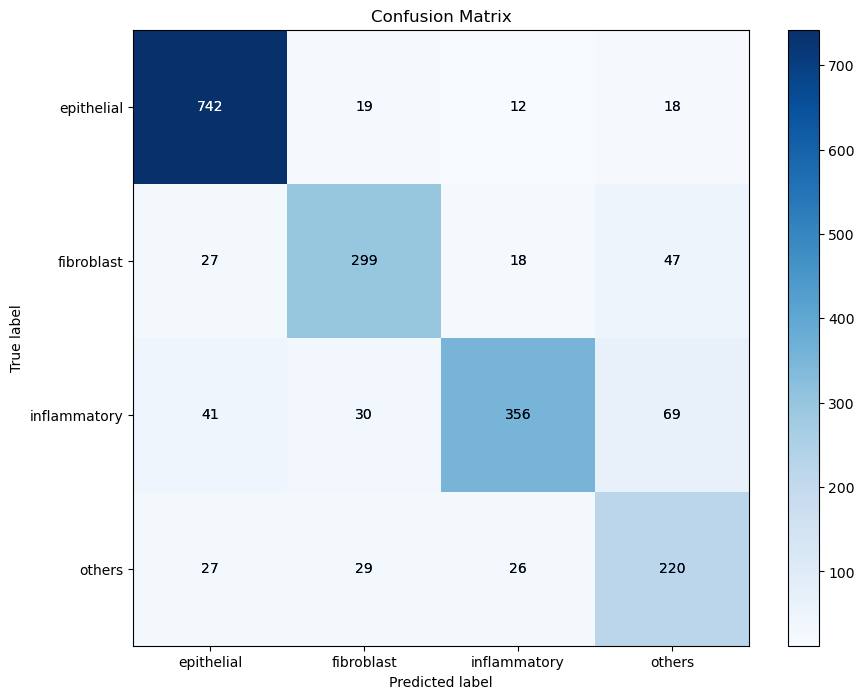

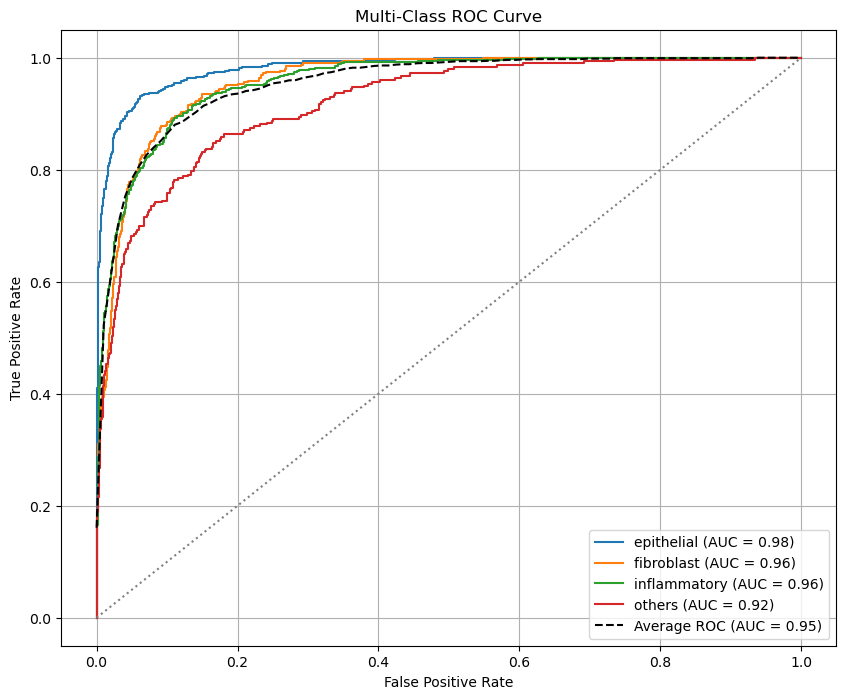

In [122]:
# Get true labels from the generator
true_labels = np.concatenate([test_ds_ct[i][1] for i in range(len(test_ds_ct))])
true_labels_int = np.argmax(true_labels, axis=1)
class_names = list(test_ds_ct.class_indices.keys())

# Make prediction
pred_probabilities = cellType_solution.predict(test_ds_ct)
pred_labels_int = np.argmax(pred_probabilities, axis=1)

# Display metrics
display_multiclass_metrics(true_labels_int,pred_labels_int)

#Plot confusion matrix
plot_confusion_matrix_multi_class(true_labels_int, pred_labels_int, class_names)

#Plot AUC ROC 
plot_multiclass_roc_auc(true_labels_int, pred_probabilities, class_names)
# Save post-fine-tuning model
cellType_solution.save('post_fine_tuning_model_4FF_tune_augmentation.h5')

### Observation
The performance of the model after the extra process of applying `FlexMatch` has been slightly increased in all metrics. The AUC score of the second class is improved without hurting other classes. This result might be explained by the reason that my hyperparameter combination of choice might not be the most appropriate, and the model is already has acceptable training result with labeled data, therefore it's is a challenge to improve the performance; further investigation and more experiments will need to be conducted to archive better improvement.

# Reference
- Basha SHS, Ghosh S, Babu KK, Dubey SR, Pulabaigari V and Mukherjee S 2018, RCCNet: *'An Efficient Convolutional Neural Network for Histological Routine Colon Cancer Nuclei Classification'*, 18-21 Nov. 2018, https://arxiv.org/abs/1810.02797.
- Sohn K, Berthelot D, Li C-L, Zhang Z, Carlini N, Cubuk ED, Kurakin A, Zhang H and Raffel C (2020) *'FixMatch: Simplifying Semi-Supervised Learning with Consistency and Confidence'*, doi:10.48550/arxiv.2001.07685. https://arxiv.org/abs/2001.07685
- Zhang B, Wang Y, Hou W, Wu H, Wang J, Okumura M and Shinozaki T (2021) *'FlexMatch: Boosting Semi-Supervised Learning with Curriculum Pseudo Labeling'*, doi:10.48550/arxiv.2110.08263. https://arxiv.org/abs/2110.08263
- RandAugment,  https://imgaug.readthedocs.io/en/latest/source/overview/collections.html#randaugment
- All other concepts and coding syntaxes are referenced from our course materials.